## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


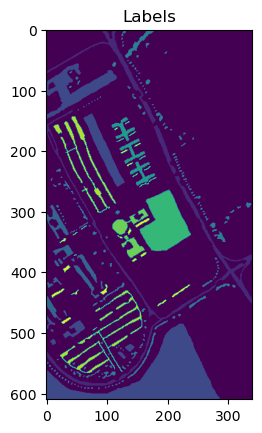

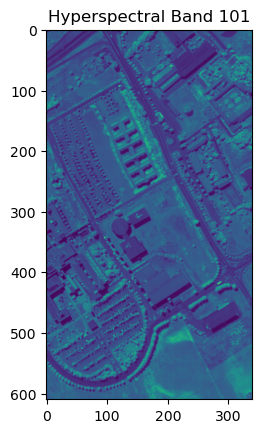

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 40 train


All datasets saved to the 'indices' folder.
(360, 5, 5, 103)
(45, 5, 5, 103)
(42371, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1207, PSNR: 7.2776


	 Training Batch [200/535], Loss: 0.0621, PSNR: 10.1969


	 Training Batch [400/535], Loss: 0.0267, PSNR: 13.9444


Epoch [1/50] Training Loss: 0.0553, PSNR: 11.1916
	[Val]   Batch [1/134] Loss: 0.0189, PSNR: 15.4293
	[Val]   Batch [10/134] Loss: 0.0167, PSNR: 17.7680
	[Val]   Batch [20/134] Loss: 0.0180, PSNR: 15.5593
	[Val]   Batch [30/134] Loss: 0.0194, PSNR: 15.0511
	[Val]   Batch [40/134] Loss: 0.0177, PSNR: 14.0548
	[Val]   Batch [50/134] Loss: 0.0188, PSNR: 15.2321
	[Val]   Batch [60/134] Loss: 0.0171, PSNR: 15.8790
	[Val]   Batch [70/134] Loss: 0.0162, PSNR: 16.0726


	[Val]   Batch [80/134] Loss: 0.0159, PSNR: 16.0677
	[Val]   Batch [90/134] Loss: 0.0166, PSNR: 16.0673
	[Val]   Batch [100/134] Loss: 0.0188, PSNR: 15.4649
	[Val]   Batch [110/134] Loss: 0.0191, PSNR: 14.0049
	[Val]   Batch [120/134] Loss: 0.0157, PSNR: 15.1528
	[Val]   Batch [130/134] Loss: 0.0173, PSNR: 13.1779
Epoch [1/50] Validation Loss: 0.0180, PSNR: 15.4314

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0181, PSNR: 15.6522


	 Training Batch [200/535], Loss: 0.0112, PSNR: 17.7490


	 Training Batch [400/535], Loss: 0.0128, PSNR: 18.4578


Epoch [2/50] Training Loss: 0.0118, PSNR: 17.4030
	[Val]   Batch [1/134] Loss: 0.0087, PSNR: 18.8218
	[Val]   Batch [10/134] Loss: 0.0070, PSNR: 21.5475
	[Val]   Batch [20/134] Loss: 0.0076, PSNR: 19.2694
	[Val]   Batch [30/134] Loss: 0.0086, PSNR: 18.5718
	[Val]   Batch [40/134] Loss: 0.0078, PSNR: 17.6196
	[Val]   Batch [50/134] Loss: 0.0081, PSNR: 18.8736
	[Val]   Batch [60/134] Loss: 0.0071, PSNR: 19.7136


	[Val]   Batch [70/134] Loss: 0.0069, PSNR: 19.7971
	[Val]   Batch [80/134] Loss: 0.0065, PSNR: 19.9215
	[Val]   Batch [90/134] Loss: 0.0070, PSNR: 19.8471
	[Val]   Batch [100/134] Loss: 0.0084, PSNR: 18.9884
	[Val]   Batch [110/134] Loss: 0.0079, PSNR: 17.8151
	[Val]   Batch [120/134] Loss: 0.0059, PSNR: 19.3726
	[Val]   Batch [130/134] Loss: 0.0071, PSNR: 17.0220
Epoch [2/50] Validation Loss: 0.0079, PSNR: 19.0358

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0073, PSNR: 17.8610


	 Training Batch [200/535], Loss: 0.0079, PSNR: 19.1856


	 Training Batch [400/535], Loss: 0.0059, PSNR: 20.3615


Epoch [3/50] Training Loss: 0.0069, PSNR: 19.5672
	[Val]   Batch [1/134] Loss: 0.0063, PSNR: 20.2111
	[Val]   Batch [10/134] Loss: 0.0049, PSNR: 23.0636
	[Val]   Batch [20/134] Loss: 0.0054, PSNR: 20.7807
	[Val]   Batch [30/134] Loss: 0.0061, PSNR: 20.0556
	[Val]   Batch [40/134] Loss: 0.0056, PSNR: 19.0421
	[Val]   Batch [50/134] Loss: 0.0057, PSNR: 20.3834
	[Val]   Batch [60/134] Loss: 0.0049, PSNR: 21.3160


	[Val]   Batch [70/134] Loss: 0.0049, PSNR: 21.2889
	[Val]   Batch [80/134] Loss: 0.0045, PSNR: 21.5010
	[Val]   Batch [90/134] Loss: 0.0049, PSNR: 21.3755
	[Val]   Batch [100/134] Loss: 0.0060, PSNR: 20.4295
	[Val]   Batch [110/134] Loss: 0.0054, PSNR: 19.4601
	[Val]   Batch [120/134] Loss: 0.0039, PSNR: 21.2206
	[Val]   Batch [130/134] Loss: 0.0049, PSNR: 18.6377
Epoch [3/50] Validation Loss: 0.0056, PSNR: 20.5038

LOG: Epoch [4/50]


	 Training Batch [1/535], Loss: 0.0069, PSNR: 19.6970


	 Training Batch [200/535], Loss: 0.0047, PSNR: 21.1795


	 Training Batch [400/535], Loss: 0.0048, PSNR: 21.3002


Epoch [4/50] Training Loss: 0.0053, PSNR: 20.7808
	[Val]   Batch [1/134] Loss: 0.0045, PSNR: 21.6192
	[Val]   Batch [10/134] Loss: 0.0036, PSNR: 24.4373
	[Val]   Batch [20/134] Loss: 0.0038, PSNR: 22.3261
	[Val]   Batch [30/134] Loss: 0.0043, PSNR: 21.5987
	[Val]   Batch [40/134] Loss: 0.0039, PSNR: 20.5850
	[Val]   Batch [50/134] Loss: 0.0039, PSNR: 22.0365
	[Val]   Batch [60/134] Loss: 0.0035, PSNR: 22.6991


	[Val]   Batch [70/134] Loss: 0.0036, PSNR: 22.6625
	[Val]   Batch [80/134] Loss: 0.0033, PSNR: 22.9284
	[Val]   Batch [90/134] Loss: 0.0035, PSNR: 22.8212
	[Val]   Batch [100/134] Loss: 0.0043, PSNR: 21.8733
	[Val]   Batch [110/134] Loss: 0.0037, PSNR: 21.1296
	[Val]   Batch [120/134] Loss: 0.0027, PSNR: 22.8350
	[Val]   Batch [130/134] Loss: 0.0033, PSNR: 20.3145
Epoch [4/50] Validation Loss: 0.0040, PSNR: 21.9527

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0040, PSNR: 21.9498


	 Training Batch [200/535], Loss: 0.0042, PSNR: 22.0062


	 Training Batch [400/535], Loss: 0.0036, PSNR: 22.6217


Epoch [5/50] Training Loss: 0.0038, PSNR: 22.2318
	[Val]   Batch [1/134] Loss: 0.0032, PSNR: 23.2097
	[Val]   Batch [10/134] Loss: 0.0025, PSNR: 26.0012
	[Val]   Batch [20/134] Loss: 0.0025, PSNR: 24.1703
	[Val]   Batch [30/134] Loss: 0.0028, PSNR: 23.4497
	[Val]   Batch [40/134] Loss: 0.0025, PSNR: 22.5010
	[Val]   Batch [50/134] Loss: 0.0025, PSNR: 24.0573
	[Val]   Batch [60/134] Loss: 0.0026, PSNR: 24.0574


	[Val]   Batch [70/134] Loss: 0.0025, PSNR: 24.1662
	[Val]   Batch [80/134] Loss: 0.0023, PSNR: 24.4407
	[Val]   Batch [90/134] Loss: 0.0025, PSNR: 24.3426
	[Val]   Batch [100/134] Loss: 0.0029, PSNR: 23.5817
	[Val]   Batch [110/134] Loss: 0.0023, PSNR: 23.2080
	[Val]   Batch [120/134] Loss: 0.0018, PSNR: 24.6122
	[Val]   Batch [130/134] Loss: 0.0022, PSNR: 22.2039
Epoch [5/50] Validation Loss: 0.0028, PSNR: 23.6086

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0030, PSNR: 23.4614


	 Training Batch [200/535], Loss: 0.0028, PSNR: 23.6591


	 Training Batch [400/535], Loss: 0.0027, PSNR: 23.8860


Epoch [6/50] Training Loss: 0.0029, PSNR: 23.4086
	[Val]   Batch [1/134] Loss: 0.0026, PSNR: 24.0447
	[Val]   Batch [10/134] Loss: 0.0020, PSNR: 26.8841
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.2590
	[Val]   Batch [30/134] Loss: 0.0022, PSNR: 24.4746
	[Val]   Batch [40/134] Loss: 0.0020, PSNR: 23.5714
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.1443
	[Val]   Batch [60/134] Loss: 0.0022, PSNR: 24.8223


	[Val]   Batch [70/134] Loss: 0.0021, PSNR: 25.0184
	[Val]   Batch [80/134] Loss: 0.0019, PSNR: 25.3160
	[Val]   Batch [90/134] Loss: 0.0020, PSNR: 25.1679
	[Val]   Batch [100/134] Loss: 0.0023, PSNR: 24.5268
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.3982
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.6862
	[Val]   Batch [130/134] Loss: 0.0017, PSNR: 23.1939
Epoch [6/50] Validation Loss: 0.0023, PSNR: 24.5323

LOG: Epoch [7/50]


	 Training Batch [1/535], Loss: 0.0032, PSNR: 23.0561


	 Training Batch [200/535], Loss: 0.0023, PSNR: 24.6490


	 Training Batch [400/535], Loss: 0.0018, PSNR: 23.9783


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.1024
	[Val]   Batch [1/134] Loss: 0.0022, PSNR: 24.7078
	[Val]   Batch [10/134] Loss: 0.0017, PSNR: 27.5956
	[Val]   Batch [20/134] Loss: 0.0015, PSNR: 26.2139
	[Val]   Batch [30/134] Loss: 0.0018, PSNR: 25.3406
	[Val]   Batch [40/134] Loss: 0.0016, PSNR: 24.5022
	[Val]   Batch [50/134] Loss: 0.0015, PSNR: 26.0835


	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.4974
	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.7139
	[Val]   Batch [80/134] Loss: 0.0016, PSNR: 26.0405
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 25.8476
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.3067
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.4009
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.5823
	[Val]   Batch [130/134] Loss: 0.0014, PSNR: 24.0546
Epoch [7/50] Validation Loss: 0.0019, PSNR: 25.3143

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0023, PSNR: 24.2696


	 Training Batch [200/535], Loss: 0.0019, PSNR: 23.9066


	 Training Batch [400/535], Loss: 0.0025, PSNR: 25.5043


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.5734
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 25.0351
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 27.9713
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.7135
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.7480
	[Val]   Batch [40/134] Loss: 0.0014, PSNR: 24.9848
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.4950
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.8682


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.0852
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.4482
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.1876
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.7072
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.8840
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.0847
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.4526
Epoch [8/50] Validation Loss: 0.0017, PSNR: 25.7192

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.7097


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.0965


	 Training Batch [400/535], Loss: 0.0022, PSNR: 24.7420


Epoch [9/50] Training Loss: 0.0020, PSNR: 25.0118
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.3981
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.3341
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.1620
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.2247
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.4411
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.9403
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.2074


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.3891
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.8084
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.5185
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.1045
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.4553
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.5581
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.8548


Epoch [9/50] Validation Loss: 0.0016, PSNR: 26.1221

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.3749


	 Training Batch [200/535], Loss: 0.0016, PSNR: 22.8569


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.3821


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.2193
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.6611
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6127
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.5704
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.5508
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.8324
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.2667
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.5294


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.7196
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.1755
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.8312
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.4320
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.8492
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.9660
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.2295
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.4579

LOG: Epoch [11/50]


	 Training Batch [1/535], Loss: 0.0027, PSNR: 25.6664


	 Training Batch [200/535], Loss: 0.0022, PSNR: 24.8461


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.6875


Epoch [11/50] Training Loss: 0.0018, PSNR: 25.4744
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.7758
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.7249
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.6831
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.6825
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 25.9586
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4056
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.6324


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.8165
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2672
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.9339
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.5853
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.9431
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.0106
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.2917
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.5756

LOG: Epoch [12/50]


	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.7258


	 Training Batch [200/535], Loss: 0.0014, PSNR: 24.9955


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.2174


Epoch [12/50] Training Loss: 0.0017, PSNR: 25.6970
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0412
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 29.0072
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.1022
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0083
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.3503
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.7152
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9837


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1340
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.6670
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.2489
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.8706
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.3625
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.4727
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.6982
Epoch [12/50] Validation Loss: 0.0013, PSNR: 26.9166

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.2795


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.2581


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.7985


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8951
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3034
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2782
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.4837
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.3431
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.7240
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.0508
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.2813


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.4084
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.9561
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5352
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.1653
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.7896
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.8501
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.0846
Epoch [13/50] Validation Loss: 0.0012, PSNR: 27.2297

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 25.7401


	 Training Batch [200/535], Loss: 0.0021, PSNR: 26.7689


	 Training Batch [400/535], Loss: 0.0020, PSNR: 27.0024


Epoch [14/50] Training Loss: 0.0016, PSNR: 26.1022
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4730
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4582
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.7243
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.5368
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.9388
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.2544
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.4678
	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.5852


	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.1668
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.7108
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.3427
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 28.0208
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0726
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.2611
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.4290

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.3284


	 Training Batch [200/535], Loss: 0.0010, PSNR: 26.9919


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.6725


Epoch [15/50] Training Loss: 0.0015, PSNR: 26.2137
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.6773
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7011
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.0408
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.8318
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.2586
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.5628
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.7404
	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8178


	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.4319
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.9728
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.6062
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.3950
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3778
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.5767
Epoch [15/50] Validation Loss: 0.0011, PSNR: 27.7020

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 27.0838


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.1156


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.5303


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.3826
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8457
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8168
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.2425
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.9807
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.4231
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.6702
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.8833
	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 27.9746


	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.5818
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.0885
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.7174
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5206
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.4942
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.7291
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.8479

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0026, PSNR: 25.8480


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.8721


	 Training Batch [400/535], Loss: 0.0010, PSNR: 27.8501


Epoch [17/50] Training Loss: 0.0014, PSNR: 26.5365
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 26.9829
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9196
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4198
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.1265
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.5649
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.8206
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.0314


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.0929
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.7546
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.2582
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8539
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.6352
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.5874
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8695
Epoch [17/50] Validation Loss: 0.0010, PSNR: 27.9904

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.2242


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.6163


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.5228


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.6507
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.1853
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0850
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.7114
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.3472
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8072
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.0044
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.2892


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.3417
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.9914
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.4642
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.0453
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8419
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.8078
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1224
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.2054

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.9775


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.2602


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.9088


Epoch [19/50] Training Loss: 0.0013, PSNR: 26.7601
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.2501
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0938
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.7448
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.3743
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8262
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.9903


	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.3792
	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.4231
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.0595
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.5206
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.0975
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7856
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7849
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1175


Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.2442
Early stopping triggered at epoch 19. No improvement for 3 epochs.


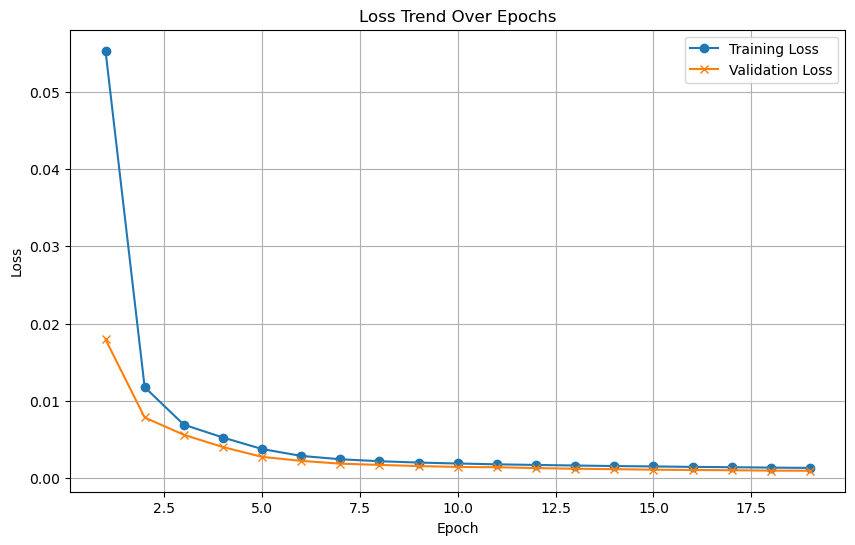

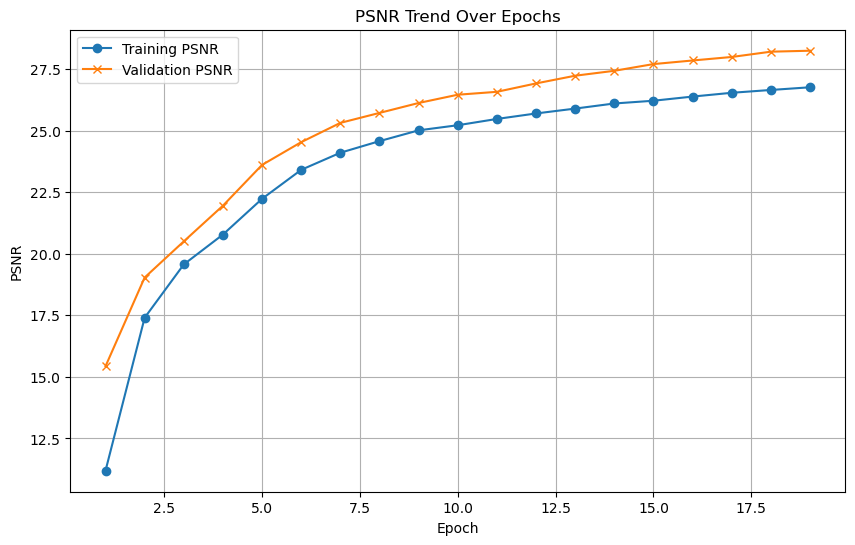

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...


    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/166 for test dataset.


    Processed batch 101/166 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2045
    Validation Batch [1/1], Loss: 2.2022
Validation Loss: 2.2022, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2022. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1342
    Validation Batch [1/1], Loss: 2.2022
Validation Loss: 2.2022, Validation Accuracy: 11.11%
Validation loss improved from 2.2022 to 2.2022. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0953
    Validation Batch [1/1], Loss: 2.2020
Validation Loss: 2.2020, Validation Accuracy: 11.11%
Validation loss improved from 2.2022 to 2.2020. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0670
    Validation Batch [1/1], Loss: 2.2018
Validation Loss: 2.2018, Validation Accuracy: 11.11%
Validation loss improved from 2.2020 to 2.2018. Saving model...

LOG: Epoch [5/1000

Epoch [13/1000] completed, Average Training Loss: 1.8655
    Validation Batch [1/1], Loss: 2.1779
Validation Loss: 2.1779, Validation Accuracy: 11.11%
Validation loss improved from 2.1865 to 2.1779. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 1.8516
    Validation Batch [1/1], Loss: 2.1651
Validation Loss: 2.1651, Validation Accuracy: 11.11%
Validation loss improved from 2.1779 to 2.1651. Saving model...

LOG: Epoch [15/1000] - Training
Epoch [15/1000] completed, Average Training Loss: 1.8190
    Validation Batch [1/1], Loss: 2.1481
Validation Loss: 2.1481, Validation Accuracy: 11.11%
Validation loss improved from 2.1651 to 2.1481. Saving model...

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 1.8087
    Validation Batch [1/1], Loss: 2.1274
Validation Loss: 2.1274, Validation Accuracy: 17.78%
Validation loss improved from 2.1481 to 2.1274. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [1

Epoch [30/1000] completed, Average Training Loss: 1.6231
    Validation Batch [1/1], Loss: 1.6914
Validation Loss: 1.6914, Validation Accuracy: 66.67%
Validation loss improved from 1.7117 to 1.6914. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 1.5827
    Validation Batch [1/1], Loss: 1.6577
Validation Loss: 1.6577, Validation Accuracy: 71.11%
Validation loss improved from 1.6914 to 1.6577. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 1.5646
    Validation Batch [1/1], Loss: 1.6308
Validation Loss: 1.6308, Validation Accuracy: 75.56%
Validation loss improved from 1.6577 to 1.6308. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 1.5377
    Validation Batch [1/1], Loss: 1.6075
Validation Loss: 1.6075, Validation Accuracy: 73.33%
Validation loss improved from 1.6308 to 1.6075. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [3

Epoch [47/1000] completed, Average Training Loss: 1.3153
    Validation Batch [1/1], Loss: 1.3446
Validation Loss: 1.3446, Validation Accuracy: 86.67%
Validation loss improved from 1.3804 to 1.3446. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 1.3104
    Validation Batch [1/1], Loss: 1.3385
Validation Loss: 1.3385, Validation Accuracy: 82.22%
Validation loss improved from 1.3446 to 1.3385. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 1.2881
    Validation Batch [1/1], Loss: 1.3207
Validation Loss: 1.3207, Validation Accuracy: 77.78%
Validation loss improved from 1.3385 to 1.3207. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 1.2746
    Validation Batch [1/1], Loss: 1.2864
Validation Loss: 1.2864, Validation Accuracy: 84.44%
Validation loss improved from 1.3207 to 1.2864. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [5

Epoch [63/1000] completed, Average Training Loss: 1.0437
    Validation Batch [1/1], Loss: 1.1442
Validation Loss: 1.1442, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.0358
    Validation Batch [1/1], Loss: 1.0903
Validation Loss: 1.0903, Validation Accuracy: 91.11%
Validation loss improved from 1.1179 to 1.0903. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.0363
    Validation Batch [1/1], Loss: 1.0755
Validation Loss: 1.0755, Validation Accuracy: 86.67%
Validation loss improved from 1.0903 to 1.0755. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 0.9880
    Validation Batch [1/1], Loss: 1.0409
Validation Loss: 1.0409, Validation Accuracy: 86.67%
Validation loss improved from 1.0755 to 1.0409. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] complet

Epoch [80/1000] completed, Average Training Loss: 0.7843
    Validation Batch [1/1], Loss: 0.8308
Validation Loss: 0.8308, Validation Accuracy: 84.44%
Validation loss improved from 0.8599 to 0.8308. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 0.7709
    Validation Batch [1/1], Loss: 0.8306
Validation Loss: 0.8306, Validation Accuracy: 88.89%
Validation loss improved from 0.8308 to 0.8306. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 0.7613
    Validation Batch [1/1], Loss: 0.8277
Validation Loss: 0.8277, Validation Accuracy: 88.89%
Validation loss improved from 0.8306 to 0.8277. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 0.7247
    Validation Batch [1/1], Loss: 0.8112
Validation Loss: 0.8112, Validation Accuracy: 88.89%
Validation loss improved from 0.8277 to 0.8112. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [8

Epoch [98/1000] completed, Average Training Loss: 0.5598
    Validation Batch [1/1], Loss: 0.6074
Validation Loss: 0.6074, Validation Accuracy: 91.11%
Validation loss improved from 0.6318 to 0.6074. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 0.5497
    Validation Batch [1/1], Loss: 0.6277
Validation Loss: 0.6277, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 0.5147
    Validation Batch [1/1], Loss: 0.6330
Validation Loss: 0.6330, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 0.5346
    Validation Batch [1/1], Loss: 0.5909
Validation Loss: 0.5909, Validation Accuracy: 88.89%
Validation loss improved from 0.6074 to 0.5909. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Avera

Epoch [116/1000] completed, Average Training Loss: 0.3715
    Validation Batch [1/1], Loss: 0.4421
Validation Loss: 0.4421, Validation Accuracy: 95.56%
Validation loss improved from 0.4778 to 0.4421. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 0.3591
    Validation Batch [1/1], Loss: 0.5054
Validation Loss: 0.5054, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 0.3487
    Validation Batch [1/1], Loss: 0.5343
Validation Loss: 0.5343, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 0.3440
    Validation Batch [1/1], Loss: 0.4486
Validation Loss: 0.4486, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training 

Epoch [134/1000] completed, Average Training Loss: 0.2469
    Validation Batch [1/1], Loss: 0.3898
Validation Loss: 0.3898, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 0.2413
    Validation Batch [1/1], Loss: 0.4565
Validation Loss: 0.4565, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.2666
    Validation Batch [1/1], Loss: 0.3795
Validation Loss: 0.3795, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.2346
    Validation Batch [1/1], Loss: 0.3692
Validation Loss: 0.3692, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.2370
  

Epoch [152/1000] completed, Average Training Loss: 0.1939
    Validation Batch [1/1], Loss: 0.3645
Validation Loss: 0.3645, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.1778
    Validation Batch [1/1], Loss: 0.3704
Validation Loss: 0.3704, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.1680
    Validation Batch [1/1], Loss: 0.3594
Validation Loss: 0.3594, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 0.1790
    Validation Batch [1/1], Loss: 0.3220
Validation Loss: 0.3220, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 0.1641
  

Epoch [170/1000] completed, Average Training Loss: 0.1330
    Validation Batch [1/1], Loss: 0.3939
Validation Loss: 0.3939, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 0.1365
    Validation Batch [1/1], Loss: 0.3381
Validation Loss: 0.3381, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 0.1276
    Validation Batch [1/1], Loss: 0.3316
Validation Loss: 0.3316, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 0.1244
    Validation Batch [1/1], Loss: 0.3545
Validation Loss: 0.3545, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 0.1180
  

Epoch [187/1000] completed, Average Training Loss: 0.1041
    Validation Batch [1/1], Loss: 0.2886
Validation Loss: 0.2886, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.1057
    Validation Batch [1/1], Loss: 0.2772
Validation Loss: 0.2772, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.0961
    Validation Batch [1/1], Loss: 0.3578
Validation Loss: 0.3578, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.1046
    Validation Batch [1/1], Loss: 0.3112
Validation Loss: 0.3112, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.0865
  

Epoch [204/1000] completed, Average Training Loss: 0.0764
    Validation Batch [1/1], Loss: 0.3021
Validation Loss: 0.3021, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.0864
    Validation Batch [1/1], Loss: 0.3241
Validation Loss: 0.3241, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.0801
    Validation Batch [1/1], Loss: 0.3995
Validation Loss: 0.3995, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.0662
    Validation Batch [1/1], Loss: 0.3874
Validation Loss: 0.3874, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.072

Epoch [222/1000] completed, Average Training Loss: 0.0564
    Validation Batch [1/1], Loss: 0.3704
Validation Loss: 0.3704, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.0676
    Validation Batch [1/1], Loss: 0.3052
Validation Loss: 0.3052, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.0642
    Validation Batch [1/1], Loss: 0.2883
Validation Loss: 0.2883, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.0563
    Validation Batch [1/1], Loss: 0.3216
Validation Loss: 0.3216, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.058

Epoch [239/1000] completed, Average Training Loss: 0.0477
    Validation Batch [1/1], Loss: 0.2690
Validation Loss: 0.2690, Validation Accuracy: 93.33%
Validation loss improved from 0.2728 to 0.2690. Saving model...

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.0513
    Validation Batch [1/1], Loss: 0.2952
Validation Loss: 0.2952, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.0488
    Validation Batch [1/1], Loss: 0.3587
Validation Loss: 0.3587, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.0482
    Validation Batch [1/1], Loss: 0.3431
Validation Loss: 0.3431, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training 

Epoch [257/1000] completed, Average Training Loss: 0.0439
    Validation Batch [1/1], Loss: 0.3389
Validation Loss: 0.3389, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.3492
Validation Loss: 0.3492, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.0483
    Validation Batch [1/1], Loss: 0.3635
Validation Loss: 0.3635, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.0389
    Validation Batch [1/1], Loss: 0.3678
Validation Loss: 0.3678, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.036

Epoch [275/1000] completed, Average Training Loss: 0.0325
    Validation Batch [1/1], Loss: 0.3084
Validation Loss: 0.3084, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.0351
    Validation Batch [1/1], Loss: 0.3147
Validation Loss: 0.3147, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.0385
    Validation Batch [1/1], Loss: 0.3644
Validation Loss: 0.3644, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.0397
    Validation Batch [1/1], Loss: 0.4118
Validation Loss: 0.4118, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.035

Epoch [292/1000] completed, Average Training Loss: 0.0312
    Validation Batch [1/1], Loss: 0.3536
Validation Loss: 0.3536, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.0301
    Validation Batch [1/1], Loss: 0.3099
Validation Loss: 0.3099, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.0301
    Validation Batch [1/1], Loss: 0.2962
Validation Loss: 0.2962, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.0285
    Validation Batch [1/1], Loss: 0.3671
Validation Loss: 0.3671, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.031

Epoch [310/1000] completed, Average Training Loss: 0.0254
    Validation Batch [1/1], Loss: 0.4097
Validation Loss: 0.4097, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.0253
    Validation Batch [1/1], Loss: 0.4300
Validation Loss: 0.4300, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.0278
    Validation Batch [1/1], Loss: 0.3930
Validation Loss: 0.3930, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.0302
    Validation Batch [1/1], Loss: 0.3518
Validation Loss: 0.3518, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.021

    Validation Batch [1/1], Loss: 0.3664
Validation Loss: 0.3664, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.0244
    Validation Batch [1/1], Loss: 0.3801
Validation Loss: 0.3801, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.3952
Validation Loss: 0.3952, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.0259
    Validation Batch [1/1], Loss: 0.3600
Validation Loss: 0.3600, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.0188
    Validation Batch [1/1], Loss: 0.3416
Validation Loss

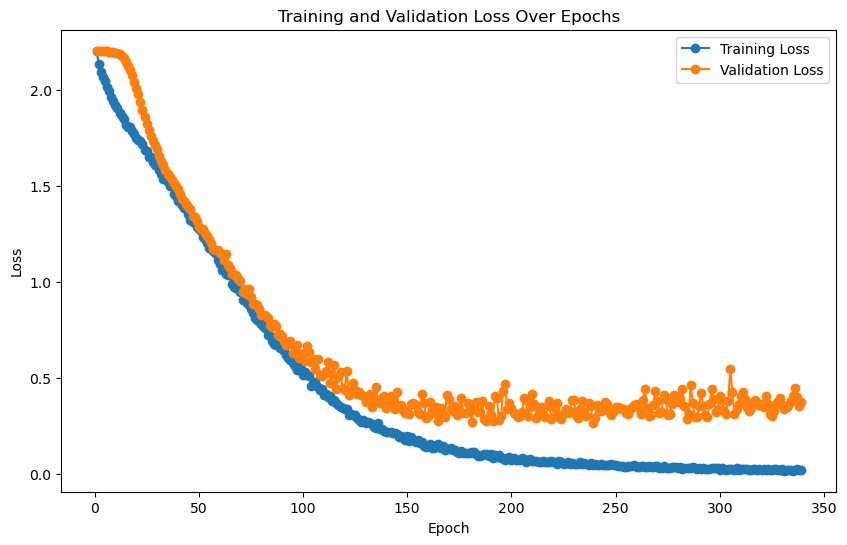

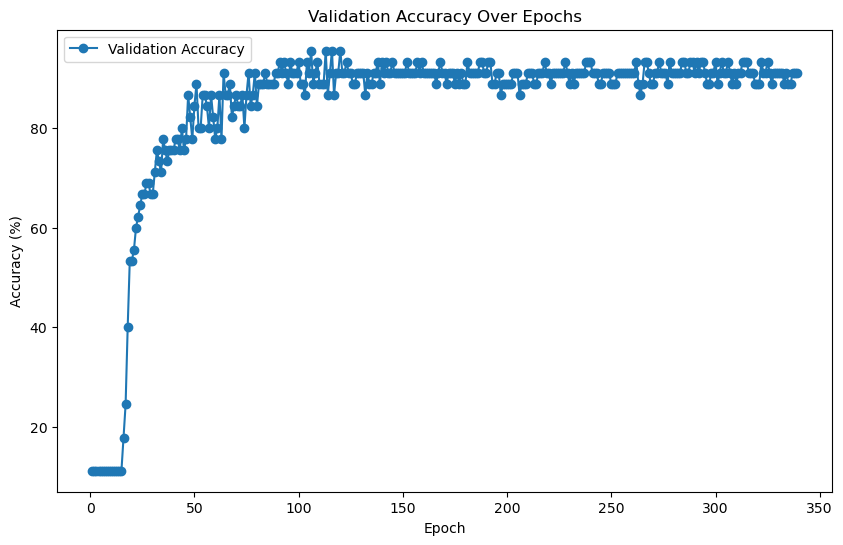


Evaluating on the test set...
    Test Batch [1/166], Loss: 0.7095



Final Test Loss: 0.2163, Test Accuracy: 93.10%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/166 for test dataset.
  Processed batch 20/166 for test dataset.
  Processed batch 30/166 for test dataset.
  Processed batch 40/166 for test dataset.


  Processed batch 50/166 for test dataset.
  Processed batch 60/166 for test dataset.
  Processed batch 70/166 for test dataset.
  Processed batch 80/166 for test dataset.
  Processed batch 90/166 for test dataset.


  Processed batch 100/166 for test dataset.
  Processed batch 110/166 for test dataset.
  Processed batch 120/166 for test dataset.
  Processed batch 130/166 for test dataset.
  Processed batch 140/166 for test dataset.


  Processed batch 150/166 for test dataset.
  Processed batch 160/166 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)

LOG: Training features shape: (360, 64), Training labels shape: (360,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42371, 64), Test labels shape: (42371,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.67      0.80      0.73         5
           2       0.67      0.80      0.73         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.60      0.75         5
           6       1.00      0.80      0.89         5
           7       0.67      0.80      0.73         5
           8       1.00      0.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)
Train reps shape: (360, 64)
Train labels shape: (360,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42371, 64)
Test labels shape: (42371,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1049  |  Val Loss: 1.9497
Validation loss improved from inf to 1.9497.
[Epoch 2/1000] Train Loss: 1.8087  |  Val Loss: 1.7734
Validation loss improved from 1.9497 to 1.7734.
[Epoch 3/1000] Train Loss: 1.6482  |  Val Loss: 1.6226
Validation loss improved from 1.7734 to 1.6226.
[Epoch 4/1000] Train Loss: 1.4980  |  Val Loss: 1.4668
Validation loss improved from 1.6226 to 1.4668.
[Epoch 5/1000] Train Loss: 1.3707  |  Val Loss: 1.3609
Validation loss improved from 1.4668 to 1.3609.
[Epoch 6/1000] Train Loss: 1.2686  |  Val Loss: 1.2668
Validation loss improved from 1.3609 to 1.2668.
[Epoch 7/1000] Train Loss: 1.1702  |  Val Loss: 1.1569
Validation loss improved from 1.2668 to 1.1569.
[Epoch 8/1000] Train Loss: 1.0863  |  Val Loss: 1.0853
Validation loss improved from 1.1569 to 1.0853.
[Epoch 9/1000] Train Loss: 1.0040  |  Val Loss: 1.0188
Validation loss improved from 1.0853 to 1.0188.
[Epoch 10/1000] Train Loss: 0.9287  |  Val Loss: 0.9455
Validation loss impr

[Epoch 13/1000] Train Loss: 0.7606  |  Val Loss: 0.7751
Validation loss improved from 0.8205 to 0.7751.
[Epoch 14/1000] Train Loss: 0.7180  |  Val Loss: 0.7510
Validation loss improved from 0.7751 to 0.7510.
[Epoch 15/1000] Train Loss: 0.6770  |  Val Loss: 0.7381
Validation loss improved from 0.7510 to 0.7381.
[Epoch 16/1000] Train Loss: 0.6407  |  Val Loss: 0.6894
Validation loss improved from 0.7381 to 0.6894.
[Epoch 17/1000] Train Loss: 0.6257  |  Val Loss: 0.6697
Validation loss improved from 0.6894 to 0.6697.
[Epoch 18/1000] Train Loss: 0.6029  |  Val Loss: 0.6566
Validation loss improved from 0.6697 to 0.6566.


[Epoch 19/1000] Train Loss: 0.5667  |  Val Loss: 0.6535
Validation loss improved from 0.6566 to 0.6535.
[Epoch 20/1000] Train Loss: 0.5539  |  Val Loss: 0.6371
Validation loss improved from 0.6535 to 0.6371.
[Epoch 21/1000] Train Loss: 0.5368  |  Val Loss: 0.6105
Validation loss improved from 0.6371 to 0.6105.
[Epoch 22/1000] Train Loss: 0.5173  |  Val Loss: 0.6083
Validation loss improved from 0.6105 to 0.6083.
[Epoch 23/1000] Train Loss: 0.5087  |  Val Loss: 0.6013
Validation loss improved from 0.6083 to 0.6013.
[Epoch 24/1000] Train Loss: 0.4990  |  Val Loss: 0.6110
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 25/1000] Train Loss: 0.4971  |  Val Loss: 0.5958
Validation loss improved from 0.6013 to 0.5958.
[Epoch 26/1000] Train Loss: 0.4814  |  Val Loss: 0.5808
Validation loss improved from 0.5958 to 0.5808.
[Epoch 27/1000] Train Loss: 0.4715  |  Val Loss: 0.5870
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 28/1000] Train Loss: 0.4639  |  Val Loss: 0.5

[Epoch 32/1000] Train Loss: 0.4311  |  Val Loss: 0.5467
Validation loss improved from 0.5534 to 0.5467.
[Epoch 33/1000] Train Loss: 0.4240  |  Val Loss: 0.5618
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 34/1000] Train Loss: 0.4243  |  Val Loss: 0.5683
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 35/1000] Train Loss: 0.4193  |  Val Loss: 0.5407
Validation loss improved from 0.5467 to 0.5407.


[Epoch 36/1000] Train Loss: 0.4158  |  Val Loss: 0.5560
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 0.3989  |  Val Loss: 0.5256
Validation loss improved from 0.5407 to 0.5256.
[Epoch 38/1000] Train Loss: 0.3984  |  Val Loss: 0.5229
Validation loss improved from 0.5256 to 0.5229.
[Epoch 39/1000] Train Loss: 0.3833  |  Val Loss: 0.5265
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 0.3797  |  Val Loss: 0.5223
Validation loss improved from 0.5229 to 0.5223.
[Epoch 41/1000] Train Loss: 0.3718  |  Val Loss: 0.5223
Validation loss improved from 0.5223 to 0.5223.
[Epoch 42/1000] Train Loss: 0.3708  |  Val Loss: 0.5095
Validation loss improved from 0.5223 to 0.5095.
[Epoch 43/1000] Train Loss: 0.3677  |  Val Loss: 0.5073
Validation loss improved from 0.5095 to 0.5073.
[Epoch 44/1000] Train Loss: 0.3659  |  Val Loss: 0.5261
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 0.3555  |  Val Los

[Epoch 49/1000] Train Loss: 0.3390  |  Val Loss: 0.5009
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 50/1000] Train Loss: 0.3350  |  Val Loss: 0.4868
Validation loss improved from 0.4916 to 0.4868.
[Epoch 51/1000] Train Loss: 0.3365  |  Val Loss: 0.4844
Validation loss improved from 0.4868 to 0.4844.
[Epoch 52/1000] Train Loss: 0.3368  |  Val Loss: 0.4985
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 53/1000] Train Loss: 0.3394  |  Val Loss: 0.4843
Validation loss improved from 0.4844 to 0.4843.
[Epoch 54/1000] Train Loss: 0.3395  |  Val Loss: 0.4843
Validation loss improved from 0.4843 to 0.4843.
[Epoch 55/1000] Train Loss: 0.3566  |  Val Loss: 0.4848
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 56/1000] Train Loss: 0.3834  |  Val Loss: 0.4694
Validation loss improved from 0.4843 to 0.4694.
[Epoch 57/1000] Train Loss: 0.3201  |  Val Loss: 0.5508
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 0.3171  |  Val Loss: 0.4670
Validation loss improved from 0.4694 to 0.4670.
[Epoch 59/1000] Train Loss: 0.3265  |  Val Loss: 0.4656
Validation loss improved from 0.4670 to 0.4656.
[Epoch 60/1000] Train Loss: 0.3087  |  Val Loss: 0.4922
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 61/1000] Train Loss: 0.3005  |  Val Loss: 0.4734
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 62/1000] Train Loss: 0.2915  |  V

[Epoch 66/1000] Train Loss: 0.2916  |  Val Loss: 0.4552
Validation loss improved from 0.4558 to 0.4552.


[Epoch 67/1000] Train Loss: 0.2735  |  Val Loss: 0.4784
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 0.2785  |  Val Loss: 0.4600
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 69/1000] Train Loss: 0.2712  |  Val Loss: 0.4616
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 70/1000] Train Loss: 0.2648  |  Val Loss: 0.4718
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 71/1000] Train Loss: 0.2634  |  Val Loss: 0.4477
Validation loss improved from 0.4552 to 0.4477.
[Epoch 72/1000] Train Loss: 0.2768  |  Val Loss: 0.4674
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 0.2665  |  Val Loss: 0.4480
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 0.2608  |  Val Loss: 0.4554
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 0.2578  |  Val Loss: 0.4506
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 76/1000] 

[Epoch 84/1000] Train Loss: 0.2360  |  Val Loss: 0.4739
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 85/1000] Train Loss: 0.2479  |  Val Loss: 0.4590
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 86/1000] Train Loss: 0.2472  |  Val Loss: 0.4554
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 87/1000] Train Loss: 0.2297  |  Val Loss: 0.4687
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 88/1000] Train Loss: 0.2232  |  Val Loss: 0.4660
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 89/1000] Train Loss: 0.2218  |  Val Loss: 0.4514
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 90/1000] Train Loss: 0.2172  |  Val Loss: 0.4585
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 91/1000] Train Loss: 0.2189  |  Val Loss: 0.4889
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 92/1000] Train Loss: 0.2203  |  Val Loss: 0.4608
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch

[Epoch 102/1000] Train Loss: 0.1986  |  Val Loss: 0.4911
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 103/1000] Train Loss: 0.1954  |  Val Loss: 0.5278
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 104/1000] Train Loss: 0.2066  |  Val Loss: 0.4979
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 105/1000] Train Loss: 0.1871  |  Val Loss: 0.5104
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 106/1000] Train Loss: 0.1829  |  Val Loss: 0.5123
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 107/1000] Train Loss: 0.1854  |  Val Loss: 0.5195
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 108/1000] Train Loss: 0.1773  |  Val Loss: 0.4990
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 109/1000] Train Loss: 0.1755  |  Val Loss: 0.5416
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 110/1000] Train Loss: 0.1722  |  Val Loss: 0.4932
!! Validation loss did NOT improve !! Patience:

[Epoch 119/1000] Train Loss: 0.1599  |  Val Loss: 0.5758
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 120/1000] Train Loss: 0.1634  |  Val Loss: 0.5511
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 121/1000] Train Loss: 0.1535  |  Val Loss: 0.6137
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 122/1000] Train Loss: 0.1623  |  Val Loss: 0.5737
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 123/1000] Train Loss: 0.1532  |  Val Loss: 0.6324
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 124/1000] Train Loss: 0.1683  |  Val Loss: 0.5756
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 125/1000] Train Loss: 0.1482  |  Val Loss: 0.5872
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 126/1000] Train Loss: 0.1456  |  Val Loss: 0.6028
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 127/1000] Train Loss: 0.1387  |  Val Loss: 0.6094
!! Validation loss did NOT improve !! Patience:

[Epoch 136/1000] Train Loss: 0.1414  |  Val Loss: 0.5930
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 137/1000] Train Loss: 0.1574  |  Val Loss: 0.7040
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 138/1000] Train Loss: 0.1488  |  Val Loss: 0.5804
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 139/1000] Train Loss: 0.1431  |  Val Loss: 0.7110
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 140/1000] Train Loss: 0.1357  |  Val Loss: 0.5998
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 141/1000] Train Loss: 0.1406  |  Val Loss: 0.6378
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 142/1000] Train Loss: 0.1313  |  Val Loss: 0.6068
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 143/1000] Train Loss: 0.1290  |  Val Loss: 0.6271
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 144/1000] Train Loss: 0.1391  |  Val Loss: 0.6648
!! Validation loss did NOT improve !! Patience:

[Epoch 152/1000] Train Loss: 0.1155  |  Val Loss: 0.6604
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 153/1000] Train Loss: 0.1225  |  Val Loss: 0.7126
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 154/1000] Train Loss: 0.1122  |  Val Loss: 0.6961
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 155/1000] Train Loss: 0.1072  |  Val Loss: 0.7039
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 156/1000] Train Loss: 0.1137  |  Val Loss: 0.7024
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 157/1000] Train Loss: 0.1148  |  Val Loss: 0.7138
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 158/1000] Train Loss: 0.1121  |  Val Loss: 0.7063
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 159/1000] Train Loss: 0.1120  |  Val Loss: 0.7056
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 160/1000] Train Loss: 0.1137  |  Val Loss: 0.7857
!! Validation loss did NOT improve !! Patience:

[Epoch 170/1000] Train Loss: 0.1026  |  Val Loss: 0.7203
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 171/1000] Train Loss: 0.1223  |  Val Loss: 0.8826
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 172/1000] Train Loss: 0.1202  |  Val Loss: 0.7194
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 173/1000] Train Loss: 0.1245  |  Val Loss: 0.7957
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 174/1000] Train Loss: 0.1230  |  Val Loss: 0.7779
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 175/1000] Train Loss: 0.1074  |  Val Loss: 0.7567
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 176/1000] Train Loss: 0.1145  |  Val Loss: 0.7927
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 177/1000] Train Loss: 0.0962  |  Val Loss: 0.7814
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 178/1000] Train Loss: 0.0944  |  Val Loss: 0.7722
!! Validation loss did NOT improve !! Patience:

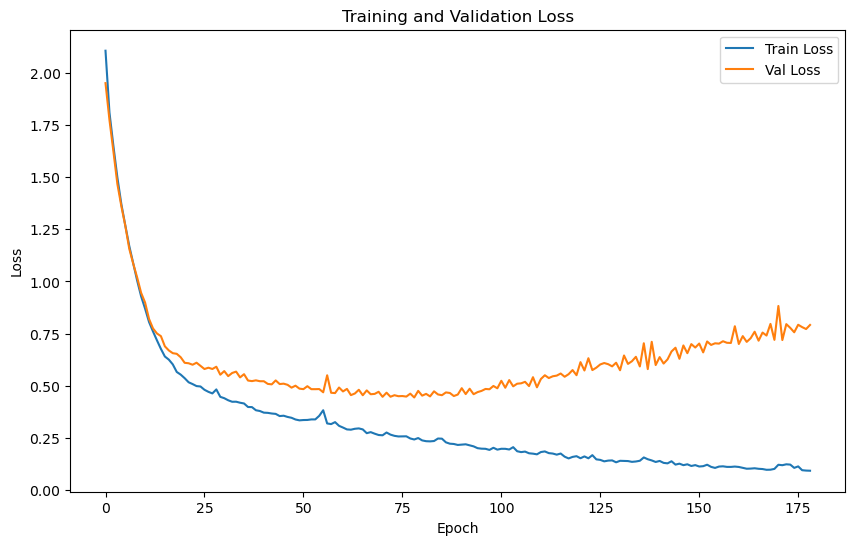

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.8860 | Test Accuracy: 76.08%


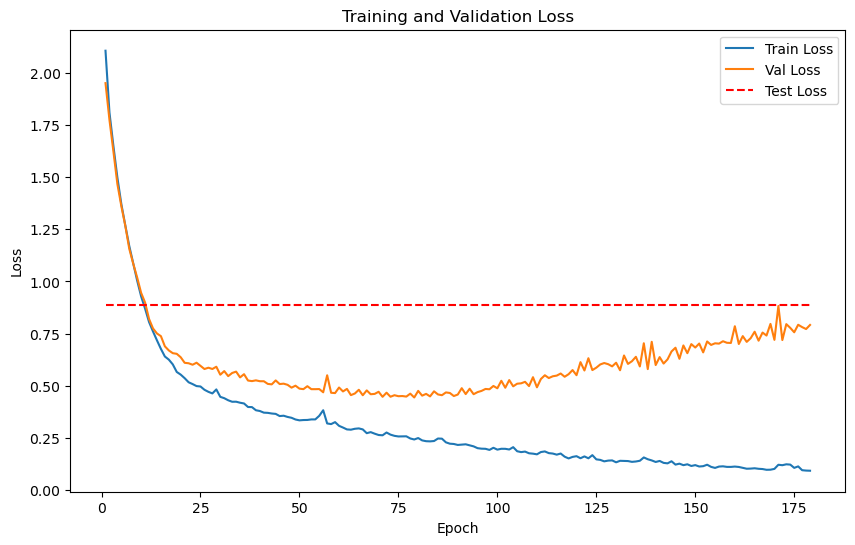

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42371, 64), 
Test labels shape: (42371,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/2], Train Loss: 8.9104
    Batch [2/2], Train Loss: 9.1433
Epoch [1/2000], Avg Train Loss: 9.0269
Epoch [1/2000], Avg Val Loss: 4.5558
Validation loss improved from inf to 4.5558. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.7279
    Batch [2/2], Train Loss: 8.9245
Epoch [2/2000], Avg Train Loss: 8.8262
Epoch [2/2000], Avg Val Loss: 4.4564
Validation loss improved from 4.5558 to 4.4564. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 8.7022
    Batch [2/2], Train Loss: 8.5693
Epoch [3/2000], Avg Train Loss: 8.6357
Epoch [3/2000], Avg Val Loss: 4.3612
Validation loss improved from 4.4564 to 4.3612. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 8.5330
    Batch [2/2], Train Loss: 8.3323
Epoch [4/2000], Avg Train Loss: 8.4327
Epoch [4/2000], Avg Val Loss: 4.2699
Validation loss improved from 4.3612 to 4.2699. Saving model...

LOG: Epoch [5/2000] - Trai

    Batch [1/2], Train Loss: 8.0028
    Batch [2/2], Train Loss: 7.8788
Epoch [8/2000], Avg Train Loss: 7.9408
Epoch [8/2000], Avg Val Loss: 3.9444
Validation loss improved from 4.0201 to 3.9444. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/2], Train Loss: 7.8314
    Batch [2/2], Train Loss: 7.9432
Epoch [9/2000], Avg Train Loss: 7.8873
Epoch [9/2000], Avg Val Loss: 3.8728
Validation loss improved from 3.9444 to 3.8728. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 7.4698
    Batch [2/2], Train Loss: 7.6504
Epoch [10/2000], Avg Train Loss: 7.5601
Epoch [10/2000], Avg Val Loss: 3.8047
Validation loss improved from 3.8728 to 3.8047. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 7.5967
    Batch [2/2], Train Loss: 7.3868
Epoch [11/2000], Avg Train Loss: 7.4918
Epoch [11/2000], Avg Val Loss: 3.7403
Validation loss improved from 3.8047 to 3.7403. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], 

    Batch [1/2], Train Loss: 6.8854
    Batch [2/2], Train Loss: 6.8880
Epoch [16/2000], Avg Train Loss: 6.8867
Epoch [16/2000], Avg Val Loss: 3.4686
Validation loss improved from 3.5166 to 3.4686. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 7.0524
    Batch [2/2], Train Loss: 6.7472
Epoch [17/2000], Avg Train Loss: 6.8998
Epoch [17/2000], Avg Val Loss: 3.4232
Validation loss improved from 3.4686 to 3.4232. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 6.6361
    Batch [2/2], Train Loss: 6.6902
Epoch [18/2000], Avg Train Loss: 6.6631
Epoch [18/2000], Avg Val Loss: 3.3801
Validation loss improved from 3.4232 to 3.3801. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 6.8189
    Batch [2/2], Train Loss: 6.4413
Epoch [19/2000], Avg Train Loss: 6.6301
Epoch [19/2000], Avg Val Loss: 3.3394
Validation loss improved from 3.3801 to 3.3394. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.6088
    Batch [2/2], Train Loss: 5.3413
Epoch [35/2000], Avg Train Loss: 5.4750
Epoch [35/2000], Avg Val Loss: 2.9475
Validation loss improved from 2.9614 to 2.9475. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.4725
    Batch [2/2], Train Loss: 5.3837
Epoch [36/2000], Avg Train Loss: 5.4281
Epoch [36/2000], Avg Val Loss: 2.9345
Validation loss improved from 2.9475 to 2.9345. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.5471
    Batch [2/2], Train Loss: 5.3988
Epoch [37/2000], Avg Train Loss: 5.4730
Epoch [37/2000], Avg Val Loss: 2.9223
Validation loss improved from 2.9345 to 2.9223. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 5.3814
    Batch [2/2], Train Loss: 5.4167
Epoch [38/2000], Avg Train Loss: 5.3990
Epoch [38/2000], Avg Val Loss: 2.9111
Validation loss improved from 2.9223 to 2.9111. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.3874
Epoch [39/2000], Avg Train Loss: 5.3704
Epoch [39/2000], Avg Val Loss: 2.9005
Validation loss improved from 2.9111 to 2.9005. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 5.2575
    Batch [2/2], Train Loss: 5.2247
Epoch [40/2000], Avg Train Loss: 5.2411
Epoch [40/2000], Avg Val Loss: 2.8905
Validation loss improved from 2.9005 to 2.8905. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 5.3623
    Batch [2/2], Train Loss: 5.1699
Epoch [41/2000], Avg Train Loss: 5.2661
Epoch [41/2000], Avg Val Loss: 2.8813
Validation loss improved from 2.8905 to 2.8813. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 5.1932
    Batch [2/2], Train Loss: 5.2286
Epoch [42/2000], Avg Train Loss: 5.2109
Epoch [42/2000], Avg Val Loss: 2.8726
Validation loss improved from 2.8813 to 2.8726. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 5.0787
    Batch [2

    Batch [1/2], Train Loss: 4.8859
    Batch [2/2], Train Loss: 4.7944
Epoch [60/2000], Avg Train Loss: 4.8402
Epoch [60/2000], Avg Val Loss: 2.7829
Validation loss improved from 2.7859 to 2.7829. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 4.8127
    Batch [2/2], Train Loss: 4.8762
Epoch [61/2000], Avg Train Loss: 4.8444
Epoch [61/2000], Avg Val Loss: 2.7800
Validation loss improved from 2.7829 to 2.7800. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 4.8595
    Batch [2/2], Train Loss: 4.7775
Epoch [62/2000], Avg Train Loss: 4.8185
Epoch [62/2000], Avg Val Loss: 2.7771
Validation loss improved from 2.7800 to 2.7771. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 4.9004
    Batch [2/2], Train Loss: 4.7287
Epoch [63/2000], Avg Train Loss: 4.8146
Epoch [63/2000], Avg Val Loss: 2.7743
Validation loss improved from 2.7771 to 2.7743. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1

Epoch [85/2000], Avg Val Loss: 2.7255
Validation loss improved from 2.7273 to 2.7255. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 4.4977
    Batch [2/2], Train Loss: 4.5459
Epoch [86/2000], Avg Train Loss: 4.5218
Epoch [86/2000], Avg Val Loss: 2.7237
Validation loss improved from 2.7255 to 2.7237. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 4.5697
    Batch [2/2], Train Loss: 4.5472
Epoch [87/2000], Avg Train Loss: 4.5585
Epoch [87/2000], Avg Val Loss: 2.7219
Validation loss improved from 2.7237 to 2.7219. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 4.5118
    Batch [2/2], Train Loss: 4.5721
Epoch [88/2000], Avg Train Loss: 4.5419
Epoch [88/2000], Avg Val Loss: 2.7201
Validation loss improved from 2.7219 to 2.7201. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 4.4849
    Batch [2/2], Train Loss: 4.5761
Epoch [89/2000], Avg Train Loss: 4.5305
Epoch [89/20

Epoch [112/2000], Avg Val Loss: 2.6830
Validation loss improved from 2.6843 to 2.6830. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 4.3595
    Batch [2/2], Train Loss: 4.3770
Epoch [113/2000], Avg Train Loss: 4.3683
Epoch [113/2000], Avg Val Loss: 2.6818
Validation loss improved from 2.6830 to 2.6818. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 4.4152
    Batch [2/2], Train Loss: 4.4171
Epoch [114/2000], Avg Train Loss: 4.4161
Epoch [114/2000], Avg Val Loss: 2.6805
Validation loss improved from 2.6818 to 2.6805. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 4.4276
    Batch [2/2], Train Loss: 4.4262
Epoch [115/2000], Avg Train Loss: 4.4269
Epoch [115/2000], Avg Val Loss: 2.6792
Validation loss improved from 2.6805 to 2.6792. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 4.4043
    Batch [2/2], Train Loss: 4.4257
Epoch [116/2000], Avg Train Loss: 4.4150


    Batch [1/2], Train Loss: 4.3416
    Batch [2/2], Train Loss: 4.2574
Epoch [137/2000], Avg Train Loss: 4.2995
Epoch [137/2000], Avg Val Loss: 2.6537
Validation loss improved from 2.6548 to 2.6537. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 4.3004
    Batch [2/2], Train Loss: 4.2750
Epoch [138/2000], Avg Train Loss: 4.2877
Epoch [138/2000], Avg Val Loss: 2.6526
Validation loss improved from 2.6537 to 2.6526. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 4.2760
    Batch [2/2], Train Loss: 4.3203
Epoch [139/2000], Avg Train Loss: 4.2982
Epoch [139/2000], Avg Val Loss: 2.6514
Validation loss improved from 2.6526 to 2.6514. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 4.2368
    Batch [2/2], Train Loss: 4.3160
Epoch [140/2000], Avg Train Loss: 4.2764
Epoch [140/2000], Avg Val Loss: 2.6502
Validation loss improved from 2.6514 to 2.6502. Saving model...

LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 4.2449
    Batch [2/2], Train Loss: 4.2264
Epoch [163/2000], Avg Train Loss: 4.2357
Epoch [163/2000], Avg Val Loss: 2.6301
Validation loss improved from 2.6307 to 2.6301. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 4.2557
    Batch [2/2], Train Loss: 4.2441
Epoch [164/2000], Avg Train Loss: 4.2499
Epoch [164/2000], Avg Val Loss: 2.6294
Validation loss improved from 2.6301 to 2.6294. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 4.2369
    Batch [2/2], Train Loss: 4.2240
Epoch [165/2000], Avg Train Loss: 4.2305
Epoch [165/2000], Avg Val Loss: 2.6287
Validation loss improved from 2.6294 to 2.6287. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 4.2050
    Batch [2/2], Train Loss: 4.2216
Epoch [166/2000], Avg Train Loss: 4.2133
Epoch [166/2000], Avg Val Loss: 2.6279
Validation loss improved from 2.6287 to 2.6279. Saving model...

LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 4.1798
    Batch [2/2], Train Loss: 4.2136
Epoch [190/2000], Avg Train Loss: 4.1967
Epoch [190/2000], Avg Val Loss: 2.6143
Validation loss improved from 2.6147 to 2.6143. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 4.1423
    Batch [2/2], Train Loss: 4.2346
Epoch [191/2000], Avg Train Loss: 4.1884
Epoch [191/2000], Avg Val Loss: 2.6137
Validation loss improved from 2.6143 to 2.6137. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 4.1552
    Batch [2/2], Train Loss: 4.1519
Epoch [192/2000], Avg Train Loss: 4.1536
Epoch [192/2000], Avg Val Loss: 2.6131
Validation loss improved from 2.6137 to 2.6131. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 4.1394
    Batch [2/2], Train Loss: 4.2052
Epoch [193/2000], Avg Train Loss: 4.1723
Epoch [193/2000], Avg Val Loss: 2.6126
Validation loss improved from 2.6131 to 2.6126. Saving model...

LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 4.1382
    Batch [2/2], Train Loss: 4.0861
Epoch [217/2000], Avg Train Loss: 4.1122
Epoch [217/2000], Avg Val Loss: 2.6019
Validation loss improved from 2.6023 to 2.6019. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 4.1068
    Batch [2/2], Train Loss: 4.1369
Epoch [218/2000], Avg Train Loss: 4.1219
Epoch [218/2000], Avg Val Loss: 2.6013
Validation loss improved from 2.6019 to 2.6013. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 4.1621
    Batch [2/2], Train Loss: 4.1099
Epoch [219/2000], Avg Train Loss: 4.1360
Epoch [219/2000], Avg Val Loss: 2.6008
Validation loss improved from 2.6013 to 2.6008. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 4.0735
    Batch [2/2], Train Loss: 4.1529
Epoch [220/2000], Avg Train Loss: 4.1132
Epoch [220/2000], Avg Val Loss: 2.6004
Validation loss improved from 2.6008 to 2.6004. Saving model...

LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 4.0452
    Batch [2/2], Train Loss: 4.0871
Epoch [243/2000], Avg Train Loss: 4.0661
Epoch [243/2000], Avg Val Loss: 2.5929
Validation loss improved from 2.5934 to 2.5929. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 4.1132
    Batch [2/2], Train Loss: 4.0621
Epoch [244/2000], Avg Train Loss: 4.0877
Epoch [244/2000], Avg Val Loss: 2.5923
Validation loss improved from 2.5929 to 2.5923. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 4.0855
    Batch [2/2], Train Loss: 4.0407
Epoch [245/2000], Avg Train Loss: 4.0631
Epoch [245/2000], Avg Val Loss: 2.5917
Validation loss improved from 2.5923 to 2.5917. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 4.0268
    Batch [2/2], Train Loss: 4.0826
Epoch [246/2000], Avg Train Loss: 4.0547
Epoch [246/2000], Avg Val Loss: 2.5911
Validation loss improved from 2.5917 to 2.5911. Saving model...

LOG: Epoch [247/2000] - Training


    Batch [2/2], Train Loss: 4.0505
Epoch [268/2000], Avg Train Loss: 4.0701
Epoch [268/2000], Avg Val Loss: 2.5852
Validation loss improved from 2.5856 to 2.5852. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 4.0420
    Batch [2/2], Train Loss: 4.0186
Epoch [269/2000], Avg Train Loss: 4.0303
Epoch [269/2000], Avg Val Loss: 2.5849
Validation loss improved from 2.5852 to 2.5849. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 4.0828
    Batch [2/2], Train Loss: 4.0306
Epoch [270/2000], Avg Train Loss: 4.0567
Epoch [270/2000], Avg Val Loss: 2.5845
Validation loss improved from 2.5849 to 2.5845. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 4.0136
    Batch [2/2], Train Loss: 4.0342
Epoch [271/2000], Avg Train Loss: 4.0239
Epoch [271/2000], Avg Val Loss: 2.5840
Validation loss improved from 2.5845 to 2.5840. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 4.0208


    Batch [2/2], Train Loss: 4.0321
Epoch [294/2000], Avg Train Loss: 4.0308
Epoch [294/2000], Avg Val Loss: 2.5786
Validation loss improved from 2.5790 to 2.5786. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 4.0103
    Batch [2/2], Train Loss: 4.0401
Epoch [295/2000], Avg Train Loss: 4.0252
Epoch [295/2000], Avg Val Loss: 2.5783
Validation loss improved from 2.5786 to 2.5783. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 4.0672
    Batch [2/2], Train Loss: 4.0352
Epoch [296/2000], Avg Train Loss: 4.0512
Epoch [296/2000], Avg Val Loss: 2.5778
Validation loss improved from 2.5783 to 2.5778. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 3.9975
    Batch [2/2], Train Loss: 3.9587
Epoch [297/2000], Avg Train Loss: 3.9781
Epoch [297/2000], Avg Val Loss: 2.5774
Validation loss improved from 2.5778 to 2.5774. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 3.9888


Epoch [319/2000], Avg Val Loss: 2.5735
Validation loss improved from 2.5736 to 2.5735. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 4.0422
    Batch [2/2], Train Loss: 4.0430
Epoch [320/2000], Avg Train Loss: 4.0426
Epoch [320/2000], Avg Val Loss: 2.5734
Validation loss improved from 2.5735 to 2.5734. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 3.9757
    Batch [2/2], Train Loss: 4.0049
Epoch [321/2000], Avg Train Loss: 3.9903
Epoch [321/2000], Avg Val Loss: 2.5733
Validation loss improved from 2.5734 to 2.5733. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 3.9360
    Batch [2/2], Train Loss: 3.9515
Epoch [322/2000], Avg Train Loss: 3.9438
Epoch [322/2000], Avg Val Loss: 2.5731
Validation loss improved from 2.5733 to 2.5731. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 3.9797
    Batch [2/2], Train Loss: 4.0355
Epoch [323/2000], Avg Train Loss: 4.0076


    Batch [2/2], Train Loss: 3.9845
Epoch [345/2000], Avg Train Loss: 3.9904
Epoch [345/2000], Avg Val Loss: 2.5691
Validation loss improved from 2.5691 to 2.5691. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 3.9469
    Batch [2/2], Train Loss: 3.9563
Epoch [346/2000], Avg Train Loss: 3.9516
Epoch [346/2000], Avg Val Loss: 2.5689
Validation loss improved from 2.5691 to 2.5689. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 3.9404
    Batch [2/2], Train Loss: 3.9545
Epoch [347/2000], Avg Train Loss: 3.9474
Epoch [347/2000], Avg Val Loss: 2.5687
Validation loss improved from 2.5689 to 2.5687. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 3.9753
    Batch [2/2], Train Loss: 3.9664
Epoch [348/2000], Avg Train Loss: 3.9709
Epoch [348/2000], Avg Val Loss: 2.5684
Validation loss improved from 2.5687 to 2.5684. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 4.0165


    Batch [1/2], Train Loss: 3.9571
    Batch [2/2], Train Loss: 3.9744
Epoch [370/2000], Avg Train Loss: 3.9658
Epoch [370/2000], Avg Val Loss: 2.5674
Validation loss did not improve. Patience: 16/100

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 3.9503
    Batch [2/2], Train Loss: 3.8987
Epoch [371/2000], Avg Train Loss: 3.9245
Epoch [371/2000], Avg Val Loss: 2.5674
Validation loss did not improve. Patience: 17/100

LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 3.9357
    Batch [2/2], Train Loss: 3.9694
Epoch [372/2000], Avg Train Loss: 3.9525
Epoch [372/2000], Avg Val Loss: 2.5676
Validation loss did not improve. Patience: 18/100

LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 3.9265
    Batch [2/2], Train Loss: 3.9233
Epoch [373/2000], Avg Train Loss: 3.9249
Epoch [373/2000], Avg Val Loss: 2.5676
Validation loss did not improve. Patience: 19/100

LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 3.8891
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.9095
    Batch [2/2], Train Loss: 3.9117
Epoch [395/2000], Avg Train Loss: 3.9106
Epoch [395/2000], Avg Val Loss: 2.5627
Validation loss did not improve. Patience: 9/100

LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 3.9194
    Batch [2/2], Train Loss: 3.9091
Epoch [396/2000], Avg Train Loss: 3.9143
Epoch [396/2000], Avg Val Loss: 2.5626
Validation loss did not improve. Patience: 10/100

LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 3.9104
    Batch [2/2], Train Loss: 3.8891
Epoch [397/2000], Avg Train Loss: 3.8998
Epoch [397/2000], Avg Val Loss: 2.5625
Validation loss did not improve. Patience: 11/100

LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 3.9882
    Batch [2/2], Train Loss: 3.9214
Epoch [398/2000], Avg Train Loss: 3.9548
Epoch [398/2000], Avg Val Loss: 2.5624
Validation loss did not improve. Patience: 12/100

LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 3.9400
    Batch [2/2], Trai

    Batch [1/2], Train Loss: 3.8918
    Batch [2/2], Train Loss: 3.9540
Epoch [420/2000], Avg Train Loss: 3.9229
Epoch [420/2000], Avg Val Loss: 2.5598
Validation loss improved from 2.5601 to 2.5598. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 3.8599
    Batch [2/2], Train Loss: 3.9352
Epoch [421/2000], Avg Train Loss: 3.8976
Epoch [421/2000], Avg Val Loss: 2.5594
Validation loss improved from 2.5598 to 2.5594. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 3.8397
    Batch [2/2], Train Loss: 3.9027
Epoch [422/2000], Avg Train Loss: 3.8712
Epoch [422/2000], Avg Val Loss: 2.5591
Validation loss improved from 2.5594 to 2.5591. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 3.9503
    Batch [2/2], Train Loss: 3.8772
Epoch [423/2000], Avg Train Loss: 3.9138
Epoch [423/2000], Avg Val Loss: 2.5588
Validation loss improved from 2.5591 to 2.5588. Saving model...

LOG: Epoch [424/2000] - Training


    Batch [2/2], Train Loss: 3.8708
Epoch [445/2000], Avg Train Loss: 3.8734
Epoch [445/2000], Avg Val Loss: 2.5573
Validation loss did not improve. Patience: 12/100

LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 3.9085
    Batch [2/2], Train Loss: 3.8713
Epoch [446/2000], Avg Train Loss: 3.8899
Epoch [446/2000], Avg Val Loss: 2.5570
Validation loss did not improve. Patience: 13/100

LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 3.8954
    Batch [2/2], Train Loss: 3.8941
Epoch [447/2000], Avg Train Loss: 3.8948
Epoch [447/2000], Avg Val Loss: 2.5567
Validation loss did not improve. Patience: 14/100

LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 3.9141
    Batch [2/2], Train Loss: 3.9126
Epoch [448/2000], Avg Train Loss: 3.9134
Epoch [448/2000], Avg Val Loss: 2.5564
Validation loss improved from 2.5565 to 2.5564. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 3.8790
    Batch [2/2], Train Loss: 3.8997
Epoch 

    Batch [2/2], Train Loss: 3.9003
Epoch [471/2000], Avg Train Loss: 3.8958
Epoch [471/2000], Avg Val Loss: 2.5546
Validation loss did not improve. Patience: 7/100

LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 3.8587
    Batch [2/2], Train Loss: 3.8302
Epoch [472/2000], Avg Train Loss: 3.8444
Epoch [472/2000], Avg Val Loss: 2.5550
Validation loss did not improve. Patience: 8/100

LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 3.9005
    Batch [2/2], Train Loss: 3.8423
Epoch [473/2000], Avg Train Loss: 3.8714
Epoch [473/2000], Avg Val Loss: 2.5554
Validation loss did not improve. Patience: 9/100

LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 3.8884
    Batch [2/2], Train Loss: 3.8587
Epoch [474/2000], Avg Train Loss: 3.8736
Epoch [474/2000], Avg Val Loss: 2.5560
Validation loss did not improve. Patience: 10/100

LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 3.8895
    Batch [2/2], Train Loss: 3.9251
Epoch [475/2000], Avg T

    Batch [2/2], Train Loss: 3.8365
Epoch [498/2000], Avg Train Loss: 3.8213
Epoch [498/2000], Avg Val Loss: 2.5565
Validation loss did not improve. Patience: 34/100

LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 3.8461
    Batch [2/2], Train Loss: 3.8992
Epoch [499/2000], Avg Train Loss: 3.8727
Epoch [499/2000], Avg Val Loss: 2.5568
Validation loss did not improve. Patience: 35/100

LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 3.8431
    Batch [2/2], Train Loss: 3.8598
Epoch [500/2000], Avg Train Loss: 3.8514
Epoch [500/2000], Avg Val Loss: 2.5569
Validation loss did not improve. Patience: 36/100

LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 3.8709
    Batch [2/2], Train Loss: 3.8069
Epoch [501/2000], Avg Train Loss: 3.8389
Epoch [501/2000], Avg Val Loss: 2.5569
Validation loss did not improve. Patience: 37/100

LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 3.8243
    Batch [2/2], Train Loss: 3.9047
Epoch [502/2000], Av

    Batch [1/2], Train Loss: 3.8841
    Batch [2/2], Train Loss: 3.8433
Epoch [523/2000], Avg Train Loss: 3.8637
Epoch [523/2000], Avg Val Loss: 2.5550
Validation loss did not improve. Patience: 59/100

LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 3.8265
    Batch [2/2], Train Loss: 3.8587
Epoch [524/2000], Avg Train Loss: 3.8426
Epoch [524/2000], Avg Val Loss: 2.5549
Validation loss did not improve. Patience: 60/100

LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 3.8513
    Batch [2/2], Train Loss: 3.8384
Epoch [525/2000], Avg Train Loss: 3.8448
Epoch [525/2000], Avg Val Loss: 2.5546
Validation loss did not improve. Patience: 61/100

LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 3.8922
    Batch [2/2], Train Loss: 3.8803
Epoch [526/2000], Avg Train Loss: 3.8862
Epoch [526/2000], Avg Val Loss: 2.5540
Validation loss did not improve. Patience: 62/100

LOG: Epoch [527/2000] - Training
    Batch [1/2], Train Loss: 3.9096
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.8505
    Batch [2/2], Train Loss: 3.8138
Epoch [548/2000], Avg Train Loss: 3.8321
Epoch [548/2000], Avg Val Loss: 2.5530
Validation loss did not improve. Patience: 14/100

LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 3.8603
    Batch [2/2], Train Loss: 3.8865
Epoch [549/2000], Avg Train Loss: 3.8734
Epoch [549/2000], Avg Val Loss: 2.5530
Validation loss did not improve. Patience: 15/100

LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 3.8767
    Batch [2/2], Train Loss: 3.8368
Epoch [550/2000], Avg Train Loss: 3.8568
Epoch [550/2000], Avg Val Loss: 2.5530
Validation loss did not improve. Patience: 16/100

LOG: Epoch [551/2000] - Training
    Batch [1/2], Train Loss: 3.8257
    Batch [2/2], Train Loss: 3.8271
Epoch [551/2000], Avg Train Loss: 3.8264
Epoch [551/2000], Avg Val Loss: 2.5532
Validation loss did not improve. Patience: 17/100

LOG: Epoch [552/2000] - Training
    Batch [1/2], Train Loss: 3.8859
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.8009
Epoch [574/2000], Avg Train Loss: 3.7945
Epoch [574/2000], Avg Val Loss: 2.5491
Validation loss did not improve. Patience: 11/100

LOG: Epoch [575/2000] - Training
    Batch [1/2], Train Loss: 3.8484
    Batch [2/2], Train Loss: 3.8478
Epoch [575/2000], Avg Train Loss: 3.8481
Epoch [575/2000], Avg Val Loss: 2.5490
Validation loss did not improve. Patience: 12/100

LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 3.8612
    Batch [2/2], Train Loss: 3.8210
Epoch [576/2000], Avg Train Loss: 3.8411
Epoch [576/2000], Avg Val Loss: 2.5485
Validation loss did not improve. Patience: 13/100

LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 3.8266
    Batch [2/2], Train Loss: 3.8605
Epoch [577/2000], Avg Train Loss: 3.8435
Epoch [577/2000], Avg Val Loss: 2.5483
Validation loss improved from 2.5485 to 2.5483. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 3.8350
    Batch [2/2], Train Loss: 3.8408
Epoch 

    Batch [1/2], Train Loss: 3.7927
    Batch [2/2], Train Loss: 3.8063
Epoch [588/2000], Avg Train Loss: 3.7995
Epoch [588/2000], Avg Val Loss: 2.5485
Validation loss did not improve. Patience: 8/100

LOG: Epoch [589/2000] - Training
    Batch [1/2], Train Loss: 3.8255
    Batch [2/2], Train Loss: 3.8064
Epoch [589/2000], Avg Train Loss: 3.8159
Epoch [589/2000], Avg Val Loss: 2.5485
Validation loss did not improve. Patience: 9/100

LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss: 3.8629
    Batch [2/2], Train Loss: 3.8684
Epoch [590/2000], Avg Train Loss: 3.8656
Epoch [590/2000], Avg Val Loss: 2.5485
Validation loss did not improve. Patience: 10/100

LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 3.8305
    Batch [2/2], Train Loss: 3.8636
Epoch [591/2000], Avg Train Loss: 3.8470
Epoch [591/2000], Avg Val Loss: 2.5485
Validation loss did not improve. Patience: 11/100

LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 3.8101
    Batch [2/2], Train

Epoch [615/2000], Avg Val Loss: 2.5493
Validation loss did not improve. Patience: 35/100

LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 3.8100
    Batch [2/2], Train Loss: 3.8000
Epoch [616/2000], Avg Train Loss: 3.8050
Epoch [616/2000], Avg Val Loss: 2.5492
Validation loss did not improve. Patience: 36/100

LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 3.7710
    Batch [2/2], Train Loss: 3.8167
Epoch [617/2000], Avg Train Loss: 3.7938
Epoch [617/2000], Avg Val Loss: 2.5493
Validation loss did not improve. Patience: 37/100

LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 3.8170
    Batch [2/2], Train Loss: 3.7957
Epoch [618/2000], Avg Train Loss: 3.8063
Epoch [618/2000], Avg Val Loss: 2.5491
Validation loss did not improve. Patience: 38/100

LOG: Epoch [619/2000] - Training
    Batch [1/2], Train Loss: 3.8066
    Batch [2/2], Train Loss: 3.8342
Epoch [619/2000], Avg Train Loss: 3.8204
Epoch [619/2000], Avg Val Loss: 2.5489
Validation loss d

    Batch [1/2], Train Loss: 3.8423
    Batch [2/2], Train Loss: 3.7838
Epoch [640/2000], Avg Train Loss: 3.8131
Epoch [640/2000], Avg Val Loss: 2.5473
Validation loss did not improve. Patience: 5/100

LOG: Epoch [641/2000] - Training
    Batch [1/2], Train Loss: 3.8204
    Batch [2/2], Train Loss: 3.8586
Epoch [641/2000], Avg Train Loss: 3.8395
Epoch [641/2000], Avg Val Loss: 2.5471
Validation loss did not improve. Patience: 6/100

LOG: Epoch [642/2000] - Training
    Batch [1/2], Train Loss: 3.7806
    Batch [2/2], Train Loss: 3.7773
Epoch [642/2000], Avg Train Loss: 3.7789
Epoch [642/2000], Avg Val Loss: 2.5470
Validation loss did not improve. Patience: 7/100

LOG: Epoch [643/2000] - Training
    Batch [1/2], Train Loss: 3.8067
    Batch [2/2], Train Loss: 3.8429
Epoch [643/2000], Avg Train Loss: 3.8248
Epoch [643/2000], Avg Val Loss: 2.5468
Validation loss did not improve. Patience: 8/100

LOG: Epoch [644/2000] - Training
    Batch [1/2], Train Loss: 3.7888
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.7448
    Batch [2/2], Train Loss: 3.7624
Epoch [666/2000], Avg Train Loss: 3.7536
Epoch [666/2000], Avg Val Loss: 2.5507
Validation loss did not improve. Patience: 31/100

LOG: Epoch [667/2000] - Training
    Batch [1/2], Train Loss: 3.8224
    Batch [2/2], Train Loss: 3.7820
Epoch [667/2000], Avg Train Loss: 3.8022
Epoch [667/2000], Avg Val Loss: 2.5503
Validation loss did not improve. Patience: 32/100

LOG: Epoch [668/2000] - Training
    Batch [1/2], Train Loss: 3.8009
    Batch [2/2], Train Loss: 3.7982
Epoch [668/2000], Avg Train Loss: 3.7996
Epoch [668/2000], Avg Val Loss: 2.5498
Validation loss did not improve. Patience: 33/100

LOG: Epoch [669/2000] - Training
    Batch [1/2], Train Loss: 3.7889
    Batch [2/2], Train Loss: 3.7796
Epoch [669/2000], Avg Train Loss: 3.7843
Epoch [669/2000], Avg Val Loss: 2.5493
Validation loss did not improve. Patience: 34/100

LOG: Epoch [670/2000] - Training
    Batch [1/2], Train Loss: 3.7827
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.7557
    Batch [2/2], Train Loss: 3.7636
Epoch [693/2000], Avg Train Loss: 3.7596
Epoch [693/2000], Avg Val Loss: 2.5501
Validation loss did not improve. Patience: 58/100

LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 3.7518
    Batch [2/2], Train Loss: 3.8014
Epoch [694/2000], Avg Train Loss: 3.7766
Epoch [694/2000], Avg Val Loss: 2.5504
Validation loss did not improve. Patience: 59/100

LOG: Epoch [695/2000] - Training
    Batch [1/2], Train Loss: 3.8124
    Batch [2/2], Train Loss: 3.7546
Epoch [695/2000], Avg Train Loss: 3.7835
Epoch [695/2000], Avg Val Loss: 2.5510
Validation loss did not improve. Patience: 60/100

LOG: Epoch [696/2000] - Training
    Batch [1/2], Train Loss: 3.8392
    Batch [2/2], Train Loss: 3.8146
Epoch [696/2000], Avg Train Loss: 3.8269
Epoch [696/2000], Avg Val Loss: 2.5516
Validation loss did not improve. Patience: 61/100

LOG: Epoch [697/2000] - Training
    Batch [1/2], Train Loss: 3.7603
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.7618
    Batch [2/2], Train Loss: 3.7508
Epoch [720/2000], Avg Train Loss: 3.7563
Epoch [720/2000], Avg Val Loss: 2.5484
Validation loss did not improve. Patience: 85/100

LOG: Epoch [721/2000] - Training
    Batch [1/2], Train Loss: 3.7885
    Batch [2/2], Train Loss: 3.7877
Epoch [721/2000], Avg Train Loss: 3.7881
Epoch [721/2000], Avg Val Loss: 2.5479
Validation loss did not improve. Patience: 86/100

LOG: Epoch [722/2000] - Training
    Batch [1/2], Train Loss: 3.8047
    Batch [2/2], Train Loss: 3.7414
Epoch [722/2000], Avg Train Loss: 3.7731
Epoch [722/2000], Avg Val Loss: 2.5476
Validation loss did not improve. Patience: 87/100

LOG: Epoch [723/2000] - Training
    Batch [1/2], Train Loss: 3.8100
    Batch [2/2], Train Loss: 3.7669
Epoch [723/2000], Avg Train Loss: 3.7884
Epoch [723/2000], Avg Val Loss: 2.5474
Validation loss did not improve. Patience: 88/100

LOG: Epoch [724/2000] - Training
    Batch [1/2], Train Loss: 3.7622
    Batch [2/2], Tra

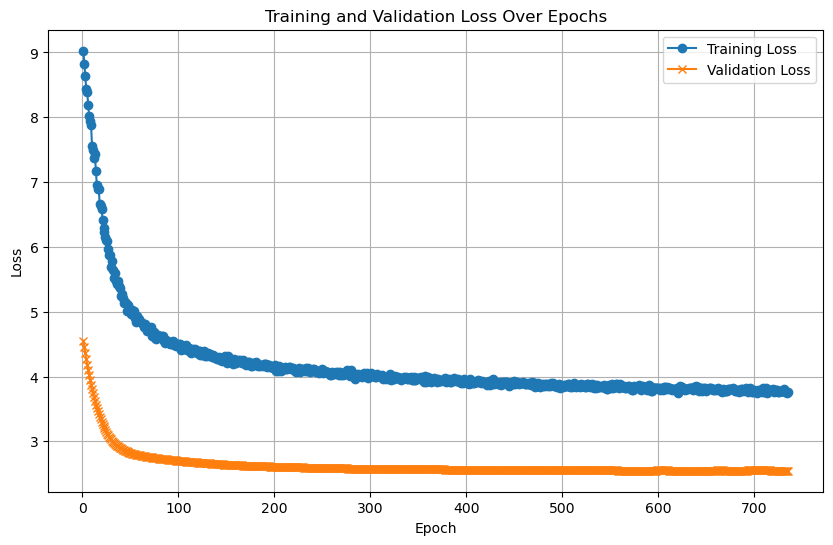

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/166], Loss: 5.5966
Test Batch [20/166], Loss: 5.1876
Test Batch [30/166], Loss: 5.0891
Test Batch [40/166], Loss: 5.2034
Test Batch [50/166], Loss: 5.2523
Test Batch [60/166], Loss: 5.1334
Test Batch [70/166], Loss: 5.1577
Test Batch [80/166], Loss: 5.1157
Test Batch [90/166], Loss: 5.2303
Test Batch [100/166], Loss: 5.1209
Test Batch [110/166], Loss: 4.7587
Test Batch [120/166], Loss: 4.7225
Test Batch [130/166], Loss: 4.7442
Test Batch [140/166], Loss: 4.6304
Test Batch [150/166], Loss: 5.4095


Test Batch [160/166], Loss: 5.6707

Test Loss: 5.0861


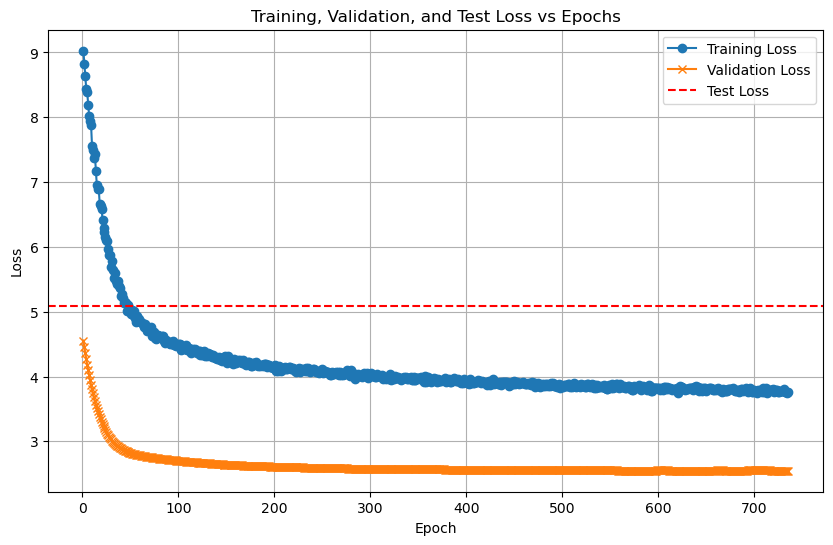

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/166 for test dataset.
  Processed batch 20/166 for test dataset.


  Processed batch 30/166 for test dataset.
  Processed batch 40/166 for test dataset.
  Processed batch 50/166 for test dataset.
  Processed batch 60/166 for test dataset.


  Processed batch 70/166 for test dataset.
  Processed batch 80/166 for test dataset.
  Processed batch 90/166 for test dataset.


  Processed batch 100/166 for test dataset.
  Processed batch 110/166 for test dataset.
  Processed batch 120/166 for test dataset.
  Processed batch 130/166 for test dataset.


  Processed batch 140/166 for test dataset.
  Processed batch 150/166 for test dataset.
  Processed batch 160/166 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 75.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.62      1.00      0.77         5
           2       0.50      0.40      0.44         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.40      0.57         5
           6       1.00      0.60      0.75         5
           7       0.57      0.80      0.67         5
           8       1.00      1.00      1.00         5

    accuracy                           0.76        45
   macro avg       0.80      0.76      0.75        45
weighted avg       0.80      0.76      0.75        45


LOG: Evaluating on the test set...
Test Accuracy: 75.41%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3175  |  Val Loss: 2.2866
Validation loss improved from inf to 2.2866.
[Epoch 2/1000] Train Loss: 2.2463  |  Val Loss: 2.2216
Validation loss improved from 2.2866 to 2.2216.
[Epoch 3/1000] Train Loss: 2.1824  |  Val Loss: 2.1671
Validation loss improved from 2.2216 to 2.1671.
[Epoch 4/1000] Train Loss: 2.1243  |  Val Loss: 2.1157
Validation loss improved from 2.1671 to 2.1157.
[Epoch 5/1000] Train Loss: 2.0728  |  Val Loss: 2.0691
Validation loss improved from 2.1157 to 2.0691.
[Epoch 6/1000] Train Loss: 2.0238  |  Val Loss: 2.0272
Validation loss improved from 2.0691 to 2.0272.
[Epoch 7/1000] Train Loss: 1.9777  |  Val Loss: 1.9879
Validation loss improved from 2.0272 to 1.9879.
[Epoch 8/1000] Train Loss: 1.9350  |  Val Loss: 1.9528
Validation loss improved from 1.9879 to 1.9528.
[Epoch 9/1000] Train Loss: 1.8967  |  Val Loss: 1.9175
Validation loss improved from 1.9528 to 1.9175.
[Epoch 10/1000] Train Loss: 1.8570  |  Val Loss: 1.8834
Validation loss impr

[Epoch 15/1000] Train Loss: 1.6881  |  Val Loss: 1.7409
Validation loss improved from 1.7682 to 1.7409.


[Epoch 16/1000] Train Loss: 1.6578  |  Val Loss: 1.7146
Validation loss improved from 1.7409 to 1.7146.
[Epoch 17/1000] Train Loss: 1.6288  |  Val Loss: 1.6893
Validation loss improved from 1.7146 to 1.6893.
[Epoch 18/1000] Train Loss: 1.5982  |  Val Loss: 1.6620
Validation loss improved from 1.6893 to 1.6620.
[Epoch 19/1000] Train Loss: 1.5686  |  Val Loss: 1.6334
Validation loss improved from 1.6620 to 1.6334.
[Epoch 20/1000] Train Loss: 1.5390  |  Val Loss: 1.6055
Validation loss improved from 1.6334 to 1.6055.
[Epoch 21/1000] Train Loss: 1.5095  |  Val Loss: 1.5771
Validation loss improved from 1.6055 to 1.5771.
[Epoch 22/1000] Train Loss: 1.4819  |  Val Loss: 1.5478
Validation loss improved from 1.5771 to 1.5478.
[Epoch 23/1000] Train Loss: 1.4539  |  Val Loss: 1.5190
Validation loss improved from 1.5478 to 1.5190.
[Epoch 24/1000] Train Loss: 1.4266  |  Val Loss: 1.4899
Validation loss improved from 1.5190 to 1.4899.
[Epoch 25/1000] Train Loss: 1.3991  |  Val Loss: 1.4634
Validati

[Epoch 34/1000] Train Loss: 1.1664  |  Val Loss: 1.2146
Validation loss improved from 1.2393 to 1.2146.
[Epoch 35/1000] Train Loss: 1.1427  |  Val Loss: 1.1903
Validation loss improved from 1.2146 to 1.1903.
[Epoch 36/1000] Train Loss: 1.1194  |  Val Loss: 1.1672
Validation loss improved from 1.1903 to 1.1672.
[Epoch 37/1000] Train Loss: 1.0976  |  Val Loss: 1.1443
Validation loss improved from 1.1672 to 1.1443.
[Epoch 38/1000] Train Loss: 1.0756  |  Val Loss: 1.1248
Validation loss improved from 1.1443 to 1.1248.
[Epoch 39/1000] Train Loss: 1.0547  |  Val Loss: 1.1058
Validation loss improved from 1.1248 to 1.1058.
[Epoch 40/1000] Train Loss: 1.0337  |  Val Loss: 1.0846
Validation loss improved from 1.1058 to 1.0846.
[Epoch 41/1000] Train Loss: 1.0135  |  Val Loss: 1.0648
Validation loss improved from 1.0846 to 1.0648.
[Epoch 42/1000] Train Loss: 0.9949  |  Val Loss: 1.0454
Validation loss improved from 1.0648 to 1.0454.
[Epoch 43/1000] Train Loss: 0.9758  |  Val Loss: 1.0286
Validati

[Epoch 50/1000] Train Loss: 0.8620  |  Val Loss: 0.9291
Validation loss improved from 0.9411 to 0.9291.
[Epoch 51/1000] Train Loss: 0.8480  |  Val Loss: 0.9184
Validation loss improved from 0.9291 to 0.9184.
[Epoch 52/1000] Train Loss: 0.8333  |  Val Loss: 0.9026
Validation loss improved from 0.9184 to 0.9026.
[Epoch 53/1000] Train Loss: 0.8184  |  Val Loss: 0.8881
Validation loss improved from 0.9026 to 0.8881.
[Epoch 54/1000] Train Loss: 0.8042  |  Val Loss: 0.8751
Validation loss improved from 0.8881 to 0.8751.
[Epoch 55/1000] Train Loss: 0.7912  |  Val Loss: 0.8640
Validation loss improved from 0.8751 to 0.8640.
[Epoch 56/1000] Train Loss: 0.7772  |  Val Loss: 0.8526
Validation loss improved from 0.8640 to 0.8526.
[Epoch 57/1000] Train Loss: 0.7647  |  Val Loss: 0.8419
Validation loss improved from 0.8526 to 0.8419.
[Epoch 58/1000] Train Loss: 0.7531  |  Val Loss: 0.8303
Validation loss improved from 0.8419 to 0.8303.
[Epoch 59/1000] Train Loss: 0.7411  |  Val Loss: 0.8210
Validati

[Epoch 65/1000] Train Loss: 0.6805  |  Val Loss: 0.7693
Validation loss improved from 0.7776 to 0.7693.
[Epoch 66/1000] Train Loss: 0.6713  |  Val Loss: 0.7624
Validation loss improved from 0.7693 to 0.7624.
[Epoch 67/1000] Train Loss: 0.6627  |  Val Loss: 0.7567
Validation loss improved from 0.7624 to 0.7567.
[Epoch 68/1000] Train Loss: 0.6551  |  Val Loss: 0.7512
Validation loss improved from 0.7567 to 0.7512.
[Epoch 69/1000] Train Loss: 0.6468  |  Val Loss: 0.7453
Validation loss improved from 0.7512 to 0.7453.
[Epoch 70/1000] Train Loss: 0.6395  |  Val Loss: 0.7381
Validation loss improved from 0.7453 to 0.7381.
[Epoch 71/1000] Train Loss: 0.6319  |  Val Loss: 0.7328
Validation loss improved from 0.7381 to 0.7328.
[Epoch 72/1000] Train Loss: 0.6256  |  Val Loss: 0.7276
Validation loss improved from 0.7328 to 0.7276.
[Epoch 73/1000] Train Loss: 0.6185  |  Val Loss: 0.7238
Validation loss improved from 0.7276 to 0.7238.
[Epoch 74/1000] Train Loss: 0.6128  |  Val Loss: 0.7188
Validati

[Epoch 83/1000] Train Loss: 0.5629  |  Val Loss: 0.6809
Validation loss improved from 0.6841 to 0.6809.
[Epoch 84/1000] Train Loss: 0.5586  |  Val Loss: 0.6781
Validation loss improved from 0.6809 to 0.6781.
[Epoch 85/1000] Train Loss: 0.5544  |  Val Loss: 0.6761
Validation loss improved from 0.6781 to 0.6761.
[Epoch 86/1000] Train Loss: 0.5496  |  Val Loss: 0.6719
Validation loss improved from 0.6761 to 0.6719.
[Epoch 87/1000] Train Loss: 0.5457  |  Val Loss: 0.6692
Validation loss improved from 0.6719 to 0.6692.
[Epoch 88/1000] Train Loss: 0.5429  |  Val Loss: 0.6663
Validation loss improved from 0.6692 to 0.6663.
[Epoch 89/1000] Train Loss: 0.5388  |  Val Loss: 0.6640
Validation loss improved from 0.6663 to 0.6640.
[Epoch 90/1000] Train Loss: 0.5349  |  Val Loss: 0.6616
Validation loss improved from 0.6640 to 0.6616.
[Epoch 91/1000] Train Loss: 0.5317  |  Val Loss: 0.6584
Validation loss improved from 0.6616 to 0.6584.
[Epoch 92/1000] Train Loss: 0.5280  |  Val Loss: 0.6568
Validati

[Epoch 99/1000] Train Loss: 0.5073  |  Val Loss: 0.6438
Validation loss improved from 0.6453 to 0.6438.
[Epoch 100/1000] Train Loss: 0.5049  |  Val Loss: 0.6429
Validation loss improved from 0.6438 to 0.6429.
[Epoch 101/1000] Train Loss: 0.5023  |  Val Loss: 0.6424
Validation loss improved from 0.6429 to 0.6424.
[Epoch 102/1000] Train Loss: 0.5006  |  Val Loss: 0.6408
Validation loss improved from 0.6424 to 0.6408.
[Epoch 103/1000] Train Loss: 0.4982  |  Val Loss: 0.6381
Validation loss improved from 0.6408 to 0.6381.
[Epoch 104/1000] Train Loss: 0.4952  |  Val Loss: 0.6379
Validation loss improved from 0.6381 to 0.6379.
[Epoch 105/1000] Train Loss: 0.4934  |  Val Loss: 0.6360
Validation loss improved from 0.6379 to 0.6360.
[Epoch 106/1000] Train Loss: 0.4908  |  Val Loss: 0.6340
Validation loss improved from 0.6360 to 0.6340.
[Epoch 107/1000] Train Loss: 0.4886  |  Val Loss: 0.6334
Validation loss improved from 0.6340 to 0.6334.
[Epoch 108/1000] Train Loss: 0.4864  |  Val Loss: 0.6322

[Epoch 117/1000] Train Loss: 0.4700  |  Val Loss: 0.6208
Validation loss improved from 0.6236 to 0.6208.
[Epoch 118/1000] Train Loss: 0.4678  |  Val Loss: 0.6208
Validation loss improved from 0.6208 to 0.6208.
[Epoch 119/1000] Train Loss: 0.4664  |  Val Loss: 0.6216
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 120/1000] Train Loss: 0.4639  |  Val Loss: 0.6198
Validation loss improved from 0.6208 to 0.6198.
[Epoch 121/1000] Train Loss: 0.4629  |  Val Loss: 0.6182
Validation loss improved from 0.6198 to 0.6182.
[Epoch 122/1000] Train Loss: 0.4618  |  Val Loss: 0.6171
Validation loss improved from 0.6182 to 0.6171.
[Epoch 123/1000] Train Loss: 0.4600  |  Val Loss: 0.6179
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 124/1000] Train Loss: 0.4583  |  Val Loss: 0.6170
Validation loss improved from 0.6171 to 0.6170.
[Epoch 125/1000] Train Loss: 0.4568  |  Val Loss: 0.6154
Validation loss improved from 0.6170 to 0.6154.
[Epoch 126/1000] Train Loss: 0.4556  |  Val

[Epoch 132/1000] Train Loss: 0.4473  |  Val Loss: 0.6090
Validation loss improved from 0.6113 to 0.6090.
[Epoch 133/1000] Train Loss: 0.4461  |  Val Loss: 0.6090
Validation loss improved from 0.6090 to 0.6090.
[Epoch 134/1000] Train Loss: 0.4450  |  Val Loss: 0.6084
Validation loss improved from 0.6090 to 0.6084.
[Epoch 135/1000] Train Loss: 0.4434  |  Val Loss: 0.6098
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 136/1000] Train Loss: 0.4426  |  Val Loss: 0.6095
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 137/1000] Train Loss: 0.4417  |  Val Loss: 0.6100
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 138/1000] Train Loss: 0.4399  |  Val Loss: 0.6081
Validation loss improved from 0.6084 to 0.6081.
[Epoch 139/1000] Train Loss: 0.4389  |  Val Loss: 0.6061
Validation loss improved from 0.6081 to 0.6061.
[Epoch 140/1000] Train Loss: 0.4378  |  Val Loss: 0.6068
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 141/1000] Train Loss: 0.

[Epoch 148/1000] Train Loss: 0.4298  |  Val Loss: 0.6011
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 149/1000] Train Loss: 0.4280  |  Val Loss: 0.6018
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 150/1000] Train Loss: 0.4271  |  Val Loss: 0.6007
Validation loss improved from 0.6007 to 0.6007.
[Epoch 151/1000] Train Loss: 0.4277  |  Val Loss: 0.6026
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 152/1000] Train Loss: 0.4253  |  Val Loss: 0.6010
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 153/1000] Train Loss: 0.4244  |  Val Loss: 0.5995
Validation loss improved from 0.6007 to 0.5995.
[Epoch 154/1000] Train Loss: 0.4241  |  Val Loss: 0.5986
Validation loss improved from 0.5995 to 0.5986.
[Epoch 155/1000] Train Loss: 0.4234  |  Val Loss: 0.6012
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 156/1000] Train Loss: 0.4220  |  Val Loss: 0.6010
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 157/1000] Tr

[Epoch 166/1000] Train Loss: 0.4130  |  Val Loss: 0.5963
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 167/1000] Train Loss: 0.4121  |  Val Loss: 0.5988
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 168/1000] Train Loss: 0.4117  |  Val Loss: 0.5983
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 169/1000] Train Loss: 0.4107  |  Val Loss: 0.5964
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 170/1000] Train Loss: 0.4098  |  Val Loss: 0.5943
Validation loss improved from 0.5959 to 0.5943.
[Epoch 171/1000] Train Loss: 0.4091  |  Val Loss: 0.5933
Validation loss improved from 0.5943 to 0.5933.
[Epoch 172/1000] Train Loss: 0.4083  |  Val Loss: 0.5932
Validation loss improved from 0.5933 to 0.5932.
[Epoch 173/1000] Train Loss: 0.4074  |  Val Loss: 0.5930
Validation loss improved from 0.5932 to 0.5930.
[Epoch 174/1000] Train Loss: 0.4068  |  Val Loss: 0.5936
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 175/1000] Train Lo

[Epoch 183/1000] Train Loss: 0.3999  |  Val Loss: 0.5914
Validation loss improved from 0.5917 to 0.5914.
[Epoch 184/1000] Train Loss: 0.3998  |  Val Loss: 0.5907
Validation loss improved from 0.5914 to 0.5907.
[Epoch 185/1000] Train Loss: 0.3998  |  Val Loss: 0.5895
Validation loss improved from 0.5907 to 0.5895.
[Epoch 186/1000] Train Loss: 0.3979  |  Val Loss: 0.5921
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 187/1000] Train Loss: 0.3975  |  Val Loss: 0.5936
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 188/1000] Train Loss: 0.3969  |  Val Loss: 0.5916
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 189/1000] Train Loss: 0.3958  |  Val Loss: 0.5914
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 190/1000] Train Loss: 0.3951  |  Val Loss: 0.5906
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 191/1000] Train Loss: 0.3953  |  Val Loss: 0.5898
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 192/1000] Tr

[Epoch 201/1000] Train Loss: 0.3883  |  Val Loss: 0.5858
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 202/1000] Train Loss: 0.3885  |  Val Loss: 0.5849
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 203/1000] Train Loss: 0.3874  |  Val Loss: 0.5849
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 204/1000] Train Loss: 0.3876  |  Val Loss: 0.5877
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 205/1000] Train Loss: 0.3858  |  Val Loss: 0.5859
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 206/1000] Train Loss: 0.3856  |  Val Loss: 0.5828
Validation loss improved from 0.5840 to 0.5828.
[Epoch 207/1000] Train Loss: 0.3845  |  Val Loss: 0.5846
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 208/1000] Train Loss: 0.3838  |  Val Loss: 0.5864
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 209/1000] Train Loss: 0.3835  |  Val Loss: 0.5857
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 217/1000] Train Loss: 0.3790  |  Val Loss: 0.5849
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 218/1000] Train Loss: 0.3787  |  Val Loss: 0.5875
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 219/1000] Train Loss: 0.3788  |  Val Loss: 0.5818
Validation loss improved from 0.5828 to 0.5818.
[Epoch 220/1000] Train Loss: 0.3768  |  Val Loss: 0.5811
Validation loss improved from 0.5818 to 0.5811.
[Epoch 221/1000] Train Loss: 0.3763  |  Val Loss: 0.5805
Validation loss improved from 0.5811 to 0.5805.
[Epoch 222/1000] Train Loss: 0.3763  |  Val Loss: 0.5842
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 223/1000] Train Loss: 0.3758  |  Val Loss: 0.5816
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 224/1000] Train Loss: 0.3748  |  Val Loss: 0.5828
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 225/1000] Train Loss: 0.3750  |  Val Loss: 0.5850
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 226/1000] 

[Epoch 233/1000] Train Loss: 0.3708  |  Val Loss: 0.5809
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 234/1000] Train Loss: 0.3699  |  Val Loss: 0.5808
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 235/1000] Train Loss: 0.3694  |  Val Loss: 0.5804
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 236/1000] Train Loss: 0.3688  |  Val Loss: 0.5813
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 237/1000] Train Loss: 0.3680  |  Val Loss: 0.5806
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 238/1000] Train Loss: 0.3672  |  Val Loss: 0.5785
Validation loss improved from 0.5790 to 0.5785.
[Epoch 239/1000] Train Loss: 0.3677  |  Val Loss: 0.5796
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 240/1000] Train Loss: 0.3669  |  Val Loss: 0.5781
Validation loss improved from 0.5785 to 0.5781.
[Epoch 241/1000] Train Loss: 0.3663  |  Val Loss: 0.5766
Validation loss improved from 0.5781 to 0.5766.
[Epoch 242/1000] Tr

[Epoch 250/1000] Train Loss: 0.3622  |  Val Loss: 0.5766
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 251/1000] Train Loss: 0.3614  |  Val Loss: 0.5770
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 252/1000] Train Loss: 0.3609  |  Val Loss: 0.5769
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 253/1000] Train Loss: 0.3605  |  Val Loss: 0.5767
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 254/1000] Train Loss: 0.3603  |  Val Loss: 0.5782
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 255/1000] Train Loss: 0.3601  |  Val Loss: 0.5822
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 256/1000] Train Loss: 0.3592  |  Val Loss: 0.5792
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 257/1000] Train Loss: 0.3590  |  Val Loss: 0.5764
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 258/1000] Train Loss: 0.3588  |  Val Loss: 0.5790
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 268/1000] Train Loss: 0.3546  |  Val Loss: 0.5776
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 269/1000] Train Loss: 0.3539  |  Val Loss: 0.5784
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 270/1000] Train Loss: 0.3536  |  Val Loss: 0.5755
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 271/1000] Train Loss: 0.3530  |  Val Loss: 0.5761
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 272/1000] Train Loss: 0.3529  |  Val Loss: 0.5782
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 273/1000] Train Loss: 0.3529  |  Val Loss: 0.5784
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 274/1000] Train Loss: 0.3520  |  Val Loss: 0.5764
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 275/1000] Train Loss: 0.3518  |  Val Loss: 0.5747
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 276/1000] Train Loss: 0.3514  |  Val Loss: 0.5754
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 285/1000] Train Loss: 0.3499  |  Val Loss: 0.5769
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 286/1000] Train Loss: 0.3476  |  Val Loss: 0.5752
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 287/1000] Train Loss: 0.3476  |  Val Loss: 0.5760
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 288/1000] Train Loss: 0.3477  |  Val Loss: 0.5764
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 289/1000] Train Loss: 0.3468  |  Val Loss: 0.5748
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 290/1000] Train Loss: 0.3464  |  Val Loss: 0.5786
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 291/1000] Train Loss: 0.3458  |  Val Loss: 0.5776
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 292/1000] Train Loss: 0.3459  |  Val Loss: 0.5770
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 293/1000] Train Loss: 0.3449  |  Val Loss: 0.5729
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 302/1000] Train Loss: 0.3421  |  Val Loss: 0.5740
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 303/1000] Train Loss: 0.3421  |  Val Loss: 0.5722
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 304/1000] Train Loss: 0.3421  |  Val Loss: 0.5748
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 305/1000] Train Loss: 0.3414  |  Val Loss: 0.5747
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 306/1000] Train Loss: 0.3408  |  Val Loss: 0.5753
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 307/1000] Train Loss: 0.3404  |  Val Loss: 0.5731
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 308/1000] Train Loss: 0.3400  |  Val Loss: 0.5707
Validation loss improved from 0.5721 to 0.5707.
[Epoch 309/1000] Train Loss: 0.3401  |  Val Loss: 0.5719
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 310/1000] Train Loss: 0.3397  |  Val Loss: 0.5745
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 318/1000] Train Loss: 0.3365  |  Val Loss: 0.5709
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 319/1000] Train Loss: 0.3366  |  Val Loss: 0.5703
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 320/1000] Train Loss: 0.3357  |  Val Loss: 0.5755
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 321/1000] Train Loss: 0.3360  |  Val Loss: 0.5768
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 322/1000] Train Loss: 0.3361  |  Val Loss: 0.5748
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 323/1000] Train Loss: 0.3348  |  Val Loss: 0.5715
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 324/1000] Train Loss: 0.3350  |  Val Loss: 0.5718
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 325/1000] Train Loss: 0.3360  |  Val Loss: 0.5708
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 326/1000] Train Loss: 0.3348  |  Val Loss: 0.5694
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 334/1000] Train Loss: 0.3336  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 335/1000] Train Loss: 0.3316  |  Val Loss: 0.5702
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 336/1000] Train Loss: 0.3316  |  Val Loss: 0.5717
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 337/1000] Train Loss: 0.3310  |  Val Loss: 0.5742
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 338/1000] Train Loss: 0.3322  |  Val Loss: 0.5773
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 339/1000] Train Loss: 0.3301  |  Val Loss: 0.5734
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 340/1000] Train Loss: 0.3313  |  Val Loss: 0.5679
Validation loss improved from 0.5685 to 0.5679.
[Epoch 341/1000] Train Loss: 0.3306  |  Val Loss: 0.5677
Validation loss improved from 0.5679 to 0.5677.
[Epoch 342/1000] Train Loss: 0.3296  |  Val Loss: 0.5726
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 343/10

[Epoch 352/1000] Train Loss: 0.3269  |  Val Loss: 0.5743
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 353/1000] Train Loss: 0.3263  |  Val Loss: 0.5736
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 354/1000] Train Loss: 0.3261  |  Val Loss: 0.5699
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 355/1000] Train Loss: 0.3260  |  Val Loss: 0.5699
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 356/1000] Train Loss: 0.3260  |  Val Loss: 0.5724
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 357/1000] Train Loss: 0.3252  |  Val Loss: 0.5709
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 358/1000] Train Loss: 0.3249  |  Val Loss: 0.5744
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 359/1000] Train Loss: 0.3243  |  Val Loss: 0.5750
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 360/1000] Train Loss: 0.3246  |  Val Loss: 0.5750
!! Validation loss did NOT improve !! Patience:

[Epoch 368/1000] Train Loss: 0.3231  |  Val Loss: 0.5670
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 369/1000] Train Loss: 0.3224  |  Val Loss: 0.5755
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 370/1000] Train Loss: 0.3218  |  Val Loss: 0.5781
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 371/1000] Train Loss: 0.3211  |  Val Loss: 0.5750
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 372/1000] Train Loss: 0.3212  |  Val Loss: 0.5706
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 373/1000] Train Loss: 0.3204  |  Val Loss: 0.5700
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 374/1000] Train Loss: 0.3208  |  Val Loss: 0.5719
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 375/1000] Train Loss: 0.3204  |  Val Loss: 0.5722
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 376/1000] Train Loss: 0.3198  |  Val Loss: 0.5745
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 384/1000] Train Loss: 0.3172  |  Val Loss: 0.5728
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 385/1000] Train Loss: 0.3177  |  Val Loss: 0.5731
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 386/1000] Train Loss: 0.3167  |  Val Loss: 0.5707
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 387/1000] Train Loss: 0.3171  |  Val Loss: 0.5673
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 388/1000] Train Loss: 0.3159  |  Val Loss: 0.5679
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 389/1000] Train Loss: 0.3164  |  Val Loss: 0.5722
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 390/1000] Train Loss: 0.3148  |  Val Loss: 0.5763
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 391/1000] Train Loss: 0.3173  |  Val Loss: 0.5811
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 392/1000] Train Loss: 0.3160  |  Val Loss: 0.5748
!! Validation loss did NOT improve !! Patience:

[Epoch 402/1000] Train Loss: 0.3124  |  Val Loss: 0.5749
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 403/1000] Train Loss: 0.3115  |  Val Loss: 0.5744
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 404/1000] Train Loss: 0.3114  |  Val Loss: 0.5726
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 405/1000] Train Loss: 0.3114  |  Val Loss: 0.5707
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 406/1000] Train Loss: 0.3119  |  Val Loss: 0.5788
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 407/1000] Train Loss: 0.3115  |  Val Loss: 0.5746
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 408/1000] Train Loss: 0.3101  |  Val Loss: 0.5755
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 409/1000] Train Loss: 0.3116  |  Val Loss: 0.5726
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 410/1000] Train Loss: 0.3100  |  Val Loss: 0.5724
!! Validation loss did NOT improve !! Patience:

[Epoch 419/1000] Train Loss: 0.3072  |  Val Loss: 0.5769
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 420/1000] Train Loss: 0.3074  |  Val Loss: 0.5736
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 421/1000] Train Loss: 0.3072  |  Val Loss: 0.5783
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 422/1000] Train Loss: 0.3069  |  Val Loss: 0.5750
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 423/1000] Train Loss: 0.3065  |  Val Loss: 0.5769
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 424/1000] Train Loss: 0.3057  |  Val Loss: 0.5758
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 425/1000] Train Loss: 0.3064  |  Val Loss: 0.5717
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 426/1000] Train Loss: 0.3050  |  Val Loss: 0.5741
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 427/1000] Train Loss: 0.3058  |  Val Loss: 0.5779
!! Validation loss did NOT improve !! Patience:

[Epoch 437/1000] Train Loss: 0.3028  |  Val Loss: 0.5771
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 438/1000] Train Loss: 0.3028  |  Val Loss: 0.5801
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 439/1000] Train Loss: 0.3032  |  Val Loss: 0.5790
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 440/1000] Train Loss: 0.3026  |  Val Loss: 0.5832
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 441/1000] Train Loss: 0.3018  |  Val Loss: 0.5807
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 442/1000] Train Loss: 0.3016  |  Val Loss: 0.5699
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 443/1000] Train Loss: 0.3021  |  Val Loss: 0.5695
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 444/1000] Train Loss: 0.3009  |  Val Loss: 0.5762
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 445/1000] Train Loss: 0.3014  |  Val Loss: 0.5859
!! Validation loss did NOT improve !! Patience:

[Epoch 453/1000] Train Loss: 0.2983  |  Val Loss: 0.5863
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 454/1000] Train Loss: 0.2989  |  Val Loss: 0.5805
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 455/1000] Train Loss: 0.2984  |  Val Loss: 0.5783
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 456/1000] Train Loss: 0.2976  |  Val Loss: 0.5757
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 457/1000] Train Loss: 0.2975  |  Val Loss: 0.5810
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 458/1000] Train Loss: 0.2976  |  Val Loss: 0.5834
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 459/1000] Train Loss: 0.2991  |  Val Loss: 0.5786
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 460/1000] Train Loss: 0.2969  |  Val Loss: 0.5797
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 461/1000] Train Loss: 0.2964  |  Val Loss: 0.5836
!! Validation loss did NOT improve !! Patience:

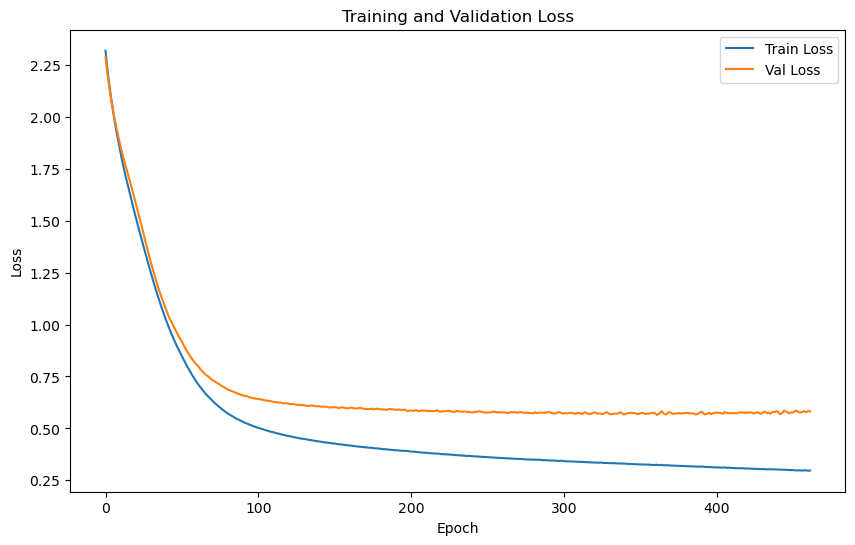

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.6179 | Test Accuracy: 74.55%


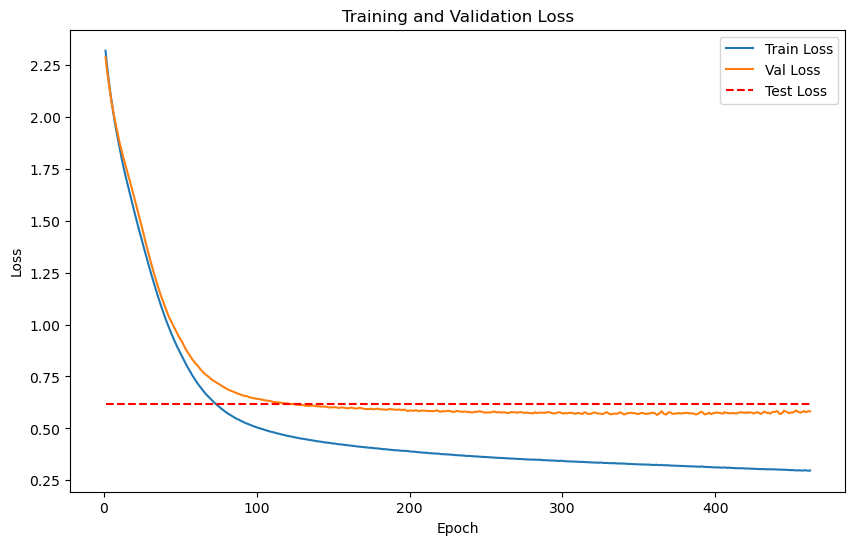

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42371, 64), 
Test labels shape: (42371,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4640


    Batch [2/2], Train Loss: 0.4544
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4699
Epoch [1/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.4699

Validation loss improved from inf to 0.4699. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4573


    Batch [2/2], Train Loss: 0.4508
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4656
Epoch [2/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4656

Validation loss improved from 0.4699 to 0.4656. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4588
    Batch [2/2], Train Loss: 0.4531
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4612
Epoch [3/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4612

Validation loss improved from 0.4656 to 0.4612. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.4611


    Batch [2/2], Train Loss: 0.4536
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4556
Epoch [4/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.4556

Validation loss improved from 0.4612 to 0.4556. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 0.4478


    Batch [2/2], Train Loss: 0.4530
LOG: Epoch [5/2000] - Validation


    Batch [1/1], Val Loss: 0.4497
Epoch [5/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4497

Validation loss improved from 0.4556 to 0.4497. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.4506
    Batch [2/2], Train Loss: 0.4448
LOG: Epoch [6/2000] - Validation


    Batch [1/1], Val Loss: 0.4459
Epoch [6/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4459

Validation loss improved from 0.4497 to 0.4459. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.4423
    Batch [2/2], Train Loss: 0.4514
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4431
Epoch [7/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4431

Validation loss improved from 0.4459 to 0.4431. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/2], Train Loss: 0.4500
    Batch [2/2], Train Loss: 0.4537
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4404
Epoch [8/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4404

Validation loss improved from 0.4431 to 0.4404. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/2], Train Loss: 0.4417


    Batch [2/2], Train Loss: 0.4477
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4382
Epoch [9/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4382

Validation loss improved from 0.4404 to 0.4382. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 0.4462
    Batch [2/2], Train Loss: 0.4428
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4367
Epoch [10/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.4367

Validation loss improved from 0.4382 to 0.4367. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 0.4396
    Batch [2/2], Train Loss: 0.4431
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4353
Epoch [11/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4353

Validation loss improved from 0.4367 to 0.4353. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 0.4474


    Batch [2/2], Train Loss: 0.4421
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4342
Epoch [12/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4342

Validation loss improved from 0.4353 to 0.4342. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.4431
    Batch [2/2], Train Loss: 0.4398
LOG: Epoch [13/2000] - Validation


    Batch [1/1], Val Loss: 0.4332
Epoch [13/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4332

Validation loss improved from 0.4342 to 0.4332. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 0.4388
    Batch [2/2], Train Loss: 0.4376
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4322
Epoch [14/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.4322

Validation loss improved from 0.4332 to 0.4322. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/2], Train Loss: 0.4376
    Batch [2/2], Train Loss: 0.4391
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4311
Epoch [15/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.4311

Validation loss improved from 0.4322 to 0.4311. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.4429


    Batch [2/2], Train Loss: 0.4366
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4300
Epoch [16/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4300

Validation loss improved from 0.4311 to 0.4300. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 0.4333
    Batch [2/2], Train Loss: 0.4309
LOG: Epoch [17/2000] - Validation


    Batch [1/1], Val Loss: 0.4290
Epoch [17/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.4290

Validation loss improved from 0.4300 to 0.4290. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.4350
    Batch [2/2], Train Loss: 0.4280
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4280
Epoch [18/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.4280

Validation loss improved from 0.4290 to 0.4280. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/2], Train Loss: 0.4293
    Batch [2/2], Train Loss: 0.4315
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4271
Epoch [19/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.4271

Validation loss improved from 0.4280 to 0.4271. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/2], Train Loss: 0.4307


    Batch [2/2], Train Loss: 0.4366
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4261
Epoch [20/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4261

Validation loss improved from 0.4271 to 0.4261. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 0.4285
    Batch [2/2], Train Loss: 0.4211
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4252
Epoch [21/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.4252

Validation loss improved from 0.4261 to 0.4252. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.4342
    Batch [2/2], Train Loss: 0.4345
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4244
Epoch [22/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.4244

Validation loss improved from 0.4252 to 0.4244. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.4278


    Batch [2/2], Train Loss: 0.4270
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4236
Epoch [23/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.4236

Validation loss improved from 0.4244 to 0.4236. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.4276
    Batch [2/2], Train Loss: 0.4265
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4227
Epoch [24/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.4227

Validation loss improved from 0.4236 to 0.4227. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.4267
    Batch [2/2], Train Loss: 0.4322
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4218
Epoch [25/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.4218

Validation loss improved from 0.4227 to 0.4218. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.4277


    Batch [2/2], Train Loss: 0.4262
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4209
Epoch [26/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.4209

Validation loss improved from 0.4218 to 0.4209. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.4247
    Batch [2/2], Train Loss: 0.4238
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4200
Epoch [27/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.4200

Validation loss improved from 0.4209 to 0.4200. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.4199
    Batch [2/2], Train Loss: 0.4247
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4192
Epoch [28/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.4192

Validation loss improved from 0.4200 to 0.4192. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.4199


    Batch [2/2], Train Loss: 0.4280
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4184
Epoch [29/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.4184

Validation loss improved from 0.4192 to 0.4184. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.4136
    Batch [2/2], Train Loss: 0.4191
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4176
Epoch [30/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.4176

Validation loss improved from 0.4184 to 0.4176. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.4238
    Batch [2/2], Train Loss: 0.4192
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4167
Epoch [31/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.4167

Validation loss improved from 0.4176 to 0.4167. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.4184


    Batch [2/2], Train Loss: 0.4172
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4161
Epoch [32/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.4161

Validation loss improved from 0.4167 to 0.4161. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.4208
    Batch [2/2], Train Loss: 0.4281
LOG: Epoch [33/2000] - Validation


    Batch [1/1], Val Loss: 0.4153
Epoch [33/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.4153

Validation loss improved from 0.4161 to 0.4153. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 0.4180
    Batch [2/2], Train Loss: 0.4236
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4145
Epoch [34/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.4145

Validation loss improved from 0.4153 to 0.4145. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.4187
    Batch [2/2], Train Loss: 0.4203
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.4139
Epoch [35/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.4139

Validation loss improved from 0.4145 to 0.4139. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.4171


    Batch [2/2], Train Loss: 0.4212
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4131
Epoch [36/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.4131

Validation loss improved from 0.4139 to 0.4131. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 0.4155
    Batch [2/2], Train Loss: 0.4110
LOG: Epoch [37/2000] - Validation


    Batch [1/1], Val Loss: 0.4124
Epoch [37/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.4124

Validation loss improved from 0.4131 to 0.4124. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.4120
    Batch [2/2], Train Loss: 0.4077
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4116
Epoch [38/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.4116

Validation loss improved from 0.4124 to 0.4116. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4109
    Batch [2/2], Train Loss: 0.4116
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.4109
Epoch [39/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.4109

Validation loss improved from 0.4116 to 0.4109. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 0.4153


    Batch [2/2], Train Loss: 0.4145
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4102
Epoch [40/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.4102

Validation loss improved from 0.4109 to 0.4102. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.4112
    Batch [2/2], Train Loss: 0.4122
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4096
Epoch [41/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.4096

Validation loss improved from 0.4102 to 0.4096. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.4098
    Batch [2/2], Train Loss: 0.4121
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.4091
Epoch [42/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.4091

Validation loss improved from 0.4096 to 0.4091. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 0.4150


    Batch [2/2], Train Loss: 0.4058
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.4086
Epoch [43/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.4086

Validation loss improved from 0.4091 to 0.4086. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 0.4096
    Batch [2/2], Train Loss: 0.4127
LOG: Epoch [44/2000] - Validation


    Batch [1/1], Val Loss: 0.4079
Epoch [44/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.4079

Validation loss improved from 0.4086 to 0.4079. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.4141
    Batch [2/2], Train Loss: 0.4015
LOG: Epoch [45/2000] - Validation


    Batch [1/1], Val Loss: 0.4072
Epoch [45/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.4072

Validation loss improved from 0.4079 to 0.4072. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 0.4091
    Batch [2/2], Train Loss: 0.4080
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.4066
Epoch [46/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.4066

Validation loss improved from 0.4072 to 0.4066. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.4059
    Batch [2/2], Train Loss: 0.4083
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.4060
Epoch [47/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.4060

Validation loss improved from 0.4066 to 0.4060. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.4091


    Batch [2/2], Train Loss: 0.4062
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.4054
Epoch [48/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.4054

Validation loss improved from 0.4060 to 0.4054. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.4046
    Batch [2/2], Train Loss: 0.4141
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.4048
Epoch [49/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.4048

Validation loss improved from 0.4054 to 0.4048. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.4065
    Batch [2/2], Train Loss: 0.4020
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.4044
Epoch [50/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.4044

Validation loss improved from 0.4048 to 0.4044. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 0.4048


    Batch [2/2], Train Loss: 0.4115
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.4037
Epoch [51/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.4037

Validation loss improved from 0.4044 to 0.4037. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.4040
    Batch [2/2], Train Loss: 0.4023
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [52/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.4032

Validation loss improved from 0.4037 to 0.4032. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.3938
    Batch [2/2], Train Loss: 0.3982
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.4027
Epoch [53/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.4027

Validation loss improved from 0.4032 to 0.4027. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.4039
    Batch [2/2], Train Loss: 0.3980
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.4020
Epoch [54/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.4020

Validation loss improved from 0.4027 to 0.4020. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.4033


    Batch [2/2], Train Loss: 0.4012
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.4014
Epoch [55/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.4014

Validation loss improved from 0.4020 to 0.4014. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.4010
    Batch [2/2], Train Loss: 0.3924
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.4010
Epoch [56/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.4010

Validation loss improved from 0.4014 to 0.4010. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.3921
    Batch [2/2], Train Loss: 0.3915
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.4006
Epoch [57/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.4006

Validation loss improved from 0.4010 to 0.4006. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.3934
    Batch [2/2], Train Loss: 0.3969
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.4002
Epoch [58/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.4002

Validation loss improved from 0.4006 to 0.4002. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.3947


    Batch [2/2], Train Loss: 0.4007
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3999
Epoch [59/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3999

Validation loss improved from 0.4002 to 0.3999. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 0.3921
    Batch [2/2], Train Loss: 0.3926
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3994
Epoch [60/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3994

Validation loss improved from 0.3999 to 0.3994. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.3933
    Batch [2/2], Train Loss: 0.3949
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3991
Epoch [61/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3991

Validation loss improved from 0.3994 to 0.3991. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.3997


    Batch [2/2], Train Loss: 0.3979
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3985
Epoch [62/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3985

Validation loss improved from 0.3991 to 0.3985. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.3973
    Batch [2/2], Train Loss: 0.3896
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3980
Epoch [63/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3980

Validation loss improved from 0.3985 to 0.3980. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.4013
    Batch [2/2], Train Loss: 0.3984
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3974
Epoch [64/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3974

Validation loss improved from 0.3980 to 0.3974. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.3904


    Batch [2/2], Train Loss: 0.3929
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3968
Epoch [65/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3968

Validation loss improved from 0.3974 to 0.3968. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.3892
    Batch [2/2], Train Loss: 0.3955
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3962
Epoch [66/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3962

Validation loss improved from 0.3968 to 0.3962. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3914
    Batch [2/2], Train Loss: 0.3882
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3955
Epoch [67/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3955

Validation loss improved from 0.3962 to 0.3955. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 0.3942


    Batch [2/2], Train Loss: 0.3897
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [68/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

Validation loss improved from 0.3955 to 0.3949. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.3952
    Batch [2/2], Train Loss: 0.3954
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3944
Epoch [69/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3944

Validation loss improved from 0.3949 to 0.3944. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.3949
    Batch [2/2], Train Loss: 0.3906
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3939
Epoch [70/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3939

Validation loss improved from 0.3944 to 0.3939. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.3927


    Batch [2/2], Train Loss: 0.3921
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3934
Epoch [71/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3934

Validation loss improved from 0.3939 to 0.3934. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.3895
    Batch [2/2], Train Loss: 0.3959
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3930
Epoch [72/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3930

Validation loss improved from 0.3934 to 0.3930. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/2], Train Loss: 0.3844
    Batch [2/2], Train Loss: 0.3936
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3926
Epoch [73/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3926

Validation loss improved from 0.3930 to 0.3926. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 0.3903


    Batch [2/2], Train Loss: 0.3865
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3922
Epoch [74/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3922

Validation loss improved from 0.3926 to 0.3922. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.3887
    Batch [2/2], Train Loss: 0.3923
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3919
Epoch [75/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3919

Validation loss improved from 0.3922 to 0.3919. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.3936
    Batch [2/2], Train Loss: 0.3919
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [76/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3914

Validation loss improved from 0.3919 to 0.3914. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.3954


    Batch [2/2], Train Loss: 0.3901
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3910
Epoch [77/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3910

Validation loss improved from 0.3914 to 0.3910. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 0.3858
    Batch [2/2], Train Loss: 0.3933
LOG: Epoch [78/2000] - Validation


    Batch [1/1], Val Loss: 0.3905
Epoch [78/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3905

Validation loss improved from 0.3910 to 0.3905. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3931
    Batch [2/2], Train Loss: 0.3777
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3901
Epoch [79/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.3901

Validation loss improved from 0.3905 to 0.3901. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3874
    Batch [2/2], Train Loss: 0.3910
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3897
Epoch [80/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3897

Validation loss improved from 0.3901 to 0.3897. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.3857


    Batch [2/2], Train Loss: 0.3950
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3894
Epoch [81/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3894

Validation loss improved from 0.3897 to 0.3894. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 0.3821
    Batch [2/2], Train Loss: 0.3904
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3892
Epoch [82/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.3892

Validation loss improved from 0.3894 to 0.3892. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.3828
    Batch [2/2], Train Loss: 0.3844
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3887
Epoch [83/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3887

Validation loss improved from 0.3892 to 0.3887. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3828
    Batch [2/2], Train Loss: 0.3805
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3884
Epoch [84/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.3884

Validation loss improved from 0.3887 to 0.3884. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3822


    Batch [2/2], Train Loss: 0.3826
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3882
Epoch [85/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3882

Validation loss improved from 0.3884 to 0.3882. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 0.3904
    Batch [2/2], Train Loss: 0.3750
LOG: Epoch [86/2000] - Validation


    Batch [1/1], Val Loss: 0.3879
Epoch [86/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3879

Validation loss improved from 0.3882 to 0.3879. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 0.3819
    Batch [2/2], Train Loss: 0.3864
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3876
Epoch [87/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.3876

Validation loss improved from 0.3879 to 0.3876. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.3883
    Batch [2/2], Train Loss: 0.3857
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3874
Epoch [88/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.3874

Validation loss improved from 0.3876 to 0.3874. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.3867


    Batch [2/2], Train Loss: 0.3838
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3870
Epoch [89/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3870

Validation loss improved from 0.3874 to 0.3870. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.3922
    Batch [2/2], Train Loss: 0.3847
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3866
Epoch [90/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3866

Validation loss improved from 0.3870 to 0.3866. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/2], Train Loss: 0.3822
    Batch [2/2], Train Loss: 0.3916
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [91/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.3860

Validation loss improved from 0.3866 to 0.3860. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.3732


    Batch [2/2], Train Loss: 0.3798
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [92/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.3856

Validation loss improved from 0.3860 to 0.3856. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.3843
    Batch [2/2], Train Loss: 0.3847
LOG: Epoch [93/2000] - Validation


    Batch [1/1], Val Loss: 0.3852
Epoch [93/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.3852

Validation loss improved from 0.3856 to 0.3852. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.3801
    Batch [2/2], Train Loss: 0.3821
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [94/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.3848

Validation loss improved from 0.3852 to 0.3848. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3695
    Batch [2/2], Train Loss: 0.3734
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3843
Epoch [95/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.3843

Validation loss improved from 0.3848 to 0.3843. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.3875


    Batch [2/2], Train Loss: 0.3717
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3839
Epoch [96/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.3839

Validation loss improved from 0.3843 to 0.3839. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.3842
    Batch [2/2], Train Loss: 0.3660
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3836
Epoch [97/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.3836

Validation loss improved from 0.3839 to 0.3836. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/2], Train Loss: 0.3706
    Batch [2/2], Train Loss: 0.3869
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3833
Epoch [98/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.3833

Validation loss improved from 0.3836 to 0.3833. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 0.3767


    Batch [2/2], Train Loss: 0.3798
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3830
Epoch [99/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.3830

Validation loss improved from 0.3833 to 0.3830. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.3754
    Batch [2/2], Train Loss: 0.3769
LOG: Epoch [100/2000] - Validation


    Batch [1/1], Val Loss: 0.3827
Epoch [100/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.3827

Validation loss improved from 0.3830 to 0.3827. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.3696
    Batch [2/2], Train Loss: 0.3788
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3825
Epoch [101/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3825

Validation loss improved from 0.3827 to 0.3825. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.3687
    Batch [2/2], Train Loss: 0.3717
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3822
Epoch [102/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3822

Validation loss improved from 0.3825 to 0.3822. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 0.3824


    Batch [2/2], Train Loss: 0.3764
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3820
Epoch [103/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.3820

Validation loss improved from 0.3822 to 0.3820. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.3726
    Batch [2/2], Train Loss: 0.3748
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3818
Epoch [104/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.3818

Validation loss improved from 0.3820 to 0.3818. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.3783
    Batch [2/2], Train Loss: 0.3782
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3816
Epoch [105/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.3816

Validation loss improved from 0.3818 to 0.3816. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 0.3748


    Batch [2/2], Train Loss: 0.3788
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3814
Epoch [106/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.3814

Validation loss improved from 0.3816 to 0.3814. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 0.3643
    Batch [2/2], Train Loss: 0.3814
LOG: Epoch [107/2000] - Validation


    Batch [1/1], Val Loss: 0.3810
Epoch [107/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.3810

Validation loss improved from 0.3814 to 0.3810. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 0.3712
    Batch [2/2], Train Loss: 0.3651
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3806
Epoch [108/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.3806

Validation loss improved from 0.3810 to 0.3806. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.3721
    Batch [2/2], Train Loss: 0.3704
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3803
Epoch [109/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.3803

Validation loss improved from 0.3806 to 0.3803. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.3676
    Batch [2/2], Train Loss: 0.3721
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3801
Epoch [110/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3801

Validation loss improved from 0.3803 to 0.3801. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 0.3737


    Batch [2/2], Train Loss: 0.3677
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3799
Epoch [111/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.3799

Validation loss improved from 0.3801 to 0.3799. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.3745
    Batch [2/2], Train Loss: 0.3715
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3797
Epoch [112/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3797

Validation loss improved from 0.3799 to 0.3797. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.3767
    Batch [2/2], Train Loss: 0.3684
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3792
Epoch [113/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.3792

Validation loss improved from 0.3797 to 0.3792. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.3676


    Batch [2/2], Train Loss: 0.3721
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3790
Epoch [114/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3790

Validation loss improved from 0.3792 to 0.3790. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 0.3642
    Batch [2/2], Train Loss: 0.3751
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [115/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3785

Validation loss improved from 0.3790 to 0.3785. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.3694
    Batch [2/2], Train Loss: 0.3618
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [116/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.3780

Validation loss improved from 0.3785 to 0.3780. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 0.3680


    Batch [2/2], Train Loss: 0.3580
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3776
Epoch [117/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3776

Validation loss improved from 0.3780 to 0.3776. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.3636
    Batch [2/2], Train Loss: 0.3738
LOG: Epoch [118/2000] - Validation


    Batch [1/1], Val Loss: 0.3772
Epoch [118/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3772

Validation loss improved from 0.3776 to 0.3772. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 0.3652
    Batch [2/2], Train Loss: 0.3756
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [119/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3768

Validation loss improved from 0.3772 to 0.3768. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.3729
    Batch [2/2], Train Loss: 0.3747
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3763
Epoch [120/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3763

Validation loss improved from 0.3768 to 0.3763. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.3657


    Batch [2/2], Train Loss: 0.3672
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3761
Epoch [121/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.3761

Validation loss improved from 0.3763 to 0.3761. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 0.3631
    Batch [2/2], Train Loss: 0.3696
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3758
Epoch [122/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.3758

Validation loss improved from 0.3761 to 0.3758. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.3672
    Batch [2/2], Train Loss: 0.3667
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [123/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.3755

Validation loss improved from 0.3758 to 0.3755. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.3726


    Batch [2/2], Train Loss: 0.3641
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3752
Epoch [124/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3752

Validation loss improved from 0.3755 to 0.3752. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.3693
    Batch [2/2], Train Loss: 0.3698
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [125/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3750

Validation loss improved from 0.3752 to 0.3750. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.3569
    Batch [2/2], Train Loss: 0.3729
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3748
Epoch [126/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.3748

Validation loss improved from 0.3750 to 0.3748. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.3563


    Batch [2/2], Train Loss: 0.3576
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [127/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.3747

Validation loss improved from 0.3748 to 0.3747. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.3655
    Batch [2/2], Train Loss: 0.3571
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3746
Epoch [128/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3746

Validation loss improved from 0.3747 to 0.3746. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.3576
    Batch [2/2], Train Loss: 0.3627
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3743
Epoch [129/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.3743

Validation loss improved from 0.3746 to 0.3743. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 0.3585


    Batch [2/2], Train Loss: 0.3632
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3741
Epoch [130/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.3741

Validation loss improved from 0.3743 to 0.3741. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.3659
    Batch [2/2], Train Loss: 0.3646
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [131/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.3738

Validation loss improved from 0.3741 to 0.3738. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.3636
    Batch [2/2], Train Loss: 0.3667
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [132/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3735

Validation loss improved from 0.3738 to 0.3735. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 0.3606


    Batch [2/2], Train Loss: 0.3691
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [133/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3731

Validation loss improved from 0.3735 to 0.3731. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 0.3650
    Batch [2/2], Train Loss: 0.3664
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.3727
Epoch [134/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3727

Validation loss improved from 0.3731 to 0.3727. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.3623
    Batch [2/2], Train Loss: 0.3494
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3724
Epoch [135/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3724

Validation loss improved from 0.3727 to 0.3724. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.3578
    Batch [2/2], Train Loss: 0.3627
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3724
Epoch [136/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.3724

Validation loss improved from 0.3724 to 0.3724. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 0.3583


    Batch [2/2], Train Loss: 0.3623
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3721
Epoch [137/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.3721

Validation loss improved from 0.3724 to 0.3721. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.3574
    Batch [2/2], Train Loss: 0.3593
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3719
Epoch [138/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.3719

Validation loss improved from 0.3721 to 0.3719. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.3588
    Batch [2/2], Train Loss: 0.3612
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3716
Epoch [139/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3716

Validation loss improved from 0.3719 to 0.3716. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.3619


    Batch [2/2], Train Loss: 0.3587
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3713
Epoch [140/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.3713

Validation loss improved from 0.3716 to 0.3713. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 0.3638
    Batch [2/2], Train Loss: 0.3503
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3711
Epoch [141/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.3711

Validation loss improved from 0.3713 to 0.3711. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3557
    Batch [2/2], Train Loss: 0.3686
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3707
Epoch [142/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.3707

Validation loss improved from 0.3711 to 0.3707. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.3646


    Batch [2/2], Train Loss: 0.3641
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [143/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3704

Validation loss improved from 0.3707 to 0.3704. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 0.3424


    Batch [2/2], Train Loss: 0.3578
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3700
Epoch [144/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3700

Validation loss improved from 0.3704 to 0.3700. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 0.3573
    Batch [2/2], Train Loss: 0.3578
LOG: Epoch [145/2000] - Validation


    Batch [1/1], Val Loss: 0.3698
Epoch [145/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3698

Validation loss improved from 0.3700 to 0.3698. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.3560
    Batch [2/2], Train Loss: 0.3539
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3694
Epoch [146/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3694

Validation loss improved from 0.3698 to 0.3694. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.3563
    Batch [2/2], Train Loss: 0.3599
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3692
Epoch [147/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.3692

Validation loss improved from 0.3694 to 0.3692. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 0.3530


    Batch [2/2], Train Loss: 0.3549
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3688
Epoch [148/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.3688

Validation loss improved from 0.3692 to 0.3688. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.3576
    Batch [2/2], Train Loss: 0.3531
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3685
Epoch [149/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.3685

Validation loss improved from 0.3688 to 0.3685. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 0.3483
    Batch [2/2], Train Loss: 0.3513
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3685
Epoch [150/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.3685

Validation loss improved from 0.3685 to 0.3685. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 0.3647


    Batch [2/2], Train Loss: 0.3489
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3684
Epoch [151/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3684

Validation loss improved from 0.3685 to 0.3684. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.3588
    Batch [2/2], Train Loss: 0.3468
LOG: Epoch [152/2000] - Validation


    Batch [1/1], Val Loss: 0.3682
Epoch [152/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3682

Validation loss improved from 0.3684 to 0.3682. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 0.3480
    Batch [2/2], Train Loss: 0.3538
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [153/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.3681

Validation loss improved from 0.3682 to 0.3681. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.3435
    Batch [2/2], Train Loss: 0.3584
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [154/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.3678

Validation loss improved from 0.3681 to 0.3678. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.3476


    Batch [2/2], Train Loss: 0.3561
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [155/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.3677

Validation loss improved from 0.3678 to 0.3677. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 0.3562
    Batch [2/2], Train Loss: 0.3566
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3676
Epoch [156/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.3676

Validation loss improved from 0.3677 to 0.3676. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.3428
    Batch [2/2], Train Loss: 0.3626
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3672
Epoch [157/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.3672

Validation loss improved from 0.3676 to 0.3672. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.3450


    Batch [2/2], Train Loss: 0.3577
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3668
Epoch [158/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.3668

Validation loss improved from 0.3672 to 0.3668. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.3616
    Batch [2/2], Train Loss: 0.3449
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3665
Epoch [159/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.3665

Validation loss improved from 0.3668 to 0.3665. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.3536
    Batch [2/2], Train Loss: 0.3523
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [160/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3663

Validation loss improved from 0.3665 to 0.3663. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.3558


    Batch [2/2], Train Loss: 0.3531
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [161/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.3660

Validation loss improved from 0.3663 to 0.3660. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.3362
    Batch [2/2], Train Loss: 0.3550
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [162/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3659

Validation loss improved from 0.3660 to 0.3659. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.3471
    Batch [2/2], Train Loss: 0.3515
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [163/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.3659

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 0.3613


    Batch [2/2], Train Loss: 0.3539
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [164/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.3426
    Batch [2/2], Train Loss: 0.3559
LOG: Epoch [165/2000] - Validation


    Batch [1/1], Val Loss: 0.3660
Epoch [165/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.3492
    Batch [2/2], Train Loss: 0.3478
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3661
Epoch [166/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.3661

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.3474
    Batch [2/2], Train Loss: 0.3419
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [167/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 0.3442


    Batch [2/2], Train Loss: 0.3456
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [168/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.3656

Validation loss improved from 0.3659 to 0.3656. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.3438
    Batch [2/2], Train Loss: 0.3556
LOG: Epoch [169/2000] - Validation


    Batch [1/1], Val Loss: 0.3657
Epoch [169/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.3657

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 0.3389
    Batch [2/2], Train Loss: 0.3478
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3657
Epoch [170/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.3657

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.3450
    Batch [2/2], Train Loss: 0.3572
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3653
Epoch [171/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3653

Validation loss improved from 0.3656 to 0.3653. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 0.3460


    Batch [2/2], Train Loss: 0.3480
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3648
Epoch [172/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.3648

Validation loss improved from 0.3653 to 0.3648. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 0.3509
    Batch [2/2], Train Loss: 0.3455
LOG: Epoch [173/2000] - Validation


    Batch [1/1], Val Loss: 0.3644
Epoch [173/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.3644

Validation loss improved from 0.3648 to 0.3644. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.3448
    Batch [2/2], Train Loss: 0.3354
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3640
Epoch [174/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.3640

Validation loss improved from 0.3644 to 0.3640. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.3549
    Batch [2/2], Train Loss: 0.3431
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3639
Epoch [175/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3639

Validation loss improved from 0.3640 to 0.3639. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.3453


    Batch [2/2], Train Loss: 0.3439
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3638
Epoch [176/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.3638

Validation loss improved from 0.3639 to 0.3638. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 0.3320


    Batch [2/2], Train Loss: 0.3395
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3634
Epoch [177/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.3634

Validation loss improved from 0.3638 to 0.3634. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.3337
    Batch [2/2], Train Loss: 0.3261
LOG: Epoch [178/2000] - Validation


    Batch [1/1], Val Loss: 0.3634
Epoch [178/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.3634

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.3458
    Batch [2/2], Train Loss: 0.3350
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3636
Epoch [179/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3636

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [180/2000] - Training


    Batch [1/2], Train Loss: 0.3372
    Batch [2/2], Train Loss: 0.3502
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3634
Epoch [180/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3634

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.3391


    Batch [2/2], Train Loss: 0.3457
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3633
Epoch [181/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.3633

Validation loss improved from 0.3634 to 0.3633. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.3338
    Batch [2/2], Train Loss: 0.3477
LOG: Epoch [182/2000] - Validation


    Batch [1/1], Val Loss: 0.3631
Epoch [182/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3631

Validation loss improved from 0.3633 to 0.3631. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 0.3430
    Batch [2/2], Train Loss: 0.3490
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [183/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.3631

Validation loss improved from 0.3631 to 0.3631. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 0.3337
    Batch [2/2], Train Loss: 0.3419
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3628
Epoch [184/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3628

Validation loss improved from 0.3631 to 0.3628. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.3424


    Batch [2/2], Train Loss: 0.3385
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3625
Epoch [185/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.3625

Validation loss improved from 0.3628 to 0.3625. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.3375
    Batch [2/2], Train Loss: 0.3385
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3618
Epoch [186/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.3618

Validation loss improved from 0.3625 to 0.3618. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.3293
    Batch [2/2], Train Loss: 0.3391
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3617
Epoch [187/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.3617

Validation loss improved from 0.3618 to 0.3617. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.3360


    Batch [2/2], Train Loss: 0.3434
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [188/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3615

Validation loss improved from 0.3617 to 0.3615. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.3326
    Batch [2/2], Train Loss: 0.3310
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3611
Epoch [189/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.3611

Validation loss improved from 0.3615 to 0.3611. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.3345
    Batch [2/2], Train Loss: 0.3326
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [190/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.3610

Validation loss improved from 0.3611 to 0.3610. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 0.3278


    Batch [2/2], Train Loss: 0.3250
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [191/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.3607

Validation loss improved from 0.3610 to 0.3607. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.3258
    Batch [2/2], Train Loss: 0.3241
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [192/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.3606

Validation loss improved from 0.3607 to 0.3606. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.3269
    Batch [2/2], Train Loss: 0.3336
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [193/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.3602

Validation loss improved from 0.3606 to 0.3602. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.3451


    Batch [2/2], Train Loss: 0.3301
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [194/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.3601

Validation loss improved from 0.3602 to 0.3601. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 0.3376
    Batch [2/2], Train Loss: 0.3310
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.3599
Epoch [195/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.3599

Validation loss improved from 0.3601 to 0.3599. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 0.3363
    Batch [2/2], Train Loss: 0.3365
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3596
Epoch [196/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.3596

Validation loss improved from 0.3599 to 0.3596. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.3358
    Batch [2/2], Train Loss: 0.3323
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3595
Epoch [197/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.3595

Validation loss improved from 0.3596 to 0.3595. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 0.3117


    Batch [2/2], Train Loss: 0.3370
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3591
Epoch [198/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.3591

Validation loss improved from 0.3595 to 0.3591. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 0.3397
    Batch [2/2], Train Loss: 0.3481
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.3591
Epoch [199/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.3591

Validation loss improved from 0.3591 to 0.3591. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.3276
    Batch [2/2], Train Loss: 0.3413
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3588
Epoch [200/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3588

Validation loss improved from 0.3591 to 0.3588. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.3345
    Batch [2/2], Train Loss: 0.3370
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3589
Epoch [201/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.3589

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 0.3334


    Batch [2/2], Train Loss: 0.3348
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3586
Epoch [202/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.3586

Validation loss improved from 0.3588 to 0.3586. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.3356
    Batch [2/2], Train Loss: 0.3290
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3587
Epoch [203/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.3587

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.3338
    Batch [2/2], Train Loss: 0.3306
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3587
Epoch [204/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.3587

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.3250


    Batch [2/2], Train Loss: 0.3393
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3587
Epoch [205/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.3587

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.3302
    Batch [2/2], Train Loss: 0.3377
LOG: Epoch [206/2000] - Validation


    Batch [1/1], Val Loss: 0.3587
Epoch [206/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.3587

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 0.3140
    Batch [2/2], Train Loss: 0.3321
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3587
Epoch [207/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.3587

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.3277
    Batch [2/2], Train Loss: 0.3222
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3587
Epoch [208/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.3587

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.3301


    Batch [2/2], Train Loss: 0.3398
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [209/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3584

Validation loss improved from 0.3586 to 0.3584. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 0.3273
    Batch [2/2], Train Loss: 0.3252
LOG: Epoch [210/2000] - Validation


    Batch [1/1], Val Loss: 0.3583
Epoch [210/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.3583

Validation loss improved from 0.3584 to 0.3583. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.3282
    Batch [2/2], Train Loss: 0.3288
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3582
Epoch [211/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.3582

Validation loss improved from 0.3583 to 0.3582. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.3217
    Batch [2/2], Train Loss: 0.3279
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [212/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.3579

Validation loss improved from 0.3582 to 0.3579. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.3117


    Batch [2/2], Train Loss: 0.3337
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [213/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.3573

Validation loss improved from 0.3579 to 0.3573. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 0.3264


    Batch [2/2], Train Loss: 0.3281
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3570
Epoch [214/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.3570

Validation loss improved from 0.3573 to 0.3570. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.3176
    Batch [2/2], Train Loss: 0.3189
LOG: Epoch [215/2000] - Validation


    Batch [1/1], Val Loss: 0.3568
Epoch [215/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.3568

Validation loss improved from 0.3570 to 0.3568. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.3195
    Batch [2/2], Train Loss: 0.3224
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [216/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.3565

Validation loss improved from 0.3568 to 0.3565. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.3295
    Batch [2/2], Train Loss: 0.3348
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3564
Epoch [217/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.3564

Validation loss improved from 0.3565 to 0.3564. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 0.3202


    Batch [2/2], Train Loss: 0.3216
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [218/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.3560

Validation loss improved from 0.3564 to 0.3560. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.3287
    Batch [2/2], Train Loss: 0.3134
LOG: Epoch [219/2000] - Validation


    Batch [1/1], Val Loss: 0.3558
Epoch [219/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.3558

Validation loss improved from 0.3560 to 0.3558. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.3321
    Batch [2/2], Train Loss: 0.3294
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [220/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.3555

Validation loss improved from 0.3558 to 0.3555. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.3308
    Batch [2/2], Train Loss: 0.3235
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [221/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.3261


    Batch [2/2], Train Loss: 0.3283
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [222/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.3554

Validation loss improved from 0.3555 to 0.3554. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.3277
    Batch [2/2], Train Loss: 0.3133
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.3549
Epoch [223/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.3549

Validation loss improved from 0.3554 to 0.3549. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.3243
    Batch [2/2], Train Loss: 0.3292
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [224/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.3247
    Batch [2/2], Train Loss: 0.3240
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [225/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.3549

Validation loss improved from 0.3549 to 0.3549. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.3180


    Batch [2/2], Train Loss: 0.3200
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3551
Epoch [226/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.3551

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.3242
    Batch [2/2], Train Loss: 0.3126
LOG: Epoch [227/2000] - Validation


    Batch [1/1], Val Loss: 0.3548
Epoch [227/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.3548

Validation loss improved from 0.3549 to 0.3548. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 0.3222
    Batch [2/2], Train Loss: 0.3181
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [228/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.3545

Validation loss improved from 0.3548 to 0.3545. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.3195
    Batch [2/2], Train Loss: 0.3213
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [229/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.3540

Validation loss improved from 0.3545 to 0.3540. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.3235


    Batch [2/2], Train Loss: 0.3130
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3536
Epoch [230/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.3536

Validation loss improved from 0.3540 to 0.3536. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.3261
    Batch [2/2], Train Loss: 0.3152
LOG: Epoch [231/2000] - Validation


    Batch [1/1], Val Loss: 0.3536
Epoch [231/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.3536

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.3156
    Batch [2/2], Train Loss: 0.3219
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3536
Epoch [232/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.3536

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.3196
    Batch [2/2], Train Loss: 0.3205
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3538
Epoch [233/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.3538

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.3126


    Batch [2/2], Train Loss: 0.3116
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3533
Epoch [234/2000], Avg Train Loss: 0.3121, Avg Val Loss: 0.3533

Validation loss improved from 0.3536 to 0.3533. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 0.3171
    Batch [2/2], Train Loss: 0.3149
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3531
Epoch [235/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.3531

Validation loss improved from 0.3533 to 0.3531. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.3210
    Batch [2/2], Train Loss: 0.3078
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3530
Epoch [236/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.3530

Validation loss improved from 0.3531 to 0.3530. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.3075


    Batch [2/2], Train Loss: 0.3103
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3531
Epoch [237/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.3531

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 0.3161
    Batch [2/2], Train Loss: 0.3086
LOG: Epoch [238/2000] - Validation


    Batch [1/1], Val Loss: 0.3532
Epoch [238/2000], Avg Train Loss: 0.3123, Avg Val Loss: 0.3532

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.3186
    Batch [2/2], Train Loss: 0.3212
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [239/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.3532

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.3094
    Batch [2/2], Train Loss: 0.3232
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3531
Epoch [240/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.3531

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.3209


    Batch [2/2], Train Loss: 0.3228
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3530
Epoch [241/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.3530

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.3129
    Batch [2/2], Train Loss: 0.3126
LOG: Epoch [242/2000] - Validation


    Batch [1/1], Val Loss: 0.3526
Epoch [242/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.3526

Validation loss improved from 0.3530 to 0.3526. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.3156
    Batch [2/2], Train Loss: 0.3047
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [243/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.3521

Validation loss improved from 0.3526 to 0.3521. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.3059
    Batch [2/2], Train Loss: 0.3156
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [244/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.3521

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.3050
    Batch [2/2], Train Loss: 0.3132
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3516
Epoch [245/2000], Avg Train Loss: 0.3091, Avg Val Loss: 0.3516

Validation loss improved from 0.3521 to 0.3516. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.3103


    Batch [2/2], Train Loss: 0.3170
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [246/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.3515

Validation loss improved from 0.3516 to 0.3515. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 0.3173
    Batch [2/2], Train Loss: 0.3100
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3514
Epoch [247/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.3514

Validation loss improved from 0.3515 to 0.3514. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.3103
    Batch [2/2], Train Loss: 0.3050
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [248/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.3510

Validation loss improved from 0.3514 to 0.3510. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 0.2964


    Batch [2/2], Train Loss: 0.3156
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [249/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.3508

Validation loss improved from 0.3510 to 0.3508. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 0.3260
    Batch [2/2], Train Loss: 0.3022
LOG: Epoch [250/2000] - Validation


    Batch [1/1], Val Loss: 0.3509
Epoch [250/2000], Avg Train Loss: 0.3141, Avg Val Loss: 0.3509

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.2993
    Batch [2/2], Train Loss: 0.3039
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [251/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.3079
    Batch [2/2], Train Loss: 0.3080
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [252/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.3508

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 0.3129


    Batch [2/2], Train Loss: 0.3230
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [253/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.3508

Validation loss improved from 0.3508 to 0.3508. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.3079
    Batch [2/2], Train Loss: 0.3031
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.3506
Epoch [254/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3506

Validation loss improved from 0.3508 to 0.3506. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.3059
    Batch [2/2], Train Loss: 0.3108
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3506
Epoch [255/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.3506

Validation loss improved from 0.3506 to 0.3506. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.3036
    Batch [2/2], Train Loss: 0.3095
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3503
Epoch [256/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.3503

Validation loss improved from 0.3506 to 0.3503. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.2990


    Batch [2/2], Train Loss: 0.3105
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3503
Epoch [257/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.3503

Validation loss improved from 0.3503 to 0.3503. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.3139


    Batch [2/2], Train Loss: 0.3105
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3500
Epoch [258/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.3500

Validation loss improved from 0.3503 to 0.3500. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.3004
    Batch [2/2], Train Loss: 0.3021
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3497
Epoch [259/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3497

Validation loss improved from 0.3500 to 0.3497. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.3094
    Batch [2/2], Train Loss: 0.3097
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3499
Epoch [260/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.3499

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.3050


    Batch [2/2], Train Loss: 0.3155
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3503
Epoch [261/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.3503

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 0.3109
    Batch [2/2], Train Loss: 0.3077
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3501
Epoch [262/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.3501

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.2956
    Batch [2/2], Train Loss: 0.3004
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3500
Epoch [263/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.3500

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 0.3073


    Batch [2/2], Train Loss: 0.3019
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3502
Epoch [264/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.3502

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.3008
    Batch [2/2], Train Loss: 0.3144
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3502
Epoch [265/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.3502

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.3231
    Batch [2/2], Train Loss: 0.3008
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3501
Epoch [266/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.3501

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 0.3067


    Batch [2/2], Train Loss: 0.3090
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3500
Epoch [267/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.3500

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.2876


    Batch [2/2], Train Loss: 0.2938
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [268/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3496

Validation loss improved from 0.3497 to 0.3496. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.3056
    Batch [2/2], Train Loss: 0.3006
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.3497
Epoch [269/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.3497

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 0.3175
    Batch [2/2], Train Loss: 0.3079
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3492
Epoch [270/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.3492

Validation loss improved from 0.3496 to 0.3492. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.3125
    Batch [2/2], Train Loss: 0.3040
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [271/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.3485

Validation loss improved from 0.3492 to 0.3485. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 0.3113


    Batch [2/2], Train Loss: 0.3230
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3480
Epoch [272/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.3480

Validation loss improved from 0.3485 to 0.3480. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.3139


    Batch [2/2], Train Loss: 0.2888
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3476
Epoch [273/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.3476

Validation loss improved from 0.3480 to 0.3476. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 0.2945


    Batch [2/2], Train Loss: 0.2988
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [274/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.3474

Validation loss improved from 0.3476 to 0.3474. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 0.2940


    Batch [2/2], Train Loss: 0.2886
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3470
Epoch [275/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.3470

Validation loss improved from 0.3474 to 0.3470. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.2962
    Batch [2/2], Train Loss: 0.2975
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3469
Epoch [276/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.3469

Validation loss improved from 0.3470 to 0.3469. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/2], Train Loss: 0.3019
    Batch [2/2], Train Loss: 0.2999
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3470
Epoch [277/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.3470

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.2986


    Batch [2/2], Train Loss: 0.2953
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3471
Epoch [278/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.3471

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 0.3004
    Batch [2/2], Train Loss: 0.2969
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3470
Epoch [279/2000], Avg Train Loss: 0.2987, Avg Val Loss: 0.3470

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.3098
    Batch [2/2], Train Loss: 0.3063
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3468
Epoch [280/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.3468

Validation loss improved from 0.3469 to 0.3468. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.3073
    Batch [2/2], Train Loss: 0.3059
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3469
Epoch [281/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.3469

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 0.2912


    Batch [2/2], Train Loss: 0.3115
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [282/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3466

Validation loss improved from 0.3468 to 0.3466. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 0.3100
    Batch [2/2], Train Loss: 0.3067
LOG: Epoch [283/2000] - Validation


    Batch [1/1], Val Loss: 0.3464
Epoch [283/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.3464

Validation loss improved from 0.3466 to 0.3464. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.2953
    Batch [2/2], Train Loss: 0.3013
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3459
Epoch [284/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.3459

Validation loss improved from 0.3464 to 0.3459. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.3078
    Batch [2/2], Train Loss: 0.3048
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3459
Epoch [285/2000], Avg Train Loss: 0.3063, Avg Val Loss: 0.3459

Validation loss improved from 0.3459 to 0.3459. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.3037


    Batch [2/2], Train Loss: 0.2962
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [286/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.3457

Validation loss improved from 0.3459 to 0.3457. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.2853
    Batch [2/2], Train Loss: 0.3028
LOG: Epoch [287/2000] - Validation


    Batch [1/1], Val Loss: 0.3455
Epoch [287/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.3455

Validation loss improved from 0.3457 to 0.3455. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.2906
    Batch [2/2], Train Loss: 0.2870
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3453
Epoch [288/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3453

Validation loss improved from 0.3455 to 0.3453. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.3035
    Batch [2/2], Train Loss: 0.3075
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [289/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 0.3080


    Batch [2/2], Train Loss: 0.2825
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3449
Epoch [290/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.3449

Validation loss improved from 0.3453 to 0.3449. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.3049
    Batch [2/2], Train Loss: 0.2912
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3450
Epoch [291/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.3450

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [292/2000] - Training


    Batch [1/2], Train Loss: 0.2904
    Batch [2/2], Train Loss: 0.2974
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3447
Epoch [292/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3447

Validation loss improved from 0.3449 to 0.3447. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.3032


    Batch [2/2], Train Loss: 0.2907
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [293/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.3441

Validation loss improved from 0.3447 to 0.3441. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.2939
    Batch [2/2], Train Loss: 0.2852
LOG: Epoch [294/2000] - Validation


    Batch [1/1], Val Loss: 0.3439
Epoch [294/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.3439

Validation loss improved from 0.3441 to 0.3439. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 0.2873
    Batch [2/2], Train Loss: 0.2907
LOG: Epoch [295/2000] - Validation


    Batch [1/1], Val Loss: 0.3437
Epoch [295/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3437

Validation loss improved from 0.3439 to 0.3437. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.3021
    Batch [2/2], Train Loss: 0.2974
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [296/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.3437

Validation loss improved from 0.3437 to 0.3437. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2976
    Batch [2/2], Train Loss: 0.3028
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3432
Epoch [297/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.3432

Validation loss improved from 0.3437 to 0.3432. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 0.2899


    Batch [2/2], Train Loss: 0.2981
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [298/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.3434

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.2807
    Batch [2/2], Train Loss: 0.2817
LOG: Epoch [299/2000] - Validation


    Batch [1/1], Val Loss: 0.3435
Epoch [299/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.3435

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 0.2930
    Batch [2/2], Train Loss: 0.2773
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3433
Epoch [300/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.3433

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.2843
    Batch [2/2], Train Loss: 0.2855
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3433
Epoch [301/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.3433

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 0.2749


    Batch [2/2], Train Loss: 0.2865
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3430
Epoch [302/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.3430

Validation loss improved from 0.3432 to 0.3430. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.2935


    Batch [2/2], Train Loss: 0.2873
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3430
Epoch [303/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.3430

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 0.2933
    Batch [2/2], Train Loss: 0.2667
LOG: Epoch [304/2000] - Validation


    Batch [1/1], Val Loss: 0.3424
Epoch [304/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.3424

Validation loss improved from 0.3430 to 0.3424. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.2735
    Batch [2/2], Train Loss: 0.2802
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [305/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.3422

Validation loss improved from 0.3424 to 0.3422. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.2836
    Batch [2/2], Train Loss: 0.2959
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3417
Epoch [306/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3417

Validation loss improved from 0.3422 to 0.3417. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.2906


    Batch [2/2], Train Loss: 0.2974
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3414
Epoch [307/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.3414

Validation loss improved from 0.3417 to 0.3414. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/2], Train Loss: 0.2815
    Batch [2/2], Train Loss: 0.2906
LOG: Epoch [308/2000] - Validation


    Batch [1/1], Val Loss: 0.3409
Epoch [308/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.3409

Validation loss improved from 0.3414 to 0.3409. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.2998
    Batch [2/2], Train Loss: 0.2971
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [309/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.3407

Validation loss improved from 0.3409 to 0.3407. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.2817
    Batch [2/2], Train Loss: 0.2967
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3404
Epoch [310/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.3404

Validation loss improved from 0.3407 to 0.3404. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.2824


    Batch [2/2], Train Loss: 0.2896
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3399
Epoch [311/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.3399

Validation loss improved from 0.3404 to 0.3399. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 0.2615
    Batch [2/2], Train Loss: 0.2749
LOG: Epoch [312/2000] - Validation


    Batch [1/1], Val Loss: 0.3392
Epoch [312/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.3392

Validation loss improved from 0.3399 to 0.3392. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.2954
    Batch [2/2], Train Loss: 0.2798
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [313/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3390

Validation loss improved from 0.3392 to 0.3390. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.2907
    Batch [2/2], Train Loss: 0.2747
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3392
Epoch [314/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.2866


    Batch [2/2], Train Loss: 0.2866
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [315/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.3390

Validation loss improved from 0.3390 to 0.3390. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 0.2748
    Batch [2/2], Train Loss: 0.2898
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.3387
Epoch [316/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3387

Validation loss improved from 0.3390 to 0.3387. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.2757
    Batch [2/2], Train Loss: 0.2733
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [317/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.3386

Validation loss improved from 0.3387 to 0.3386. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/2], Train Loss: 0.2695
    Batch [2/2], Train Loss: 0.2823
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [318/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.3384

Validation loss improved from 0.3386 to 0.3384. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 0.2762


    Batch [2/2], Train Loss: 0.2895
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [319/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.3388

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.2832


    Batch [2/2], Train Loss: 0.2909
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [320/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.2747
    Batch [2/2], Train Loss: 0.2863
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.3383
Epoch [321/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.3383

Validation loss improved from 0.3384 to 0.3383. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.3004
    Batch [2/2], Train Loss: 0.2782
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [322/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3384

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.2826
    Batch [2/2], Train Loss: 0.2799
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [323/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3387

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 0.2916


    Batch [2/2], Train Loss: 0.2947
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [324/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.3385

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.2787
    Batch [2/2], Train Loss: 0.2732
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [325/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.3381

Validation loss improved from 0.3383 to 0.3381. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.2722
    Batch [2/2], Train Loss: 0.2695
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [326/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.2962


    Batch [2/2], Train Loss: 0.2691
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [327/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 0.2960
    Batch [2/2], Train Loss: 0.2715
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [328/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.3383

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.2827
    Batch [2/2], Train Loss: 0.2727
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [329/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.3380

Validation loss improved from 0.3381 to 0.3380. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.2575


    Batch [2/2], Train Loss: 0.2775
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [330/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.3378

Validation loss improved from 0.3380 to 0.3378. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 0.2730
    Batch [2/2], Train Loss: 0.2759
LOG: Epoch [331/2000] - Validation


    Batch [1/1], Val Loss: 0.3368
Epoch [331/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.3368

Validation loss improved from 0.3378 to 0.3368. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.2694
    Batch [2/2], Train Loss: 0.2808
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [332/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.3365

Validation loss improved from 0.3368 to 0.3365. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.2850
    Batch [2/2], Train Loss: 0.2672
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [333/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.3365

Validation loss improved from 0.3365 to 0.3365. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.2697


    Batch [2/2], Train Loss: 0.2739
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [334/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.3363

Validation loss improved from 0.3365 to 0.3363. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 0.2801
    Batch [2/2], Train Loss: 0.2809
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [335/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.3364

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [336/2000] - Training


    Batch [1/2], Train Loss: 0.2764
    Batch [2/2], Train Loss: 0.2631
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [336/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.3360

Validation loss improved from 0.3363 to 0.3360. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 0.2687


    Batch [2/2], Train Loss: 0.2843
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [337/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3360

Validation loss improved from 0.3360 to 0.3360. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.2837
    Batch [2/2], Train Loss: 0.2754
LOG: Epoch [338/2000] - Validation


    Batch [1/1], Val Loss: 0.3355
Epoch [338/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3355

Validation loss improved from 0.3360 to 0.3355. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 0.2768
    Batch [2/2], Train Loss: 0.2545
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3350
Epoch [339/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3350

Validation loss improved from 0.3355 to 0.3350. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.2745
    Batch [2/2], Train Loss: 0.2825
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [340/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.3353

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 0.2714


    Batch [2/2], Train Loss: 0.2922
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [341/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.3351

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.2656
    Batch [2/2], Train Loss: 0.2888
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [342/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.3351

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2777
    Batch [2/2], Train Loss: 0.2733
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [343/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.3354

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.2764


    Batch [2/2], Train Loss: 0.2974
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [344/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.3355

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.2781
    Batch [2/2], Train Loss: 0.2849
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [345/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.2652
    Batch [2/2], Train Loss: 0.2783
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [346/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.3353

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 0.2738


    Batch [2/2], Train Loss: 0.2677
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [347/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.3354

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.2842
    Batch [2/2], Train Loss: 0.2783
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3347
Epoch [348/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.3347

Validation loss improved from 0.3350 to 0.3347. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.2664
    Batch [2/2], Train Loss: 0.2694
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3342
Epoch [349/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.3342

Validation loss improved from 0.3347 to 0.3342. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 0.2843


    Batch [2/2], Train Loss: 0.3077
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [350/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.3338

Validation loss improved from 0.3342 to 0.3338. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 0.2706
    Batch [2/2], Train Loss: 0.2861
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [351/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.3331

Validation loss improved from 0.3338 to 0.3331. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.2744
    Batch [2/2], Train Loss: 0.2591
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [352/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.3324

Validation loss improved from 0.3331 to 0.3324. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.2697


    Batch [2/2], Train Loss: 0.2667
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [353/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.3320

Validation loss improved from 0.3324 to 0.3320. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 0.2629
    Batch [2/2], Train Loss: 0.2732
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [354/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.3318

Validation loss improved from 0.3320 to 0.3318. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.2825
    Batch [2/2], Train Loss: 0.2635
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [355/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.2544


    Batch [2/2], Train Loss: 0.2682
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [356/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.3316

Validation loss improved from 0.3318 to 0.3316. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/2], Train Loss: 0.2610
    Batch [2/2], Train Loss: 0.2647
LOG: Epoch [357/2000] - Validation


    Batch [1/1], Val Loss: 0.3314
Epoch [357/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.3314

Validation loss improved from 0.3316 to 0.3314. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.2651
    Batch [2/2], Train Loss: 0.2647
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3312
Epoch [358/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.3312

Validation loss improved from 0.3314 to 0.3312. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.2850
    Batch [2/2], Train Loss: 0.2730
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [359/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.3316

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.2672


    Batch [2/2], Train Loss: 0.2859
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [360/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 0.2583
    Batch [2/2], Train Loss: 0.2731
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [361/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.2673
    Batch [2/2], Train Loss: 0.2592
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [362/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 0.2607


    Batch [2/2], Train Loss: 0.2773
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3313
Epoch [363/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.3313

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 0.2698
    Batch [2/2], Train Loss: 0.2752
LOG: Epoch [364/2000] - Validation


    Batch [1/1], Val Loss: 0.3312
Epoch [364/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.3312

Validation loss improved from 0.3312 to 0.3312. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.2724
    Batch [2/2], Train Loss: 0.2754
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3307
Epoch [365/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.3307

Validation loss improved from 0.3312 to 0.3307. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/2], Train Loss: 0.2698
    Batch [2/2], Train Loss: 0.2653
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3305
Epoch [366/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.3305

Validation loss improved from 0.3307 to 0.3305. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 0.2583


    Batch [2/2], Train Loss: 0.2808
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [367/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.3306

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 0.2792
    Batch [2/2], Train Loss: 0.2664
LOG: Epoch [368/2000] - Validation


    Batch [1/1], Val Loss: 0.3305
Epoch [368/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.3305

Validation loss improved from 0.3305 to 0.3305. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.2644
    Batch [2/2], Train Loss: 0.2632
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [369/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.3306

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.2800
    Batch [2/2], Train Loss: 0.2589
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3305
Epoch [370/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.3305

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 0.2864


    Batch [2/2], Train Loss: 0.2798
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [371/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.3308

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.2529
    Batch [2/2], Train Loss: 0.2558
LOG: Epoch [372/2000] - Validation


    Batch [1/1], Val Loss: 0.3307
Epoch [372/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.3307

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.2605
    Batch [2/2], Train Loss: 0.2615
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3307
Epoch [373/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.3307

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.2627
    Batch [2/2], Train Loss: 0.2536
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [374/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.3303

Validation loss improved from 0.3305 to 0.3303. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 0.2574


    Batch [2/2], Train Loss: 0.2625
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3298
Epoch [375/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.3298

Validation loss improved from 0.3303 to 0.3298. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.2472
    Batch [2/2], Train Loss: 0.2517
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [376/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.3302

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [377/2000] - Training


    Batch [1/2], Train Loss: 0.2670
    Batch [2/2], Train Loss: 0.2536
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3305
Epoch [377/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.3305

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 0.2610


    Batch [2/2], Train Loss: 0.2573
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3305
Epoch [378/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.3305

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.2575
    Batch [2/2], Train Loss: 0.2485
LOG: Epoch [379/2000] - Validation


    Batch [1/1], Val Loss: 0.3304
Epoch [379/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.3304

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 0.2552


    Batch [2/2], Train Loss: 0.2727
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [380/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.3306

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 0.2625
    Batch [2/2], Train Loss: 0.2552
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [381/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.3306

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.2661
    Batch [2/2], Train Loss: 0.2778
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [382/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3306

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 0.2620


    Batch [2/2], Train Loss: 0.2576
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [383/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.3304

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 0.2526
    Batch [2/2], Train Loss: 0.2698
LOG: Epoch [384/2000] - Validation


    Batch [1/1], Val Loss: 0.3300
Epoch [384/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.3300

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 0.2833
    Batch [2/2], Train Loss: 0.2631
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [385/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.3290

Validation loss improved from 0.3298 to 0.3290. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.2597
    Batch [2/2], Train Loss: 0.2442
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [386/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.3284

Validation loss improved from 0.3290 to 0.3284. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 0.2584


    Batch [2/2], Train Loss: 0.2486
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3276
Epoch [387/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.3276

Validation loss improved from 0.3284 to 0.3276. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.2485
    Batch [2/2], Train Loss: 0.2640
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [388/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.3264

Validation loss improved from 0.3276 to 0.3264. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.2766
    Batch [2/2], Train Loss: 0.2535
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [389/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.3262

Validation loss improved from 0.3264 to 0.3262. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 0.2505


    Batch [2/2], Train Loss: 0.2593
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [390/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.3258

Validation loss improved from 0.3262 to 0.3258. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.2694
    Batch [2/2], Train Loss: 0.2499
LOG: Epoch [391/2000] - Validation


    Batch [1/1], Val Loss: 0.3258
Epoch [391/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.3258

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 0.2622
    Batch [2/2], Train Loss: 0.2569
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [392/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.2525
    Batch [2/2], Train Loss: 0.2562
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3265
Epoch [393/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.3265

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 0.2568


    Batch [2/2], Train Loss: 0.2449
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3269
Epoch [394/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.3269

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.2707
    Batch [2/2], Train Loss: 0.2483
LOG: Epoch [395/2000] - Validation


    Batch [1/1], Val Loss: 0.3271
Epoch [395/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.3271

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 0.2471
    Batch [2/2], Train Loss: 0.2706
LOG: Epoch [396/2000] - Validation


    Batch [1/1], Val Loss: 0.3279
Epoch [396/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.3279

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 0.2516
    Batch [2/2], Train Loss: 0.2458
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3278
Epoch [397/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.3278

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.2532
    Batch [2/2], Train Loss: 0.2343
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3279
Epoch [398/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.3279

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.2596


    Batch [2/2], Train Loss: 0.2658
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3279
Epoch [399/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.3279

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 0.2576
    Batch [2/2], Train Loss: 0.2527
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3274
Epoch [400/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.3274

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.2475
    Batch [2/2], Train Loss: 0.2506
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3270
Epoch [401/2000], Avg Train Loss: 0.2491, Avg Val Loss: 0.3270

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 0.2684


    Batch [2/2], Train Loss: 0.2629
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3265
Epoch [402/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.3265

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 0.2524
    Batch [2/2], Train Loss: 0.2552
LOG: Epoch [403/2000] - Validation


    Batch [1/1], Val Loss: 0.3264
Epoch [403/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.3264

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.2427
    Batch [2/2], Train Loss: 0.2479
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [404/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.3258

Validation loss improved from 0.3258 to 0.3258. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.2573
    Batch [2/2], Train Loss: 0.2546
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [405/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.3254

Validation loss improved from 0.3258 to 0.3254. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 0.2498


    Batch [2/2], Train Loss: 0.2359
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [406/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 0.2583
    Batch [2/2], Train Loss: 0.2576
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3263
Epoch [407/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.3263

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.2434
    Batch [2/2], Train Loss: 0.2488
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [408/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.3262

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 0.2548


    Batch [2/2], Train Loss: 0.2521
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [409/2000], Avg Train Loss: 0.2534, Avg Val Loss: 0.3261

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 0.2500
    Batch [2/2], Train Loss: 0.2383
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [410/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.3258

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [411/2000] - Training


    Batch [1/2], Train Loss: 0.2587
    Batch [2/2], Train Loss: 0.2506
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3252
Epoch [411/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.3252

Validation loss improved from 0.3254 to 0.3252. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 0.2599


    Batch [2/2], Train Loss: 0.2681
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3248
Epoch [412/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.3248

Validation loss improved from 0.3252 to 0.3248. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 0.2483
    Batch [2/2], Train Loss: 0.2430
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.3244
Epoch [413/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.3244

Validation loss improved from 0.3248 to 0.3244. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 0.2408
    Batch [2/2], Train Loss: 0.2374
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3245
Epoch [414/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.3245

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.2528
    Batch [2/2], Train Loss: 0.2517
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3248
Epoch [415/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.3248

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 0.2592


    Batch [2/2], Train Loss: 0.2365
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3250
Epoch [416/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.3250

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 0.2443
    Batch [2/2], Train Loss: 0.2514
LOG: Epoch [417/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [417/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 0.2357
    Batch [2/2], Train Loss: 0.2649
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [418/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.3259

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.2464
    Batch [2/2], Train Loss: 0.2451
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [419/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.3262

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 0.2375


    Batch [2/2], Train Loss: 0.2287
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [420/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.3261

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 0.2642
    Batch [2/2], Train Loss: 0.2527
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3263
Epoch [421/2000], Avg Train Loss: 0.2585, Avg Val Loss: 0.3263

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.2412
    Batch [2/2], Train Loss: 0.2455
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [422/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 0.2504


    Batch [2/2], Train Loss: 0.2458
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3244
Epoch [423/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.3244

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 0.2310


    Batch [2/2], Train Loss: 0.2350
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3235
Epoch [424/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.3235

Validation loss improved from 0.3244 to 0.3235. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 0.2336
    Batch [2/2], Train Loss: 0.2511
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3222
Epoch [425/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.3222

Validation loss improved from 0.3235 to 0.3222. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.2497
    Batch [2/2], Train Loss: 0.2634
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3219
Epoch [426/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.3219

Validation loss improved from 0.3222 to 0.3219. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 0.2528


    Batch [2/2], Train Loss: 0.2422
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3210
Epoch [427/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.3210

Validation loss improved from 0.3219 to 0.3210. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 0.2372


    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3201
Epoch [428/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.3201

Validation loss improved from 0.3210 to 0.3201. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 0.2472
    Batch [2/2], Train Loss: 0.2388
LOG: Epoch [429/2000] - Validation


    Batch [1/1], Val Loss: 0.3193
Epoch [429/2000], Avg Train Loss: 0.2430, Avg Val Loss: 0.3193

Validation loss improved from 0.3201 to 0.3193. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/2], Train Loss: 0.2323
    Batch [2/2], Train Loss: 0.2270
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3183
Epoch [430/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.3183

Validation loss improved from 0.3193 to 0.3183. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/2], Train Loss: 0.2536
    Batch [2/2], Train Loss: 0.2451
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3177
Epoch [431/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.3177

Validation loss improved from 0.3183 to 0.3177. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 0.2371


    Batch [2/2], Train Loss: 0.2481
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3177
Epoch [432/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.3177

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 0.2523
    Batch [2/2], Train Loss: 0.2406
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3184
Epoch [433/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.3184

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.2393
    Batch [2/2], Train Loss: 0.2296
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3189
Epoch [434/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.3189

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 0.2485


    Batch [2/2], Train Loss: 0.2549
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3190
Epoch [435/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.3190

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 0.2596
    Batch [2/2], Train Loss: 0.2370
LOG: Epoch [436/2000] - Validation


    Batch [1/1], Val Loss: 0.3194
Epoch [436/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.3194

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.2335
    Batch [2/2], Train Loss: 0.2365
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3197
Epoch [437/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.3197

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.2515
    Batch [2/2], Train Loss: 0.2495
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [438/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.3203

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 0.2357


    Batch [2/2], Train Loss: 0.2364
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [439/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.3203

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 0.2392
    Batch [2/2], Train Loss: 0.2360
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3202
Epoch [440/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.3202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.2501
    Batch [2/2], Train Loss: 0.2302
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3198
Epoch [441/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.3198

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 0.2365


    Batch [2/2], Train Loss: 0.2272
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3197
Epoch [442/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.3197

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 0.2298
    Batch [2/2], Train Loss: 0.2336
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3198
Epoch [443/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.3198

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [444/2000] - Training


    Batch [1/2], Train Loss: 0.2528
    Batch [2/2], Train Loss: 0.2390
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3199
Epoch [444/2000], Avg Train Loss: 0.2459, Avg Val Loss: 0.3199

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 0.2489


    Batch [2/2], Train Loss: 0.2288
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3202
Epoch [445/2000], Avg Train Loss: 0.2389, Avg Val Loss: 0.3202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 0.2518
    Batch [2/2], Train Loss: 0.2211
LOG: Epoch [446/2000] - Validation


    Batch [1/1], Val Loss: 0.3209
Epoch [446/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.3209

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 0.2336
    Batch [2/2], Train Loss: 0.2343
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3210
Epoch [447/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.3210

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [448/2000] - Training


    Batch [1/2], Train Loss: 0.2286
    Batch [2/2], Train Loss: 0.2346
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3208
Epoch [448/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.3208

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.2262


    Batch [2/2], Train Loss: 0.2316
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [449/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.3207

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 0.2310
    Batch [2/2], Train Loss: 0.2253
LOG: Epoch [450/2000] - Validation


    Batch [1/1], Val Loss: 0.3210
Epoch [450/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.3210

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 0.2532
    Batch [2/2], Train Loss: 0.2305
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3211
Epoch [451/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.3211

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 0.2364
    Batch [2/2], Train Loss: 0.2224
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3211
Epoch [452/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.3211

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.2321


    Batch [2/2], Train Loss: 0.2325
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [453/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.3209

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 0.2473
    Batch [2/2], Train Loss: 0.2467
LOG: Epoch [454/2000] - Validation


    Batch [1/1], Val Loss: 0.3201
Epoch [454/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.3201

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 0.2512
    Batch [2/2], Train Loss: 0.2356
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3192
Epoch [455/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.3192

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.2249
    Batch [2/2], Train Loss: 0.2330
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3183
Epoch [456/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.3183

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 0.2220


    Batch [2/2], Train Loss: 0.2408
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3174
Epoch [457/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.3174

Validation loss improved from 0.3177 to 0.3174. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 0.2461
    Batch [2/2], Train Loss: 0.2424
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [458/2000], Avg Train Loss: 0.2443, Avg Val Loss: 0.3169

Validation loss improved from 0.3174 to 0.3169. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/2], Train Loss: 0.2281
    Batch [2/2], Train Loss: 0.2418
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [459/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.3167

Validation loss improved from 0.3169 to 0.3167. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 0.2276


    Batch [2/2], Train Loss: 0.2285
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3165
Epoch [460/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.3165

Validation loss improved from 0.3167 to 0.3165. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 0.2141
    Batch [2/2], Train Loss: 0.2541
LOG: Epoch [461/2000] - Validation


    Batch [1/1], Val Loss: 0.3167
Epoch [461/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.3167

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 0.2315
    Batch [2/2], Train Loss: 0.2303
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3162
Epoch [462/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.3162

Validation loss improved from 0.3165 to 0.3162. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/2], Train Loss: 0.2524
    Batch [2/2], Train Loss: 0.2244
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3165
Epoch [463/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.3165

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 0.2475


    Batch [2/2], Train Loss: 0.2210
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [464/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.3169

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 0.2527
    Batch [2/2], Train Loss: 0.2348
LOG: Epoch [465/2000] - Validation


    Batch [1/1], Val Loss: 0.3174
Epoch [465/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.3174

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 0.2436
    Batch [2/2], Train Loss: 0.2314
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3181
Epoch [466/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.3181

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [467/2000] - Training


    Batch [1/2], Train Loss: 0.2422
    Batch [2/2], Train Loss: 0.2414
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3181
Epoch [467/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.3181

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 0.2413


    Batch [2/2], Train Loss: 0.2370
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3188
Epoch [468/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.3188

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 0.2250
    Batch [2/2], Train Loss: 0.2373
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3188
Epoch [469/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.3188

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [470/2000] - Training


    Batch [1/2], Train Loss: 0.2182
    Batch [2/2], Train Loss: 0.2311
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3184
Epoch [470/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.3184

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 0.2316


    Batch [2/2], Train Loss: 0.2189
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3182
Epoch [471/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.3182

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 0.2245
    Batch [2/2], Train Loss: 0.2328
LOG: Epoch [472/2000] - Validation


    Batch [1/1], Val Loss: 0.3176
Epoch [472/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.3176

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 0.2437
    Batch [2/2], Train Loss: 0.2389
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [473/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.2258
    Batch [2/2], Train Loss: 0.2324
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3163
Epoch [474/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.3163

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 0.2292


    Batch [2/2], Train Loss: 0.2360
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3164
Epoch [475/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.3164

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 0.2156
    Batch [2/2], Train Loss: 0.2261
LOG: Epoch [476/2000] - Validation


    Batch [1/1], Val Loss: 0.3161
Epoch [476/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.3161

Validation loss improved from 0.3162 to 0.3161. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 0.2353
    Batch [2/2], Train Loss: 0.2360
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3165
Epoch [477/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.3165

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.2351
    Batch [2/2], Train Loss: 0.2234
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [478/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 0.2090
    Batch [2/2], Train Loss: 0.2310
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3163
Epoch [479/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.3163

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 0.2151


    Batch [2/2], Train Loss: 0.2244
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3159
Epoch [480/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.3159

Validation loss improved from 0.3161 to 0.3159. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 0.2127
    Batch [2/2], Train Loss: 0.2315
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3154
Epoch [481/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.3154

Validation loss improved from 0.3159 to 0.3154. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/2], Train Loss: 0.2286
    Batch [2/2], Train Loss: 0.2217
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3151
Epoch [482/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.3151

Validation loss improved from 0.3154 to 0.3151. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.2394
    Batch [2/2], Train Loss: 0.2221
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3150
Epoch [483/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.3150

Validation loss improved from 0.3151 to 0.3150. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 0.2219


    Batch [2/2], Train Loss: 0.2331
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.3154
Epoch [484/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.3154

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 0.2316
    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [485/2000] - Validation


    Batch [1/1], Val Loss: 0.3153
Epoch [485/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.3153

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 0.2096
    Batch [2/2], Train Loss: 0.2384
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3156
Epoch [486/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.3156

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.2146
    Batch [2/2], Train Loss: 0.2138
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3151
Epoch [487/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.3151

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 0.2336


    Batch [2/2], Train Loss: 0.2233
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3153
Epoch [488/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.3153

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [489/2000] - Training
    Batch [1/2], Train Loss: 0.2214
    Batch [2/2], Train Loss: 0.2501
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3154
Epoch [489/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.3154

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.2195
    Batch [2/2], Train Loss: 0.2413
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3158
Epoch [490/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.3158

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 0.2253


    Batch [2/2], Train Loss: 0.2328
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3163
Epoch [491/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.3163

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 0.2132
    Batch [2/2], Train Loss: 0.2264
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [492/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.3167

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [493/2000] - Training


    Batch [1/2], Train Loss: 0.2092
    Batch [2/2], Train Loss: 0.2227
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [493/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.3160

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 0.2053


    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3159
Epoch [494/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.3159

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [495/2000] - Training
    Batch [1/2], Train Loss: 0.2162
    Batch [2/2], Train Loss: 0.2240
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3154
Epoch [495/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.3154

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [496/2000] - Training


    Batch [1/2], Train Loss: 0.2184
    Batch [2/2], Train Loss: 0.2294
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3150
Epoch [496/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.3150

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 0.2211


    Batch [2/2], Train Loss: 0.2086
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.3144
Epoch [497/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.3144

Validation loss improved from 0.3150 to 0.3144. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 0.2356
    Batch [2/2], Train Loss: 0.2263
LOG: Epoch [498/2000] - Validation


    Batch [1/1], Val Loss: 0.3139
Epoch [498/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.3139

Validation loss improved from 0.3144 to 0.3139. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 0.2390
    Batch [2/2], Train Loss: 0.2268
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [499/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.3139

Validation loss improved from 0.3139 to 0.3139. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/2], Train Loss: 0.2355
    Batch [2/2], Train Loss: 0.2263
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [500/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.3136

Validation loss improved from 0.3139 to 0.3136. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 0.2215


    Batch [2/2], Train Loss: 0.2154
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3131
Epoch [501/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.3131

Validation loss improved from 0.3136 to 0.3131. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 0.2389
    Batch [2/2], Train Loss: 0.2257
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.3129
Epoch [502/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.3129

Validation loss improved from 0.3131 to 0.3129. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/2], Train Loss: 0.2244
    Batch [2/2], Train Loss: 0.2053
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3130
Epoch [503/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.3130

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 0.2153


    Batch [2/2], Train Loss: 0.2247
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.3133
Epoch [504/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.3133

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [505/2000] - Training
    Batch [1/2], Train Loss: 0.2170
    Batch [2/2], Train Loss: 0.2421
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3135
Epoch [505/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.3135

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.2352
    Batch [2/2], Train Loss: 0.2186
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [506/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 0.2384


    Batch [2/2], Train Loss: 0.2162
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [507/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.3136

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 0.2044
    Batch [2/2], Train Loss: 0.2344
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.3132
Epoch [508/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.3132

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.2270
    Batch [2/2], Train Loss: 0.2311
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.3127
Epoch [509/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.3127

Validation loss improved from 0.3129 to 0.3127. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 0.2380


    Batch [2/2], Train Loss: 0.2075
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3121
Epoch [510/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.3121

Validation loss improved from 0.3127 to 0.3121. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 0.2151
    Batch [2/2], Train Loss: 0.2269
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [511/2000], Avg Train Loss: 0.2210, Avg Val Loss: 0.3113

Validation loss improved from 0.3121 to 0.3113. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/2], Train Loss: 0.2121
    Batch [2/2], Train Loss: 0.2266
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.3107
Epoch [512/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.3107

Validation loss improved from 0.3113 to 0.3107. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/2], Train Loss: 0.2149


    Batch [2/2], Train Loss: 0.2133
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [513/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.3109

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [514/2000] - Training
    Batch [1/2], Train Loss: 0.2498
    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [514/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.3114

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [515/2000] - Training


    Batch [1/2], Train Loss: 0.1989
    Batch [2/2], Train Loss: 0.2384
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [515/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.3114

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 0.2291


    Batch [2/2], Train Loss: 0.2029
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [516/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.3114

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 0.2231
    Batch [2/2], Train Loss: 0.2254
LOG: Epoch [517/2000] - Validation


    Batch [1/1], Val Loss: 0.3120
Epoch [517/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.3120

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 0.2154
    Batch [2/2], Train Loss: 0.2113
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.3121
Epoch [518/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.3121

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [519/2000] - Training


    Batch [1/2], Train Loss: 0.2040
    Batch [2/2], Train Loss: 0.2232
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.3118
Epoch [519/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.3118

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [520/2000] - Training


    Batch [1/2], Train Loss: 0.2060
    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.3117
Epoch [520/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.3117

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [521/2000] - Training


    Batch [1/2], Train Loss: 0.2258
    Batch [2/2], Train Loss: 0.2067
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3124
Epoch [521/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.3124

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 0.2101


    Batch [2/2], Train Loss: 0.2147
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.3123
Epoch [522/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.3123

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 0.2272
    Batch [2/2], Train Loss: 0.2018
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [523/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.3122

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.2026
    Batch [2/2], Train Loss: 0.2228
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.3117
Epoch [524/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.3117

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 0.2216


    Batch [2/2], Train Loss: 0.2209
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [525/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.3113

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 0.2204
    Batch [2/2], Train Loss: 0.2126
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.3111
Epoch [526/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.3111

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.2188
    Batch [2/2], Train Loss: 0.2071
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.3107
Epoch [527/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.3107

Validation loss improved from 0.3107 to 0.3107. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 0.2267


    Batch [2/2], Train Loss: 0.2196
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.3093
Epoch [528/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.3093

Validation loss improved from 0.3107 to 0.3093. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/2], Train Loss: 0.2342
    Batch [2/2], Train Loss: 0.2162
LOG: Epoch [529/2000] - Validation


    Batch [1/1], Val Loss: 0.3082
Epoch [529/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.3082

Validation loss improved from 0.3093 to 0.3082. Saving model...
LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 0.2163
    Batch [2/2], Train Loss: 0.2134
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.3077
Epoch [530/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.3077

Validation loss improved from 0.3082 to 0.3077. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.2069
    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [531/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3074

Validation loss improved from 0.3077 to 0.3074. Saving model...
LOG: Epoch [532/2000] - Training
    Batch [1/2], Train Loss: 0.2121


    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [532/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.3078

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [533/2000] - Training
    Batch [1/2], Train Loss: 0.2123
    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [533/2000] - Validation


    Batch [1/1], Val Loss: 0.3078
Epoch [533/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.3078

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 0.2042
    Batch [2/2], Train Loss: 0.2308
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [534/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.3078

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.2053
    Batch [2/2], Train Loss: 0.2250
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [535/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 0.2061


    Batch [2/2], Train Loss: 0.2248
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.3069
Epoch [536/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.3069

Validation loss improved from 0.3074 to 0.3069. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 0.2188
    Batch [2/2], Train Loss: 0.1958
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [537/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.3066

Validation loss improved from 0.3069 to 0.3066. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.2292
    Batch [2/2], Train Loss: 0.2190
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [538/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.3071

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [539/2000] - Training
    Batch [1/2], Train Loss: 0.2053


    Batch [2/2], Train Loss: 0.2107
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [539/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.3078

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 0.2149
    Batch [2/2], Train Loss: 0.2250
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [540/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.3089

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [541/2000] - Training


    Batch [1/2], Train Loss: 0.2069
    Batch [2/2], Train Loss: 0.2042
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.3092
Epoch [541/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.3092

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [542/2000] - Training


    Batch [1/2], Train Loss: 0.2217
    Batch [2/2], Train Loss: 0.2061
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [542/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.3090

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 0.2054


    Batch [2/2], Train Loss: 0.2038
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.3082
Epoch [543/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.3082

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 0.2172
    Batch [2/2], Train Loss: 0.2101
LOG: Epoch [544/2000] - Validation


    Batch [1/1], Val Loss: 0.3074
Epoch [544/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 0.2076
    Batch [2/2], Train Loss: 0.1942
LOG: Epoch [545/2000] - Validation


    Batch [1/1], Val Loss: 0.3067
Epoch [545/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3067

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 0.2116
    Batch [2/2], Train Loss: 0.2114
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [546/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.3062

Validation loss improved from 0.3066 to 0.3062. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.1820
    Batch [2/2], Train Loss: 0.2064
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [547/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [548/2000] - Training
    Batch [1/2], Train Loss: 0.2013


    Batch [2/2], Train Loss: 0.2088
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [548/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.3066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 0.2046
    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [549/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [550/2000] - Training


    Batch [1/2], Train Loss: 0.2142
    Batch [2/2], Train Loss: 0.2136
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [550/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.3059

Validation loss improved from 0.3062 to 0.3059. Saving model...
LOG: Epoch [551/2000] - Training
    Batch [1/2], Train Loss: 0.2098


    Batch [2/2], Train Loss: 0.1976
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [551/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3055

Validation loss improved from 0.3059 to 0.3055. Saving model...
LOG: Epoch [552/2000] - Training
    Batch [1/2], Train Loss: 0.2153
    Batch [2/2], Train Loss: 0.2064
LOG: Epoch [552/2000] - Validation


    Batch [1/1], Val Loss: 0.3055
Epoch [552/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.3055

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 0.1946
    Batch [2/2], Train Loss: 0.2215
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [553/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.3059

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [554/2000] - Training


    Batch [1/2], Train Loss: 0.1919
    Batch [2/2], Train Loss: 0.2108
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [554/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3060

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [555/2000] - Training
    Batch [1/2], Train Loss: 0.2061


    Batch [2/2], Train Loss: 0.2001
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [555/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 0.2148
    Batch [2/2], Train Loss: 0.1860
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [556/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [557/2000] - Training


    Batch [1/2], Train Loss: 0.1978
    Batch [2/2], Train Loss: 0.1796
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [557/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.3067

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 0.1823


    Batch [2/2], Train Loss: 0.2138
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [558/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3072

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 0.2032
    Batch [2/2], Train Loss: 0.1980
LOG: Epoch [559/2000] - Validation


    Batch [1/1], Val Loss: 0.3074
Epoch [559/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [560/2000] - Training
    Batch [1/2], Train Loss: 0.2196
    Batch [2/2], Train Loss: 0.2188
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [560/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.3078

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [561/2000] - Training


    Batch [1/2], Train Loss: 0.2316
    Batch [2/2], Train Loss: 0.2047
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.3085
Epoch [561/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.3085

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 0.1888


    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [562/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 0.2146
    Batch [2/2], Train Loss: 0.1933
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.3085
Epoch [563/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.3085

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [564/2000] - Training


    Batch [1/2], Train Loss: 0.1974
    Batch [2/2], Train Loss: 0.2162
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [564/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 0.2025


    Batch [2/2], Train Loss: 0.2050
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.3079
Epoch [565/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.3079

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 0.1853
    Batch [2/2], Train Loss: 0.2134
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [566/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3072

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 0.1938
    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [567/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.3072

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 0.2194


    Batch [2/2], Train Loss: 0.2209
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [568/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.3072

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 0.2044
    Batch [2/2], Train Loss: 0.1980
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [569/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3081

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [570/2000] - Training


    Batch [1/2], Train Loss: 0.2047
    Batch [2/2], Train Loss: 0.2080
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [570/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.3088

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [571/2000] - Training
    Batch [1/2], Train Loss: 0.1930


    Batch [2/2], Train Loss: 0.2155
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [571/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.3090

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [572/2000] - Training
    Batch [1/2], Train Loss: 0.2019
    Batch [2/2], Train Loss: 0.1984
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.3094
Epoch [572/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3094

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [573/2000] - Training


    Batch [1/2], Train Loss: 0.2041
    Batch [2/2], Train Loss: 0.1925
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [573/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3089

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 0.1958


    Batch [2/2], Train Loss: 0.1948
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.3084
Epoch [574/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3084

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [575/2000] - Training
    Batch [1/2], Train Loss: 0.1913
    Batch [2/2], Train Loss: 0.1979
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.3083
Epoch [575/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3083

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [576/2000] - Training


    Batch [1/2], Train Loss: 0.2016
    Batch [2/2], Train Loss: 0.2002
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [576/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3081

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 0.2224


    Batch [2/2], Train Loss: 0.2002
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [577/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.3081

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 0.1848
    Batch [2/2], Train Loss: 0.1905
LOG: Epoch [578/2000] - Validation


    Batch [1/1], Val Loss: 0.3074
Epoch [578/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 0.1887
    Batch [2/2], Train Loss: 0.1968
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [579/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3067

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [580/2000] - Training


    Batch [1/2], Train Loss: 0.2050
    Batch [2/2], Train Loss: 0.2143
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [580/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3059

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [581/2000] - Training


    Batch [1/2], Train Loss: 0.2063
    Batch [2/2], Train Loss: 0.2296
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.3057
Epoch [581/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.3057

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [582/2000] - Training
    Batch [1/2], Train Loss: 0.1970


    Batch [2/2], Train Loss: 0.1974
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [582/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3059

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [583/2000] - Training
    Batch [1/2], Train Loss: 0.2025
    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [583/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.3056

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [584/2000] - Training


    Batch [1/2], Train Loss: 0.1877
    Batch [2/2], Train Loss: 0.2052
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [584/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.3054

Validation loss improved from 0.3055 to 0.3054. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 0.2148


    Batch [2/2], Train Loss: 0.2003
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [585/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.3050

Validation loss improved from 0.3054 to 0.3050. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 0.2004
    Batch [2/2], Train Loss: 0.2057
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [586/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [587/2000] - Training


    Batch [1/2], Train Loss: 0.2055
    Batch [2/2], Train Loss: 0.1981
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [587/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3048

Validation loss improved from 0.3050 to 0.3048. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 0.2042


    Batch [2/2], Train Loss: 0.2080
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [588/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [589/2000] - Training
    Batch [1/2], Train Loss: 0.1841


    Batch [2/2], Train Loss: 0.1981
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [589/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.3047

Validation loss improved from 0.3048 to 0.3047. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss: 0.1811
    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [590/2000] - Validation


    Batch [1/1], Val Loss: 0.3047
Epoch [590/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3047

Validation loss improved from 0.3047 to 0.3047. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 0.2065
    Batch [2/2], Train Loss: 0.2050
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [591/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.3046

Validation loss improved from 0.3047 to 0.3046. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/2], Train Loss: 0.1882
    Batch [2/2], Train Loss: 0.2070
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [592/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [593/2000] - Training
    Batch [1/2], Train Loss: 0.2199


    Batch [2/2], Train Loss: 0.2082
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.3049
Epoch [593/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [594/2000] - Training
    Batch [1/2], Train Loss: 0.2013
    Batch [2/2], Train Loss: 0.1823
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [594/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [595/2000] - Training


    Batch [1/2], Train Loss: 0.1930
    Batch [2/2], Train Loss: 0.1988
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [595/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.3051

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [596/2000] - Training
    Batch [1/2], Train Loss: 0.2117


    Batch [2/2], Train Loss: 0.2077
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.3049
Epoch [596/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [597/2000] - Training
    Batch [1/2], Train Loss: 0.2175
    Batch [2/2], Train Loss: 0.1848
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [597/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [598/2000] - Training


    Batch [1/2], Train Loss: 0.2204
    Batch [2/2], Train Loss: 0.2038
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [598/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.3053

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [599/2000] - Training
    Batch [1/2], Train Loss: 0.1995


    Batch [2/2], Train Loss: 0.2039
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [599/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3053

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [600/2000] - Training
    Batch [1/2], Train Loss: 0.1956
    Batch [2/2], Train Loss: 0.1973
LOG: Epoch [600/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [600/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [601/2000] - Training
    Batch [1/2], Train Loss: 0.1897
    Batch [2/2], Train Loss: 0.2173
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.3057
Epoch [601/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.3057

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [602/2000] - Training


    Batch [1/2], Train Loss: 0.2037
    Batch [2/2], Train Loss: 0.2109
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.3057
Epoch [602/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.3057

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [603/2000] - Training
    Batch [1/2], Train Loss: 0.1894


    Batch [2/2], Train Loss: 0.2060
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [603/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3058

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [604/2000] - Training
    Batch [1/2], Train Loss: 0.1957
    Batch [2/2], Train Loss: 0.1978
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [604/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3058

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [605/2000] - Training


    Batch [1/2], Train Loss: 0.1784
    Batch [2/2], Train Loss: 0.1938
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [605/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.3059

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 0.1906


    Batch [2/2], Train Loss: 0.2003
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [606/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [607/2000] - Training
    Batch [1/2], Train Loss: 0.2069
    Batch [2/2], Train Loss: 0.1949
LOG: Epoch [607/2000] - Validation


    Batch [1/1], Val Loss: 0.3064
Epoch [607/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [608/2000] - Training
    Batch [1/2], Train Loss: 0.2018
    Batch [2/2], Train Loss: 0.1965
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [608/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3067

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [609/2000] - Training


    Batch [1/2], Train Loss: 0.2010
    Batch [2/2], Train Loss: 0.1795
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [609/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [610/2000] - Training
    Batch [1/2], Train Loss: 0.2028


    Batch [2/2], Train Loss: 0.1922
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [610/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [611/2000] - Training
    Batch [1/2], Train Loss: 0.2017


    Batch [2/2], Train Loss: 0.2004
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [611/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [612/2000] - Training
    Batch [1/2], Train Loss: 0.2062
    Batch [2/2], Train Loss: 0.2091
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [612/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.3067

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [613/2000] - Training


    Batch [1/2], Train Loss: 0.1921
    Batch [2/2], Train Loss: 0.2012
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.3069
Epoch [613/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3069

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [614/2000] - Training
    Batch [1/2], Train Loss: 0.1964


    Batch [2/2], Train Loss: 0.2119
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [614/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3068

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [615/2000] - Training
    Batch [1/2], Train Loss: 0.2037
    Batch [2/2], Train Loss: 0.1914
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [615/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3073

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [616/2000] - Training


    Batch [1/2], Train Loss: 0.1852
    Batch [2/2], Train Loss: 0.1885
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [616/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 0.1931


    Batch [2/2], Train Loss: 0.1841
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [617/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.3076

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 0.2068
    Batch [2/2], Train Loss: 0.2134
LOG: Epoch [618/2000] - Validation


    Batch [1/1], Val Loss: 0.3070
Epoch [618/2000], Avg Train Loss: 0.2101, Avg Val Loss: 0.3070

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [619/2000] - Training
    Batch [1/2], Train Loss: 0.2119
    Batch [2/2], Train Loss: 0.1969
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [619/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3071

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [620/2000] - Training


    Batch [1/2], Train Loss: 0.1867
    Batch [2/2], Train Loss: 0.1926
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.3069
Epoch [620/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.3069

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [621/2000] - Training
    Batch [1/2], Train Loss: 0.1897


    Batch [2/2], Train Loss: 0.1974
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [621/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [622/2000] - Training
    Batch [1/2], Train Loss: 0.2071
    Batch [2/2], Train Loss: 0.1910
LOG: Epoch [622/2000] - Validation


    Batch [1/1], Val Loss: 0.3061
Epoch [622/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [623/2000] - Training
    Batch [1/2], Train Loss: 0.1915
    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [623/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [624/2000] - Training


    Batch [1/2], Train Loss: 0.1970
    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [624/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 0.2132


    Batch [2/2], Train Loss: 0.1989
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [625/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 0.1812
    Batch [2/2], Train Loss: 0.1728
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [626/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [627/2000] - Training


    Batch [1/2], Train Loss: 0.2189
    Batch [2/2], Train Loss: 0.2001
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [627/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [628/2000] - Training
    Batch [1/2], Train Loss: 0.1977


    Batch [2/2], Train Loss: 0.2145
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [628/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 0.1905
    Batch [2/2], Train Loss: 0.1931
LOG: Epoch [629/2000] - Validation


    Batch [1/1], Val Loss: 0.3062
Epoch [629/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [630/2000] - Training
    Batch [1/2], Train Loss: 0.2163
    Batch [2/2], Train Loss: 0.2037
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [630/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [631/2000] - Training


    Batch [1/2], Train Loss: 0.2093
    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [631/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [632/2000] - Training
    Batch [1/2], Train Loss: 0.2048


    Batch [2/2], Train Loss: 0.2005
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [632/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [633/2000] - Training
    Batch [1/2], Train Loss: 0.2121
    Batch [2/2], Train Loss: 0.1979
LOG: Epoch [633/2000] - Validation


    Batch [1/1], Val Loss: 0.3060
Epoch [633/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3060

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [634/2000] - Training
    Batch [1/2], Train Loss: 0.1830
    Batch [2/2], Train Loss: 0.1974
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [634/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [635/2000] - Training


    Batch [1/2], Train Loss: 0.1996
    Batch [2/2], Train Loss: 0.1995
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [635/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [636/2000] - Training
    Batch [1/2], Train Loss: 0.1928


    Batch [2/2], Train Loss: 0.2025
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [636/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [637/2000] - Training
    Batch [1/2], Train Loss: 0.2029
    Batch [2/2], Train Loss: 0.2163
LOG: Epoch [637/2000] - Validation


    Batch [1/1], Val Loss: 0.3068
Epoch [637/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3068

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [638/2000] - Training
    Batch [1/2], Train Loss: 0.1963
    Batch [2/2], Train Loss: 0.2158
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [638/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [639/2000] - Training


    Batch [1/2], Train Loss: 0.1912
    Batch [2/2], Train Loss: 0.1918
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [639/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.3066

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [640/2000] - Training
    Batch [1/2], Train Loss: 0.1969


    Batch [2/2], Train Loss: 0.1879
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [640/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [641/2000] - Training
    Batch [1/2], Train Loss: 0.2171
    Batch [2/2], Train Loss: 0.2043
LOG: Epoch [641/2000] - Validation


    Batch [1/1], Val Loss: 0.3066
Epoch [641/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.3066

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [642/2000] - Training
    Batch [1/2], Train Loss: 0.2090
    Batch [2/2], Train Loss: 0.2024
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [642/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [643/2000] - Training


    Batch [1/2], Train Loss: 0.2113
    Batch [2/2], Train Loss: 0.2068
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [643/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [644/2000] - Training
    Batch [1/2], Train Loss: 0.2082


    Batch [2/2], Train Loss: 0.1901
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [644/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [645/2000] - Training
    Batch [1/2], Train Loss: 0.1984
    Batch [2/2], Train Loss: 0.1895
LOG: Epoch [645/2000] - Validation


    Batch [1/1], Val Loss: 0.3062
Epoch [645/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [646/2000] - Training
    Batch [1/2], Train Loss: 0.2265
    Batch [2/2], Train Loss: 0.2153
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [646/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.3066

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [647/2000] - Training


    Batch [1/2], Train Loss: 0.2069
    Batch [2/2], Train Loss: 0.1936
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [647/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 0.1807


    Batch [2/2], Train Loss: 0.1960
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [648/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [649/2000] - Training
    Batch [1/2], Train Loss: 0.2002
    Batch [2/2], Train Loss: 0.1869
LOG: Epoch [649/2000] - Validation


    Batch [1/1], Val Loss: 0.3065
Epoch [649/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 0.2012
    Batch [2/2], Train Loss: 0.2091
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [650/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [651/2000] - Training


    Batch [1/2], Train Loss: 0.1902
    Batch [2/2], Train Loss: 0.1939
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [651/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [652/2000] - Training
    Batch [1/2], Train Loss: 0.2053


    Batch [2/2], Train Loss: 0.1988
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [652/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [653/2000] - Training
    Batch [1/2], Train Loss: 0.1913
    Batch [2/2], Train Loss: 0.1928
LOG: Epoch [653/2000] - Validation


    Batch [1/1], Val Loss: 0.3064
Epoch [653/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [654/2000] - Training
    Batch [1/2], Train Loss: 0.1994
    Batch [2/2], Train Loss: 0.2221
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [654/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [655/2000] - Training


    Batch [1/2], Train Loss: 0.2015
    Batch [2/2], Train Loss: 0.1774
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [655/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [656/2000] - Training
    Batch [1/2], Train Loss: 0.1898


    Batch [2/2], Train Loss: 0.2108
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [656/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [657/2000] - Training
    Batch [1/2], Train Loss: 0.2009
    Batch [2/2], Train Loss: 0.2070
LOG: Epoch [657/2000] - Validation


    Batch [1/1], Val Loss: 0.3062
Epoch [657/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [658/2000] - Training
    Batch [1/2], Train Loss: 0.1992
    Batch [2/2], Train Loss: 0.1874
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [658/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [659/2000] - Training


    Batch [1/2], Train Loss: 0.2033
    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [659/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [660/2000] - Training
    Batch [1/2], Train Loss: 0.2222


    Batch [2/2], Train Loss: 0.1806
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [660/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [661/2000] - Training
    Batch [1/2], Train Loss: 0.1988
    Batch [2/2], Train Loss: 0.1995
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [661/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3067

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [662/2000] - Training


    Batch [1/2], Train Loss: 0.1807
    Batch [2/2], Train Loss: 0.2006
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [662/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.3067

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [663/2000] - Training
    Batch [1/2], Train Loss: 0.2103


    Batch [2/2], Train Loss: 0.2036
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [663/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.3066

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [664/2000] - Training
    Batch [1/2], Train Loss: 0.1918
    Batch [2/2], Train Loss: 0.2009
LOG: Epoch [664/2000] - Validation


    Batch [1/1], Val Loss: 0.3064
Epoch [664/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [665/2000] - Training
    Batch [1/2], Train Loss: 0.2213
    Batch [2/2], Train Loss: 0.1986
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [665/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [666/2000] - Training


    Batch [1/2], Train Loss: 0.2061
    Batch [2/2], Train Loss: 0.2085
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [666/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [667/2000] - Training
    Batch [1/2], Train Loss: 0.1930


    Batch [2/2], Train Loss: 0.1966
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [667/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [668/2000] - Training
    Batch [1/2], Train Loss: 0.1951


    Batch [2/2], Train Loss: 0.1984
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [668/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3060

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [669/2000] - Training
    Batch [1/2], Train Loss: 0.1790
    Batch [2/2], Train Loss: 0.2083
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [669/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [670/2000] - Training


    Batch [1/2], Train Loss: 0.2201
    Batch [2/2], Train Loss: 0.2056
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [670/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.3058

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 0.2194


    Batch [2/2], Train Loss: 0.1933
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [671/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.3058

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 0.1917
    Batch [2/2], Train Loss: 0.2067
LOG: Epoch [672/2000] - Validation


    Batch [1/1], Val Loss: 0.3058
Epoch [672/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3058

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [673/2000] - Training
    Batch [1/2], Train Loss: 0.1873
    Batch [2/2], Train Loss: 0.2016
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [673/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.3060

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [674/2000] - Training


    Batch [1/2], Train Loss: 0.2029
    Batch [2/2], Train Loss: 0.1910
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [674/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [675/2000] - Training
    Batch [1/2], Train Loss: 0.1961


    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [675/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.3066

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [676/2000] - Training
    Batch [1/2], Train Loss: 0.2168
    Batch [2/2], Train Loss: 0.1905
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [676/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [677/2000] - Training


    Batch [1/2], Train Loss: 0.1917
    Batch [2/2], Train Loss: 0.1988
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [677/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3059

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [678/2000] - Training
    Batch [1/2], Train Loss: 0.2017


    Batch [2/2], Train Loss: 0.1957
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [678/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3059

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [679/2000] - Training
    Batch [1/2], Train Loss: 0.1962
    Batch [2/2], Train Loss: 0.1964
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [679/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [680/2000] - Training


    Batch [1/2], Train Loss: 0.1953
    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [680/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 0.2133


    Batch [2/2], Train Loss: 0.1925
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [681/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.3060

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [682/2000] - Training
    Batch [1/2], Train Loss: 0.1841
    Batch [2/2], Train Loss: 0.2056
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [682/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [683/2000] - Training


    Batch [1/2], Train Loss: 0.2020
    Batch [2/2], Train Loss: 0.2064
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [683/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [684/2000] - Training
    Batch [1/2], Train Loss: 0.2091


    Batch [2/2], Train Loss: 0.1968
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [684/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.3066

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [685/2000] - Training
    Batch [1/2], Train Loss: 0.2082
    Batch [2/2], Train Loss: 0.2165
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [685/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.3068

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [686/2000] - Training


    Batch [1/2], Train Loss: 0.2009
    Batch [2/2], Train Loss: 0.2220
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [686/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [687/2000] - Training
    Batch [1/2], Train Loss: 0.1796


    Batch [2/2], Train Loss: 0.2001
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [687/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.3068

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [688/2000] - Training
    Batch [1/2], Train Loss: 0.1922
    Batch [2/2], Train Loss: 0.1978
LOG: Epoch [688/2000] - Validation


    Batch [1/1], Val Loss: 0.3070
Epoch [688/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3070

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [689/2000] - Training
    Batch [1/2], Train Loss: 0.1823
    Batch [2/2], Train Loss: 0.1964
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [689/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.3068

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [690/2000] - Training


    Batch [1/2], Train Loss: 0.1842
    Batch [2/2], Train Loss: 0.1766
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [690/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [691/2000] - Training
    Batch [1/2], Train Loss: 0.1875


    Batch [2/2], Train Loss: 0.1930
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [691/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 691!!
No improvement for 100 epochs


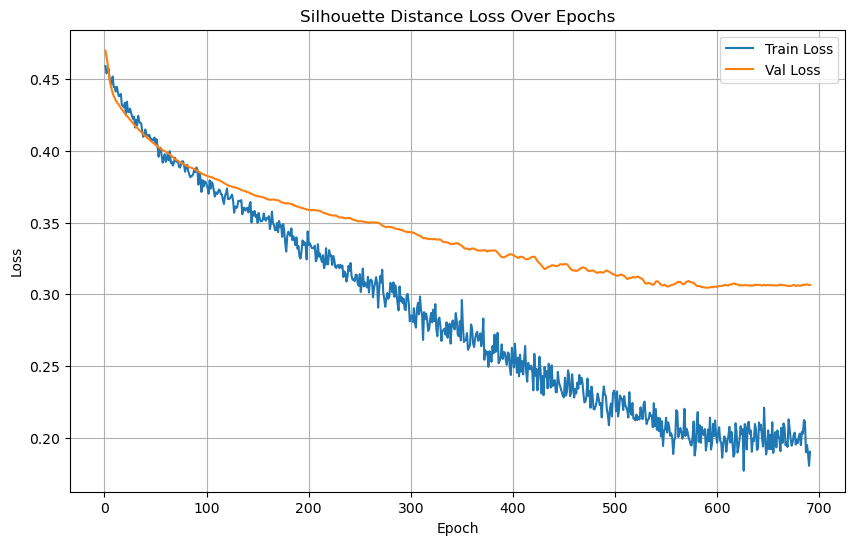

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/663], Loss: 0.2515


Test Batch [20/663], Loss: 0.1338
Test Batch [30/663], Loss: 0.2848


Test Batch [40/663], Loss: 0.3480
Test Batch [50/663], Loss: 0.4464


Test Batch [60/663], Loss: 0.3439
Test Batch [70/663], Loss: 0.2625
Test Batch [80/663], Loss: 0.2177


Test Batch [90/663], Loss: 0.1270


Test Batch [100/663], Loss: 0.1503
Test Batch [110/663], Loss: 0.1116
Test Batch [120/663], Loss: 0.2219
Test Batch [130/663], Loss: 0.2341


Test Batch [140/663], Loss: 0.2556
Test Batch [150/663], Loss: 0.1038
Test Batch [160/663], Loss: 0.2457
Test Batch [170/663], Loss: 0.2663
Test Batch [180/663], Loss: 0.5000
Test Batch [190/663], Loss: 0.5000


Test Batch [200/663], Loss: 0.0831
Test Batch [210/663], Loss: 0.5000
Test Batch [220/663], Loss: 0.5000
Test Batch [230/663], Loss: 0.5000
Test Batch [240/663], Loss: 0.5000
Test Batch [250/663], Loss: 0.5000
Test Batch [260/663], Loss: 0.5000
Test Batch [270/663], Loss: 0.5000
Test Batch [280/663], Loss: 0.5000
Test Batch [290/663], Loss: 0.5000
Test Batch [300/663], Loss: 0.2352


Test Batch [310/663], Loss: 0.0939
Test Batch [320/663], Loss: 0.1923
Test Batch [330/663], Loss: 0.1412
Test Batch [340/663], Loss: 0.1535


Test Batch [350/663], Loss: 0.1623
Test Batch [360/663], Loss: 0.1476
Test Batch [370/663], Loss: 0.0977


Test Batch [380/663], Loss: 0.1405
Test Batch [390/663], Loss: 0.0996
Test Batch [400/663], Loss: 0.0942


Test Batch [410/663], Loss: 0.1280
Test Batch [420/663], Loss: 0.1245
Test Batch [430/663], Loss: 0.2194


Test Batch [440/663], Loss: 0.2257
Test Batch [450/663], Loss: 0.2449
Test Batch [460/663], Loss: 0.3370
Test Batch [470/663], Loss: 0.2753


Test Batch [480/663], Loss: 0.1835
Test Batch [490/663], Loss: 0.1122
Test Batch [500/663], Loss: 0.2258


Test Batch [510/663], Loss: 0.1147
Test Batch [520/663], Loss: 0.2223
Test Batch [530/663], Loss: 0.2180
Test Batch [540/663], Loss: 0.2077


Test Batch [550/663], Loss: 0.2020
Test Batch [560/663], Loss: 0.1593
Test Batch [570/663], Loss: 0.2637
Test Batch [580/663], Loss: 0.2086


Test Batch [590/663], Loss: 0.2638
Test Batch [600/663], Loss: 0.3293
Test Batch [610/663], Loss: 0.2934
Test Batch [620/663], Loss: 0.1578
Test Batch [630/663], Loss: 0.2402


Test Batch [640/663], Loss: 0.3029
Test Batch [650/663], Loss: 0.2907
Test Batch [660/663], Loss: 0.4546

Test Loss: 0.2672


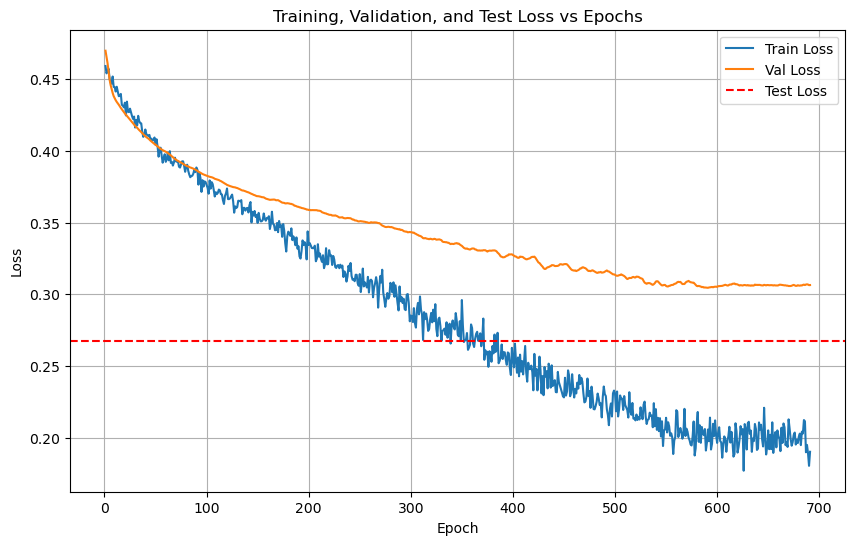

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/663 for test dataset.


  Processed batch 20/663 for test dataset.
  Processed batch 30/663 for test dataset.
  Processed batch 40/663 for test dataset.
  Processed batch 50/663 for test dataset.


  Processed batch 60/663 for test dataset.
  Processed batch 70/663 for test dataset.
  Processed batch 80/663 for test dataset.


  Processed batch 90/663 for test dataset.
  Processed batch 100/663 for test dataset.
  Processed batch 110/663 for test dataset.


  Processed batch 120/663 for test dataset.
  Processed batch 130/663 for test dataset.
  Processed batch 140/663 for test dataset.


  Processed batch 150/663 for test dataset.
  Processed batch 160/663 for test dataset.
  Processed batch 170/663 for test dataset.


  Processed batch 180/663 for test dataset.
  Processed batch 190/663 for test dataset.
  Processed batch 200/663 for test dataset.
  Processed batch 210/663 for test dataset.


  Processed batch 220/663 for test dataset.
  Processed batch 230/663 for test dataset.
  Processed batch 240/663 for test dataset.


  Processed batch 250/663 for test dataset.
  Processed batch 260/663 for test dataset.
  Processed batch 270/663 for test dataset.
  Processed batch 280/663 for test dataset.


  Processed batch 290/663 for test dataset.
  Processed batch 300/663 for test dataset.
  Processed batch 310/663 for test dataset.


  Processed batch 320/663 for test dataset.
  Processed batch 330/663 for test dataset.
  Processed batch 340/663 for test dataset.
  Processed batch 350/663 for test dataset.


  Processed batch 360/663 for test dataset.
  Processed batch 370/663 for test dataset.
  Processed batch 380/663 for test dataset.


  Processed batch 390/663 for test dataset.
  Processed batch 400/663 for test dataset.


  Processed batch 410/663 for test dataset.
  Processed batch 420/663 for test dataset.
  Processed batch 430/663 for test dataset.


  Processed batch 440/663 for test dataset.
  Processed batch 450/663 for test dataset.
  Processed batch 460/663 for test dataset.


  Processed batch 470/663 for test dataset.
  Processed batch 480/663 for test dataset.
  Processed batch 490/663 for test dataset.


  Processed batch 500/663 for test dataset.
  Processed batch 510/663 for test dataset.
  Processed batch 520/663 for test dataset.
  Processed batch 530/663 for test dataset.


  Processed batch 540/663 for test dataset.
  Processed batch 550/663 for test dataset.
  Processed batch 560/663 for test dataset.
  Processed batch 570/663 for test dataset.


  Processed batch 580/663 for test dataset.
  Processed batch 590/663 for test dataset.
  Processed batch 600/663 for test dataset.
  Processed batch 610/663 for test dataset.


  Processed batch 620/663 for test dataset.
  Processed batch 630/663 for test dataset.
  Processed batch 640/663 for test dataset.
  Processed batch 650/663 for test dataset.


  Processed batch 660/663 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5
           2       0.57      0.80      0.67         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      0.60      0.75         5
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.90      0.87      0.87        45
weighted avg       0.90      0.87      0.87        45


LOG: Evaluating on the test set...
Test Accuracy: 74.99%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1205  |  Val Loss: 2.0660
Validation loss improved from inf to 2.0660.
[Epoch 2/1000] Train Loss: 2.0038  |  Val Loss: 1.9739
Validation loss improved from 2.0660 to 1.9739.
[Epoch 3/1000] Train Loss: 1.9019  |  Val Loss: 1.8933
Validation loss improved from 1.9739 to 1.8933.
[Epoch 4/1000] Train Loss: 1.8143  |  Val Loss: 1.8205
Validation loss improved from 1.8933 to 1.8205.
[Epoch 5/1000] Train Loss: 1.7355  |  Val Loss: 1.7552
Validation loss improved from 1.8205 to 1.7552.
[Epoch 6/1000] Train Loss: 1.6664  |  Val Loss: 1.7007
Validation loss improved from 1.7552 to 1.7007.
[Epoch 7/1000] Train Loss: 1.6086  |  Val Loss: 1.6564
Validation loss improved from 1.7007 to 1.6564.
[Epoch 8/1000] Train Loss: 1.5596  |  Val Loss: 1.6190
Validation loss improved from 1.6564 to 1.6190.
[Epoch 9/1000] Train Loss: 1.5210  |  Val Loss: 1.5864
Validation loss improved from 1.6190 to 1.5864.
[Epoch 10/1000] Train Loss: 1.4881  |  Val Loss: 1.5564
Validation loss impr

[Epoch 14/1000] Train Loss: 1.3822  |  Val Loss: 1.4547
Validation loss improved from 1.4780 to 1.4547.
[Epoch 15/1000] Train Loss: 1.3602  |  Val Loss: 1.4331
Validation loss improved from 1.4547 to 1.4331.
[Epoch 16/1000] Train Loss: 1.3391  |  Val Loss: 1.4135
Validation loss improved from 1.4331 to 1.4135.
[Epoch 17/1000] Train Loss: 1.3186  |  Val Loss: 1.3923
Validation loss improved from 1.4135 to 1.3923.


[Epoch 18/1000] Train Loss: 1.2984  |  Val Loss: 1.3723
Validation loss improved from 1.3923 to 1.3723.
[Epoch 19/1000] Train Loss: 1.2785  |  Val Loss: 1.3540
Validation loss improved from 1.3723 to 1.3540.
[Epoch 20/1000] Train Loss: 1.2602  |  Val Loss: 1.3363
Validation loss improved from 1.3540 to 1.3363.
[Epoch 21/1000] Train Loss: 1.2418  |  Val Loss: 1.3202
Validation loss improved from 1.3363 to 1.3202.
[Epoch 22/1000] Train Loss: 1.2243  |  Val Loss: 1.3043
Validation loss improved from 1.3202 to 1.3043.
[Epoch 23/1000] Train Loss: 1.2070  |  Val Loss: 1.2894
Validation loss improved from 1.3043 to 1.2894.
[Epoch 24/1000] Train Loss: 1.1903  |  Val Loss: 1.2745
Validation loss improved from 1.2894 to 1.2745.
[Epoch 25/1000] Train Loss: 1.1735  |  Val Loss: 1.2604
Validation loss improved from 1.2745 to 1.2604.
[Epoch 26/1000] Train Loss: 1.1575  |  Val Loss: 1.2471
Validation loss improved from 1.2604 to 1.2471.
[Epoch 27/1000] Train Loss: 1.1416  |  Val Loss: 1.2340
Validati

[Epoch 31/1000] Train Loss: 1.0795  |  Val Loss: 1.1837
Validation loss improved from 1.1960 to 1.1837.
[Epoch 32/1000] Train Loss: 1.0646  |  Val Loss: 1.1716
Validation loss improved from 1.1837 to 1.1716.
[Epoch 33/1000] Train Loss: 1.0495  |  Val Loss: 1.1598
Validation loss improved from 1.1716 to 1.1598.


[Epoch 34/1000] Train Loss: 1.0344  |  Val Loss: 1.1473
Validation loss improved from 1.1598 to 1.1473.
[Epoch 35/1000] Train Loss: 1.0196  |  Val Loss: 1.1361
Validation loss improved from 1.1473 to 1.1361.
[Epoch 36/1000] Train Loss: 1.0046  |  Val Loss: 1.1246
Validation loss improved from 1.1361 to 1.1246.
[Epoch 37/1000] Train Loss: 0.9900  |  Val Loss: 1.1132
Validation loss improved from 1.1246 to 1.1132.
[Epoch 38/1000] Train Loss: 0.9754  |  Val Loss: 1.1020
Validation loss improved from 1.1132 to 1.1020.
[Epoch 39/1000] Train Loss: 0.9609  |  Val Loss: 1.0911
Validation loss improved from 1.1020 to 1.0911.
[Epoch 40/1000] Train Loss: 0.9464  |  Val Loss: 1.0804
Validation loss improved from 1.0911 to 1.0804.
[Epoch 41/1000] Train Loss: 0.9320  |  Val Loss: 1.0696
Validation loss improved from 1.0804 to 1.0696.
[Epoch 42/1000] Train Loss: 0.9178  |  Val Loss: 1.0590
Validation loss improved from 1.0696 to 1.0590.
[Epoch 43/1000] Train Loss: 0.9035  |  Val Loss: 1.0489
Validati

[Epoch 49/1000] Train Loss: 0.8181  |  Val Loss: 0.9862
Validation loss improved from 0.9968 to 0.9862.
[Epoch 50/1000] Train Loss: 0.8038  |  Val Loss: 0.9757
Validation loss improved from 0.9862 to 0.9757.
[Epoch 51/1000] Train Loss: 0.7896  |  Val Loss: 0.9655
Validation loss improved from 0.9757 to 0.9655.
[Epoch 52/1000] Train Loss: 0.7752  |  Val Loss: 0.9551
Validation loss improved from 0.9655 to 0.9551.
[Epoch 53/1000] Train Loss: 0.7611  |  Val Loss: 0.9450
Validation loss improved from 0.9551 to 0.9450.
[Epoch 54/1000] Train Loss: 0.7468  |  Val Loss: 0.9345
Validation loss improved from 0.9450 to 0.9345.
[Epoch 55/1000] Train Loss: 0.7326  |  Val Loss: 0.9239
Validation loss improved from 0.9345 to 0.9239.
[Epoch 56/1000] Train Loss: 0.7178  |  Val Loss: 0.9135
Validation loss improved from 0.9239 to 0.9135.
[Epoch 57/1000] Train Loss: 0.7036  |  Val Loss: 0.9032
Validation loss improved from 0.9135 to 0.9032.
[Epoch 58/1000] Train Loss: 0.6891  |  Val Loss: 0.8934
Validati

[Epoch 67/1000] Train Loss: 0.5609  |  Val Loss: 0.8043
Validation loss improved from 0.8138 to 0.8043.
[Epoch 68/1000] Train Loss: 0.5467  |  Val Loss: 0.7952
Validation loss improved from 0.8043 to 0.7952.
[Epoch 69/1000] Train Loss: 0.5335  |  Val Loss: 0.7863
Validation loss improved from 0.7952 to 0.7863.
[Epoch 70/1000] Train Loss: 0.5202  |  Val Loss: 0.7785
Validation loss improved from 0.7863 to 0.7785.
[Epoch 71/1000] Train Loss: 0.5071  |  Val Loss: 0.7706
Validation loss improved from 0.7785 to 0.7706.
[Epoch 72/1000] Train Loss: 0.4944  |  Val Loss: 0.7626
Validation loss improved from 0.7706 to 0.7626.
[Epoch 73/1000] Train Loss: 0.4819  |  Val Loss: 0.7550
Validation loss improved from 0.7626 to 0.7550.
[Epoch 74/1000] Train Loss: 0.4698  |  Val Loss: 0.7482
Validation loss improved from 0.7550 to 0.7482.
[Epoch 75/1000] Train Loss: 0.4580  |  Val Loss: 0.7408
Validation loss improved from 0.7482 to 0.7408.
[Epoch 76/1000] Train Loss: 0.4462  |  Val Loss: 0.7340
Validati

[Epoch 83/1000] Train Loss: 0.3736  |  Val Loss: 0.6935
Validation loss improved from 0.6991 to 0.6935.
[Epoch 84/1000] Train Loss: 0.3643  |  Val Loss: 0.6881
Validation loss improved from 0.6935 to 0.6881.
[Epoch 85/1000] Train Loss: 0.3553  |  Val Loss: 0.6822
Validation loss improved from 0.6881 to 0.6822.
[Epoch 86/1000] Train Loss: 0.3465  |  Val Loss: 0.6777
Validation loss improved from 0.6822 to 0.6777.
[Epoch 87/1000] Train Loss: 0.3382  |  Val Loss: 0.6739
Validation loss improved from 0.6777 to 0.6739.
[Epoch 88/1000] Train Loss: 0.3304  |  Val Loss: 0.6701
Validation loss improved from 0.6739 to 0.6701.
[Epoch 89/1000] Train Loss: 0.3225  |  Val Loss: 0.6659
Validation loss improved from 0.6701 to 0.6659.
[Epoch 90/1000] Train Loss: 0.3147  |  Val Loss: 0.6625
Validation loss improved from 0.6659 to 0.6625.
[Epoch 91/1000] Train Loss: 0.3074  |  Val Loss: 0.6587
Validation loss improved from 0.6625 to 0.6587.
[Epoch 92/1000] Train Loss: 0.3005  |  Val Loss: 0.6559
Validati

[Epoch 100/1000] Train Loss: 0.2513  |  Val Loss: 0.6454
Validation loss improved from 0.6457 to 0.6454.
[Epoch 101/1000] Train Loss: 0.2461  |  Val Loss: 0.6455
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 0.2411  |  Val Loss: 0.6458
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 0.2364  |  Val Loss: 0.6451
Validation loss improved from 0.6454 to 0.6451.
[Epoch 104/1000] Train Loss: 0.2320  |  Val Loss: 0.6450
Validation loss improved from 0.6451 to 0.6450.
[Epoch 105/1000] Train Loss: 0.2277  |  Val Loss: 0.6455
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 106/1000] Train Loss: 0.2234  |  Val Loss: 0.6470
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 107/1000] Train Loss: 0.2196  |  Val Loss: 0.6466
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 108/1000] Train Loss: 0.2156  |  Val Loss: 0.6484
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 109/1000] Tr

[Epoch 117/1000] Train Loss: 0.1871  |  Val Loss: 0.6613
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 118/1000] Train Loss: 0.1848  |  Val Loss: 0.6637
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 119/1000] Train Loss: 0.1821  |  Val Loss: 0.6634
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 120/1000] Train Loss: 0.1797  |  Val Loss: 0.6640
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 121/1000] Train Loss: 0.1774  |  Val Loss: 0.6661
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 122/1000] Train Loss: 0.1751  |  Val Loss: 0.6685
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 123/1000] Train Loss: 0.1730  |  Val Loss: 0.6692
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 124/1000] Train Loss: 0.1710  |  Val Loss: 0.6704
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 125/1000] Train Loss: 0.1691  |  Val Loss: 0.6726
!! Validation loss did NOT improve !! Patience:

[Epoch 133/1000] Train Loss: 0.1555  |  Val Loss: 0.6902
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 134/1000] Train Loss: 0.1542  |  Val Loss: 0.6917
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 135/1000] Train Loss: 0.1527  |  Val Loss: 0.6951
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 136/1000] Train Loss: 0.1514  |  Val Loss: 0.6972
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 137/1000] Train Loss: 0.1500  |  Val Loss: 0.6988
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 138/1000] Train Loss: 0.1486  |  Val Loss: 0.7010
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 139/1000] Train Loss: 0.1474  |  Val Loss: 0.7041
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 140/1000] Train Loss: 0.1462  |  Val Loss: 0.7049
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 141/1000] Train Loss: 0.1451  |  Val Loss: 0.7064
!! Validation loss did NOT improve !! Patience:

[Epoch 150/1000] Train Loss: 0.1358  |  Val Loss: 0.7279
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 151/1000] Train Loss: 0.1349  |  Val Loss: 0.7290
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 152/1000] Train Loss: 0.1340  |  Val Loss: 0.7295
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 153/1000] Train Loss: 0.1332  |  Val Loss: 0.7308
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 154/1000] Train Loss: 0.1324  |  Val Loss: 0.7323
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 155/1000] Train Loss: 0.1317  |  Val Loss: 0.7338
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 156/1000] Train Loss: 0.1309  |  Val Loss: 0.7357
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 157/1000] Train Loss: 0.1306  |  Val Loss: 0.7375
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 158/1000] Train Loss: 0.1294  |  Val Loss: 0.7397
!! Validation loss did NOT improve !! Patience:

[Epoch 166/1000] Train Loss: 0.1239  |  Val Loss: 0.7524
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 167/1000] Train Loss: 0.1237  |  Val Loss: 0.7528
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 168/1000] Train Loss: 0.1228  |  Val Loss: 0.7534
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 169/1000] Train Loss: 0.1222  |  Val Loss: 0.7543
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 170/1000] Train Loss: 0.1217  |  Val Loss: 0.7568
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 171/1000] Train Loss: 0.1212  |  Val Loss: 0.7581
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 172/1000] Train Loss: 0.1206  |  Val Loss: 0.7594
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 173/1000] Train Loss: 0.1202  |  Val Loss: 0.7627
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 174/1000] Train Loss: 0.1196  |  Val Loss: 0.7654
!! Validation loss did NOT improve !! Patience:

[Epoch 183/1000] Train Loss: 0.1153  |  Val Loss: 0.7758
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 184/1000] Train Loss: 0.1149  |  Val Loss: 0.7775
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 185/1000] Train Loss: 0.1145  |  Val Loss: 0.7790
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 186/1000] Train Loss: 0.1141  |  Val Loss: 0.7794
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 187/1000] Train Loss: 0.1136  |  Val Loss: 0.7822
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 188/1000] Train Loss: 0.1132  |  Val Loss: 0.7861
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 189/1000] Train Loss: 0.1127  |  Val Loss: 0.7881
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 190/1000] Train Loss: 0.1124  |  Val Loss: 0.7898
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 191/1000] Train Loss: 0.1120  |  Val Loss: 0.7906
!! Validation loss did NOT improve !! Patience:

[Epoch 200/1000] Train Loss: 0.1086  |  Val Loss: 0.8011
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 201/1000] Train Loss: 0.1085  |  Val Loss: 0.8048
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 202/1000] Train Loss: 0.1079  |  Val Loss: 0.8063
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 203/1000] Train Loss: 0.1076  |  Val Loss: 0.8073
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 204/1000] Train Loss: 0.1072  |  Val Loss: 0.8097
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 204 !!
No improvement for 100 epochs.


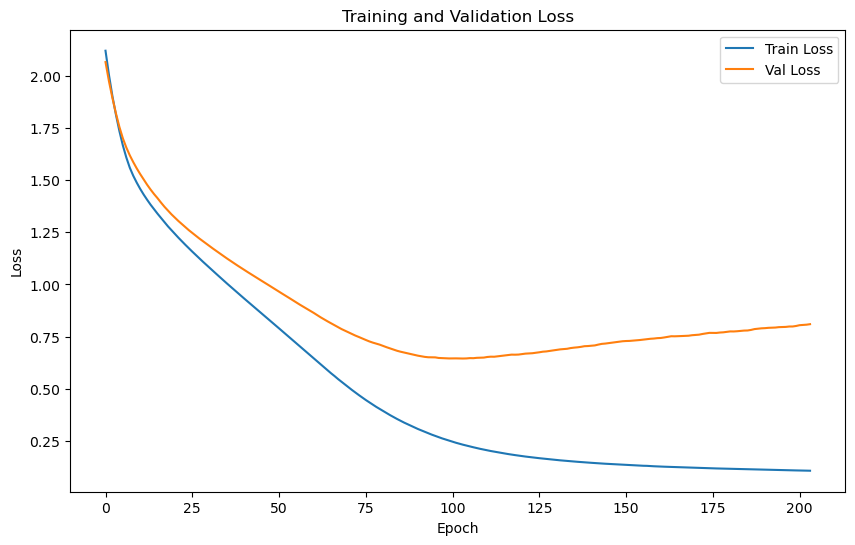

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7058 | Test Accuracy: 75.38%


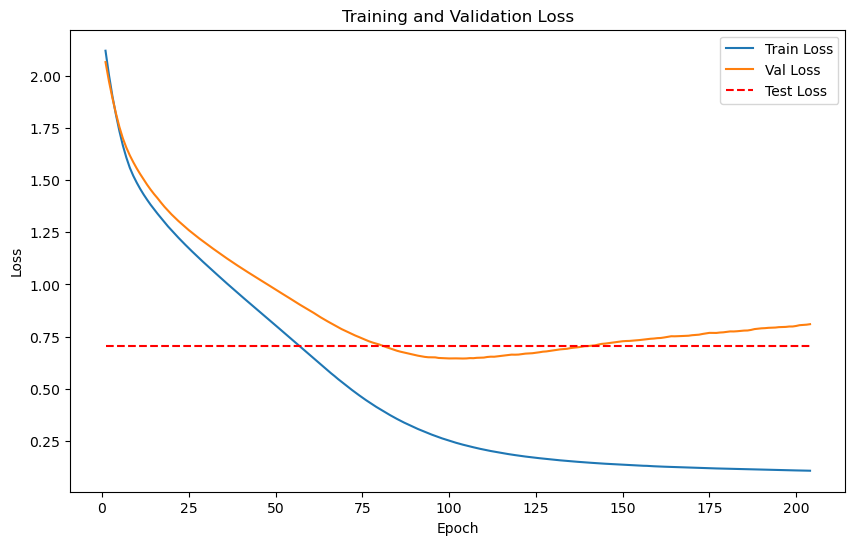

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


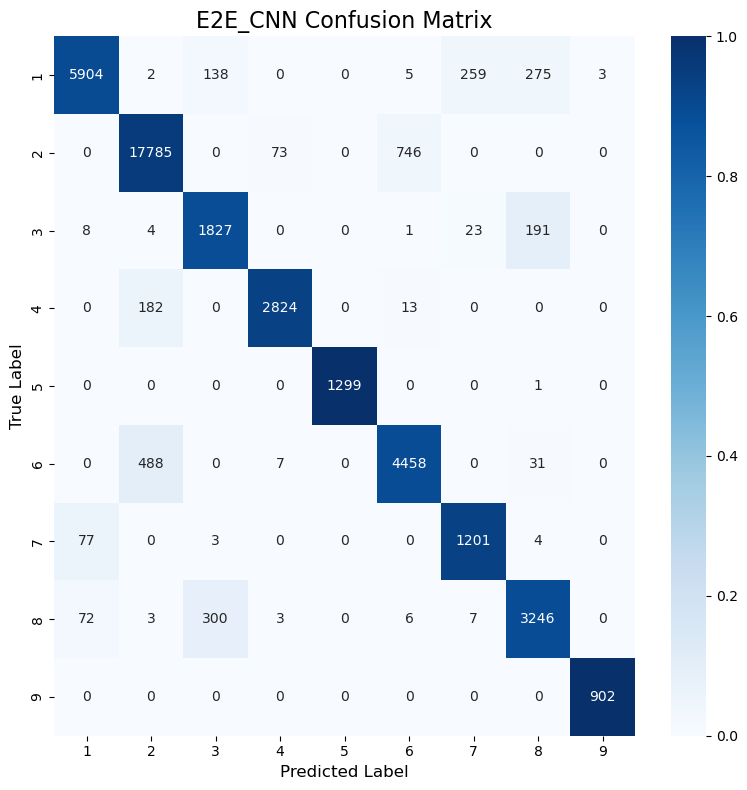

Classification Accuracy: 93.10%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


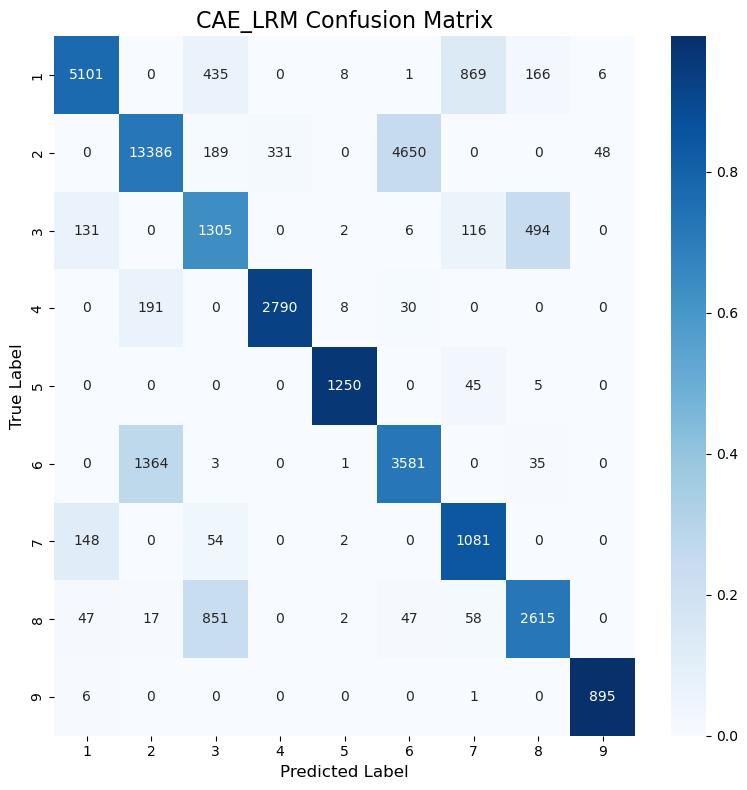

Classification Accuracy: 75.53%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


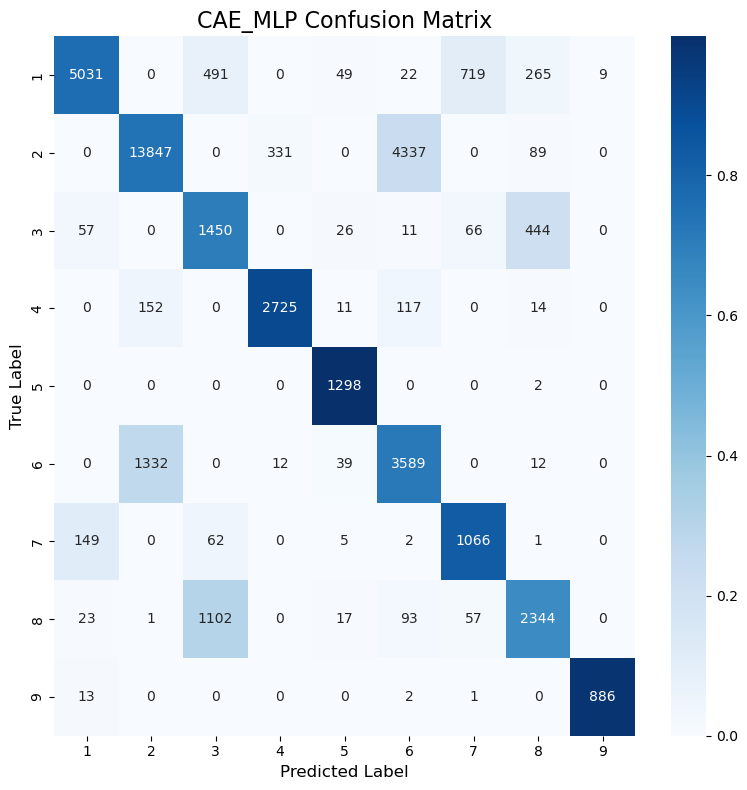

Classification Accuracy: 76.08%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


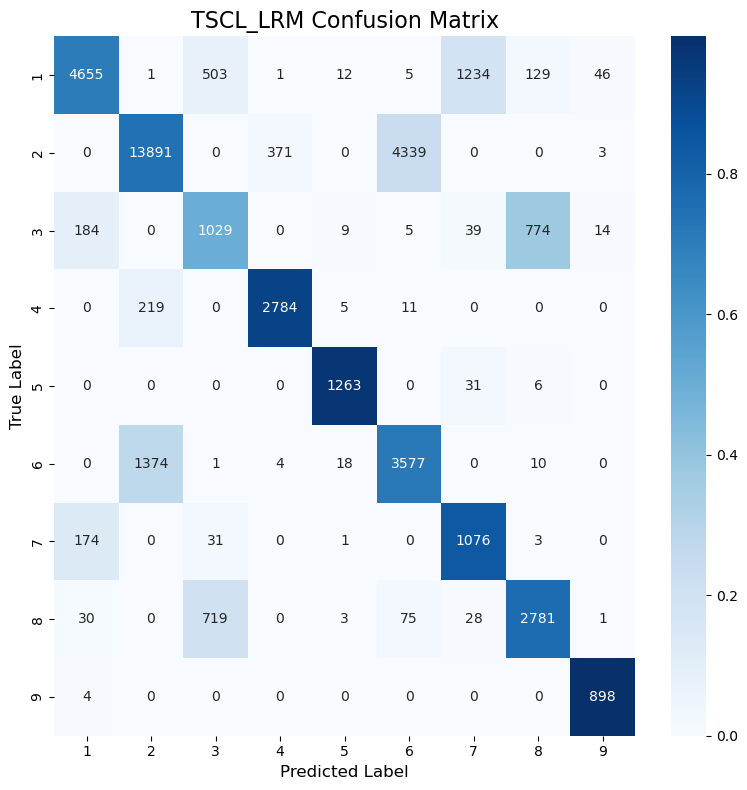

Classification Accuracy: 75.41%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


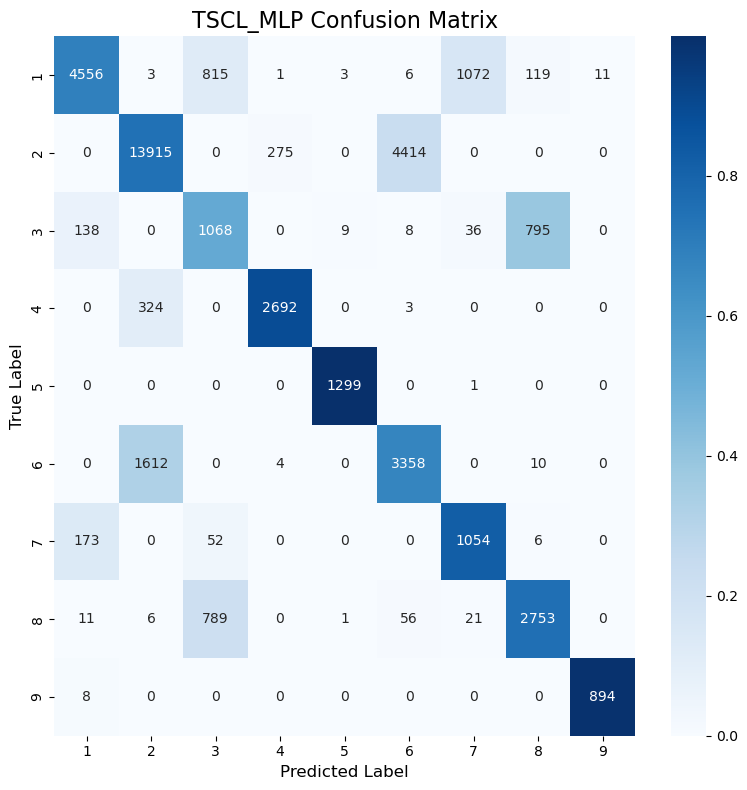

Classification Accuracy: 74.55%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


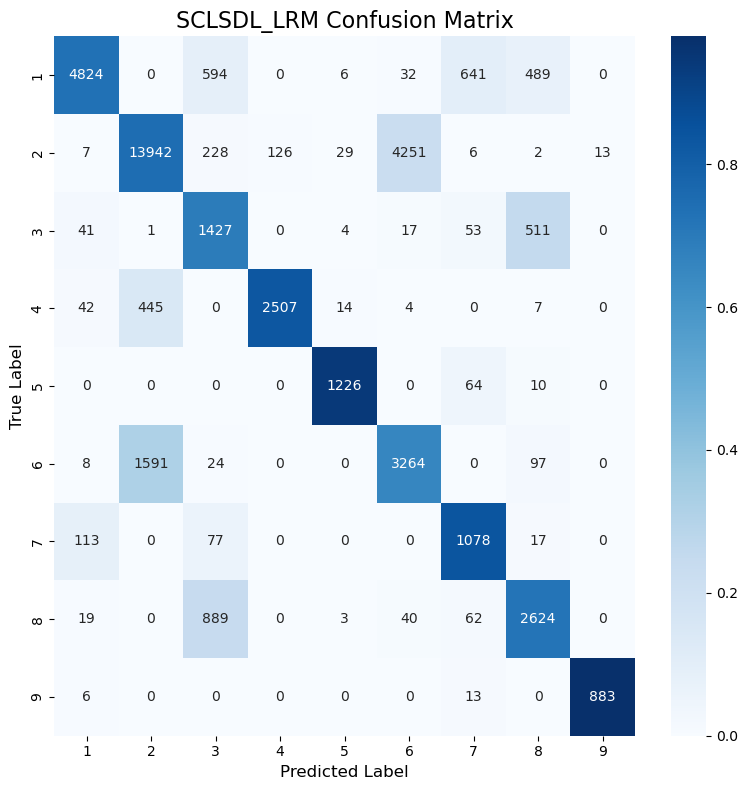

Classification Accuracy: 74.99%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


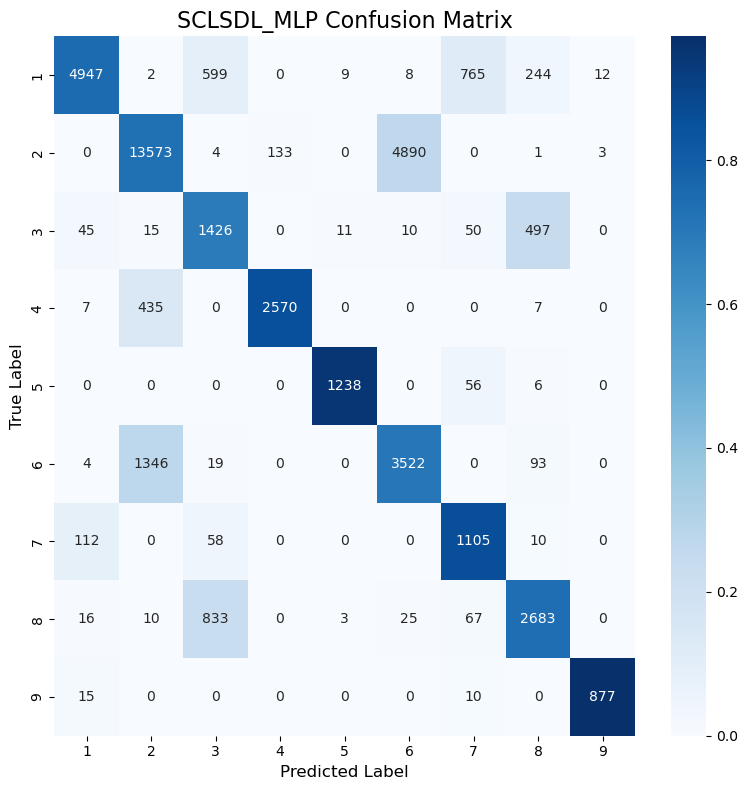

Classification Accuracy: 75.38%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          93.10
1    LRM (CAE)          75.53
2    MLP (CAE)          76.08
3     TSCL LRM          75.41
4     TSCL MLP          74.55
5  SCL_SDL LRM          74.99
6  SCL_SDL MLP          75.38

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          93.10
2    MLP (CAE)          76.08
1    LRM (CAE)          75.53
3     TSCL LRM          75.41
6  SCL_SDL MLP          75.38
5  SCL_SDL LRM          74.99
4     TSCL MLP          74.55
